#

<h1 style="text-align: center;">NHS DATA ANALYTICS USING PYTHON</h1>

#

# Introduction
The purpose of this project is to analyse NHS data to address key questions related to service utilisation, capacity adequacy, 
and missed appointments. Additionally, I'll explore the potential of leveraging social media data to inform NHS strategies. 

This notebook demonstrates the data exploration, wrangling, and analysis process using Python.

---

# Objectives
  The key objectives of this analysis are:
- Understand the data coverage (e.g., date range, regions, categories).
- Identify trends in service utilisation (monthly and seasonal patterns).
- Investigate missed appointments and their potential causes.
- Analyse Twitter data for trending healthcare-related hashtags and insights.
- Provide actionable recommendations to NHS stakeholders.

---

# Dataset Overview
The following datasets are used in this analysis:
1. **actual_duration.csv**: Contains details about appointment durations, dates, and regions.
2. **appointments_regional.csv**: Includes appointment types, statuses, modes, and time to appointment.
3. **national_categories.xlsx**: Provides information on service settings, context types, and categories.
4. **tweets.csv**: Contains healthcare-related tweets, including hashtags.
5. **metadata_nhs.txt**: Describes data quality and column definitions.

---

# Prepare Workstation

In [4]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from wordcloud import WordCloud
from IPython.display import display
from textblob import TextBlob

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

---

# Import and Clean Data

<h1 style="text-align: center;">National Categories File</h1>

In [5]:
# Import and sense-check the national_categories.xlsx data set as nc.
nc = pd.read_excel('national_categories.xlsx')

# View the DataFrame.
nc.head()

appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
2       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
3       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
4       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   
1                 Other  Care Related Encounter   
2      General Practice  Care Related Encounter   
3      General Practice  Care Related Encounter   
4      General Practice  Care Related Encounter   

                        national_category  count_of_appointments  \
0  Patient contact during Care Home Round                      3   
1                         Planned Clinics                      7   
2                              Home Visit                     79   
3              General Consultation Acute                    725   
4            Structured Medication Review                      2   

  appointment_month  
0           2021-08  
1           2021-08  
2           2021-08  
3           2021-08  
4           2021-08

In [6]:
# Determine the metadata of the data set.
nc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB


In [7]:
nc.shape

(817394, 8)

In [8]:
nc.columns

Index(['appointment_date', 'icb_ons_code', 'sub_icb_location_name',
       'service_setting', 'context_type', 'national_category',
       'count_of_appointments', 'appointment_month'],
      dtype='object')

In [9]:
# Determine the descriptive statistics of the data set.
nc.describe()

appointment_date  count_of_appointments
count                         817394          817394.000000
mean   2022-01-16 00:50:35.860796160             362.183684
min              2021-08-01 00:00:00               1.000000
25%              2021-10-25 00:00:00               7.000000
50%              2022-01-18 00:00:00              25.000000
75%              2022-04-07 00:00:00             128.000000
max              2022-06-30 00:00:00           16590.000000
std                              NaN            1084.576600

In [10]:
# Determine whether there are missing values.
print(nc.isnull().any())

appointment_date         False
icb_ons_code             False
sub_icb_location_name    False
service_setting          False
context_type             False
national_category        False
count_of_appointments    False
appointment_month        False
dtype: bool


In [11]:
# Identify duplicates
duplicates_nc = nc.duplicated().sum()
duplicates_nc

np.int64(0)

In [12]:
print(nc['appointment_month'].head(1))

0    2021-08
Name: appointment_month, dtype: object


In [13]:
# Convert 'appointment_month' to datetime 
nc['appointment_month'] = pd.to_datetime(nc['appointment_month'], format='%Y-%m')

# Verify the conversion
print(nc['appointment_month'].head(1))

0   2021-08-01
Name: appointment_month, dtype: datetime64[ns]


In [14]:
# Convert to period
nc['appointment_month'] = nc['appointment_month'].dt.to_period('M')

In [15]:
print(nc['appointment_month'].head(1))

0    2021-08
Name: appointment_month, dtype: period[M]


In [16]:
# Determine the minimum and maximum dates in appointment_month column
min_date = nc['appointment_month'].min()
max_date = nc['appointment_month'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2021-08
Maximum date: 2022-06


In [17]:
# Determine the minimum and maximum dates in appoinntment_date column
min_date = nc['appointment_date'].min()
max_date = nc['appointment_date'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2021-08-01 00:00:00
Maximum date: 2022-06-30 00:00:00


#####

---

# Import and Clean Data

<h1 style="text-align: center;">Appointments Regional File</h1>

In [18]:
# Import and sense-check the appointments_regional.csv data set as ar.
ar = pd.read_csv('appointments_regional.csv')

# View the DataFrame.
ar.head(10)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034           2020-01           Attended       GP     Face-to-Face   
3    E54000034           2020-01           Attended       GP     Face-to-Face   
4    E54000034           2020-01           Attended       GP     Face-to-Face   
5    E54000034           2020-01           Attended       GP     Face-to-Face   
6    E54000034           2020-01           Attended       GP     Face-to-Face   
7    E54000034           2020-01           Attended       GP       Home Visit   
8    E54000034           2020-01           Attended       GP       Home Visit   
9    E54000034           2020-01           Attended       GP       Home Visit   

  time_between_book_and_appointment  count_of_appointments  
0                             1 Day                   8107  
1                    15  to 21 Days                   6791  
2                       2 to 7 Days                  20686  
3                    22  to 28 Days                   4268  
4                     8  to 14 Days                  11971  
5                 More than 28 Days                   3273  
6                          Same Day                  64649  
7                             1 Day                    151  
8                    15  to 21 Days                     12  
9                       2 to 7 Days                    141

In [19]:
# Determine the metadata of the data set.
ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB


In [20]:
ar.shape

(596821, 7)

In [21]:
ar.columns

Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments'],
      dtype='object')

In [22]:
# Determine the descriptive statistics of the data set.
ar.describe()

count_of_appointments
count          596821.000000
mean             1244.601857
std              5856.887042
min                 1.000000
25%                 7.000000
50%                47.000000
75%               308.000000
max            211265.000000

In [23]:
# Determine whether there are missing values.
print(ar.isnull().any())

icb_ons_code                         False
appointment_month                    False
appointment_status                   False
hcp_type                             False
appointment_mode                     False
time_between_book_and_appointment    False
count_of_appointments                False
dtype: bool


In [24]:
duplicates_ar = ar.duplicated().sum()
duplicates_ar

np.int64(21604)

In [25]:
# Find all exact duplicate rows, including the first occurrence
exact_duplicates = ar[ar.duplicated(keep=False)]

# Group duplicates by all columns to find multiple examples
grouped_duplicates = exact_duplicates.groupby(list(ar.columns)).size().reset_index(name='Count')

# Filter for the first three duplicate examples with more than one occurrence
multiple_duplicate_examples = grouped_duplicates[grouped_duplicates['Count'] > 1].head(3)

# Loop through the examples to find their indexes and display rows
for i, example in multiple_duplicate_examples.iterrows():
    example_values = example[:-1].to_dict()  # Extract column values
    example_indexes = ar[(ar[list(example_values)] == pd.Series(example_values)).all(axis=1)].index.tolist()
    
    print(f"\nExample {i+1}: Duplicate Row Values")
    print(example_values)
    print("\nIndexes of the Duplicate Rows:")
    print(example_indexes)
    print("\nDuplicate Rows:")
    display(ar.loc[example_indexes])


Example 1: Duplicate Row Values
{'icb_ons_code': 'E54000008', 'appointment_month': '2020-01', 'appointment_status': 'Attended', 'hcp_type': 'GP', 'appointment_mode': 'Face-to-Face', 'time_between_book_and_appointment': 'Unknown / Data Quality', 'count_of_appointments': 1}

Indexes of the Duplicate Rows:
[496290, 505707, 516594]

Duplicate Rows:


icb_ons_code appointment_month appointment_status hcp_type  \
496290    E54000008           2020-01           Attended       GP   
505707    E54000008           2020-01           Attended       GP   
516594    E54000008           2020-01           Attended       GP   

       appointment_mode time_between_book_and_appointment  \
496290     Face-to-Face            Unknown / Data Quality   
505707     Face-to-Face            Unknown / Data Quality   
516594     Face-to-Face            Unknown / Data Quality   

        count_of_appointments  
496290                      1  
505707                      1  
516594                      1


Example 2: Duplicate Row Values
{'icb_ons_code': 'E54000008', 'appointment_month': '2020-01', 'appointment_status': 'Attended', 'hcp_type': 'GP', 'appointment_mode': 'Face-to-Face', 'time_between_book_and_appointment': 'Unknown / Data Quality', 'count_of_appointments': 2}

Indexes of the Duplicate Rows:
[487191, 522453]

Duplicate Rows:


icb_ons_code appointment_month appointment_status hcp_type  \
487191    E54000008           2020-01           Attended       GP   
522453    E54000008           2020-01           Attended       GP   

       appointment_mode time_between_book_and_appointment  \
487191     Face-to-Face            Unknown / Data Quality   
522453     Face-to-Face            Unknown / Data Quality   

        count_of_appointments  
487191                      2  
522453                      2


Example 3: Duplicate Row Values
{'icb_ons_code': 'E54000008', 'appointment_month': '2020-01', 'appointment_status': 'Attended', 'hcp_type': 'GP', 'appointment_mode': 'Face-to-Face', 'time_between_book_and_appointment': 'Unknown / Data Quality', 'count_of_appointments': 3}

Indexes of the Duplicate Rows:
[491544, 511261]

Duplicate Rows:


icb_ons_code appointment_month appointment_status hcp_type  \
491544    E54000008           2020-01           Attended       GP   
511261    E54000008           2020-01           Attended       GP   

       appointment_mode time_between_book_and_appointment  \
491544     Face-to-Face            Unknown / Data Quality   
511261     Face-to-Face            Unknown / Data Quality   

        count_of_appointments  
491544                      3  
511261                      3

In [26]:
# Remove duplicate rows.
ar = ar.drop_duplicates()
print(f"Shape after removing duplicates: {ar.shape}")

Shape after removing duplicates: (575217, 7)


In [27]:
# Convert 'appointment_month' to datetime 
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], format='%Y-%m')

# Verify the conversion
print(ar['appointment_month'].head(1))

0   2020-01-01
Name: appointment_month, dtype: datetime64[ns]


In [28]:
# Convert to datetime 
ar['appointment_month'] = ar['appointment_month'].dt.to_period('M')

In [29]:
print(ar['appointment_month'].head(1))

0    2020-01
Name: appointment_month, dtype: period[M]


In [30]:
# Determine the minimum and maximum dates
min_date = ar['appointment_month'].min()
max_date = ar['appointment_month'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2020-01
Maximum date: 2022-06


#####

---

#### Map Appointments Regional File

In [31]:
# Create a mapping dictionary from the nc file
location_mapping = nc.set_index('icb_ons_code')['sub_icb_location_name'].to_dict()

# Map the location names to the ar file
ar['location_name'] = ar['icb_ons_code'].map(location_mapping)

# Verify the updated ar DataFrame
ar.head(5)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034           2020-01           Attended       GP     Face-to-Face   
3    E54000034           2020-01           Attended       GP     Face-to-Face   
4    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments  \
0                             1 Day                   8107   
1                    15  to 21 Days                   6791   
2                       2 to 7 Days                  20686   
3                    22  to 28 Days                   4268   
4                     8  to 14 Days                  11971   

             location_name  
0  NHS Frimley ICB - D4U1Y  
1  NHS Frimley ICB - D4U1Y  
2  NHS Frimley ICB - D4U1Y  
3  NHS Frimley ICB - D4U1Y  
4  NHS Frimley ICB - D4U1Y

In [32]:
# Rearrange the columns to make 'location_name' the second column
columns = ['icb_ons_code', 'location_name'] + [col for col in ar.columns if col not in ['icb_ons_code', 'location_name']]
ar = ar[columns]

# Display the updated DataFrame
ar.head(1)

icb_ons_code            location_name appointment_month appointment_status  \
0    E54000034  NHS Frimley ICB - D4U1Y           2020-01           Attended   

  hcp_type appointment_mode time_between_book_and_appointment  \
0       GP     Face-to-Face                             1 Day   

   count_of_appointments  
0                   8107

In [33]:
# Find rows where 'location_name' is null
missing_locations = ar[ar['location_name'].isnull()]

# Display the rows with missing 'location_name'
print(missing_locations)

# Count how many rows have missing 'location_name'
print(f"Number of missing location names: {missing_locations.shape[0]}")

Empty DataFrame
Columns: [icb_ons_code, location_name, appointment_month, appointment_status, hcp_type, appointment_mode, time_between_book_and_appointment, count_of_appointments]
Index: []
Number of missing location names: 0


#####

---

# Import and Clean Data

<h1 style="text-align: center;">Actual Duration File</h1>

In [34]:
# Import and sense-check the actual_duration.csv data set as ad.
ad = pd.read_csv('actual_duration.csv')

# View the DataFrame.
ad.head(5)

sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   
2                   00L                 E38000130   
3                   00L                 E38000130   
4                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
2  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
3  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
4  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   

  appointment_date         actual_duration  count_of_appointments  
0        01-Dec-21           31-60 Minutes                    364  
1        01-Dec-21           21-30 Minutes                    619  
2        01-Dec-21            6-10 Minutes                   1698  
3        01-Dec-21  Unknown / Data Quality                   1277  
4        01-Dec-21           16-20 Minutes                    730

In [35]:
# Determine the metadata of the dataset.
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB


In [36]:
ad.shape

(137793, 8)

In [37]:
ad.columns

Index(['sub_icb_location_code', 'sub_icb_location_ons_code',
       'sub_icb_location_name', 'icb_ons_code', 'region_ons_code',
       'appointment_date', 'actual_duration', 'count_of_appointments'],
      dtype='object')

In [38]:
# Determine the descriptive statistics.
ad.describe()

count_of_appointments
count          137793.000000
mean             1219.080011
std              1546.902956
min                 1.000000
25%               194.000000
50%               696.000000
75%              1621.000000
max             15400.000000

In [39]:
# Determine whether there are missing/null values.
print(ad.isnull().sum())

sub_icb_location_code        0
sub_icb_location_ons_code    0
sub_icb_location_name        0
icb_ons_code                 0
region_ons_code              0
appointment_date             0
actual_duration              0
count_of_appointments        0
dtype: int64


In [40]:
# Identify duplicates
duplicates_ad = ad.duplicated().sum()
duplicates_ad

np.int64(0)

In [41]:
# Convert appointment_date to datetime format
ad['appointment_date'] = pd.to_datetime(ad['appointment_date'], format='%d-%b-%y', errors='coerce')

# Verify conversion
print(ad['appointment_date'].dtype)

datetime64[ns]


In [42]:
# Determine the minimum and maximum dates
min_date = ad['appointment_date'].min()
max_date = ad['appointment_date'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2021-12-01 00:00:00
Maximum date: 2022-06-30 00:00:00


#####

---

# Import and Clean Data

<h1 style="text-align: center;">Tweets File</h1>

In [43]:
# Read CSV file with UTF-8 encoding
tw = pd.read_csv('tweets.csv', encoding='utf-8')

# View the DataFrame
tw.head()

tweet_id                                    tweet_full_text  \
0  1567629223795527681  As Arkansas’ first Comprehensive Stroke Certif...   
1  1567582846612553728  RT @AndreaGrammer: Work-life balance is at the...   
2  1567582787070304256  RT @OntarioGreens: $10 billion can go a long w...   
3  1567582767625428992  RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...   
4  1567582720460570625  ICYMI: Our recent blogs on Cybersecurity in Ac...   

                                      tweet_entities  \
0  {'hashtags': [{'text': 'Healthcare', 'indices'...   
1  {'hashtags': [{'text': 'PremiseHealth', 'indic...   
2  {'hashtags': [{'text': 'Healthcare', 'indices'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, ...   
4  {'hashtags': [{'text': 'blogs', 'indices': [18...   

                             tweet_entities_hashtags  \
0                                        #Healthcare   
1                            #PremiseHealth, #hiring   
2                                        #Healthcare   
3                                               #NEW   
4  #blogs, #digitaltransformation, #cybersecurity...   

                                      tweet_metadata  tweet_retweet_count  \
0  {'iso_language_code': 'en', 'result_type': 're...                    0   
1  {'iso_language_code': 'en', 'result_type': 're...                    2   
2  {'iso_language_code': 'en', 'result_type': 're...                   39   
3  {'iso_language_code': 'en', 'result_type': 're...                    5   
4  {'iso_language_code': 'en', 'result_type': 're...                    0   

   tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                     0            False            False         en  
1                     0            False            False         en  
2                     0            False            False         en  
3                     0            False            False         en  
4                     0            False            False         en

In [44]:
# Explore the metadata.
tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 1174 non-null   int64 
 1   tweet_full_text          1174 non-null   object
 2   tweet_entities           1174 non-null   object
 3   tweet_entities_hashtags  1007 non-null   object
 4   tweet_metadata           1174 non-null   object
 5   tweet_retweet_count      1174 non-null   int64 
 6   tweet_favorite_count     1174 non-null   int64 
 7   tweet_favorited          1174 non-null   bool  
 8   tweet_retweeted          1174 non-null   bool  
 9   tweet_lang               1174 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 75.8+ KB


In [45]:
tw.shape

(1174, 10)

In [46]:
tw.columns

Index(['tweet_id', 'tweet_full_text', 'tweet_entities',
       'tweet_entities_hashtags', 'tweet_metadata', 'tweet_retweet_count',
       'tweet_favorite_count', 'tweet_favorited', 'tweet_retweeted',
       'tweet_lang'],
      dtype='object')

In [47]:
# Determine the descriptive statistics.
tw.describe()

tweet_id  tweet_retweet_count  tweet_favorite_count
count  1.174000e+03          1174.000000            1174.00000
mean   1.567612e+18             8.629472               0.37138
std    2.427553e+13            29.784675               2.04470
min    1.567574e+18             0.000000               0.00000
25%    1.567590e+18             0.000000               0.00000
50%    1.567611e+18             1.000000               0.00000
75%    1.567633e+18             3.000000               0.00000
max    1.567655e+18           303.000000              42.00000

In [48]:
# Determine whether there are missing/null values.
print(tw.isnull().sum())

tweet_id                     0
tweet_full_text              0
tweet_entities               0
tweet_entities_hashtags    167
tweet_metadata               0
tweet_retweet_count          0
tweet_favorite_count         0
tweet_favorited              0
tweet_retweeted              0
tweet_lang                   0
dtype: int64


In [49]:
# Handle missing values in tweet_entities_hashtags
tw['tweet_entities_hashtags'] = tw['tweet_entities_hashtags'].fillna('No hashtags')

In [50]:
duplicates_tw = tw.duplicated().sum()
duplicates_tw

np.int64(0)

In [51]:
# Inspect retweet and favourite counts for outliers
print(tw[['tweet_retweet_count', 'tweet_favorite_count']].describe())

       tweet_retweet_count  tweet_favorite_count
count          1174.000000            1174.00000
mean              8.629472               0.37138
std              29.784675               2.04470
min               0.000000               0.00000
25%               0.000000               0.00000
50%               1.000000               0.00000
75%               3.000000               0.00000
max             303.000000              42.00000


In [52]:
# Check the tweet_lang column
print(tw['tweet_lang'].value_counts())

tweet_lang
en    1174
Name: count, dtype: int64


#####

---

# Potential Issues In Data Quality

#### Observation: 

The metadata indicates that "Unknown / Data Quality" corresponds to either null durations or durations falling outside the expected range. This provides important context, therefore, rather than dropping or replacing these entries, I will retain them as a distinct category in the analysis to evaluate their impact and significance.

#### Objectives: 
- Examine the proportion of 'Unknown / Data Quality' by Location and Quarter;
- Flag locations and periods with high proportions of "Unknown / Data Quality" entries;
- Assess whether sub_ICB_locations with higher unknown data proportions face capacity or operational challenges.

In [53]:
# Overall proportion of 'Unknown / Data Quality'.
unknown_proportion = ad[ad["actual_duration"] == "Unknown / Data Quality"].shape[0] / ad.shape[0]
print(f"Proportion of 'Unknown / Data Quality': {unknown_proportion:.2%}")

Proportion of 'Unknown / Data Quality': 14.63%


In [54]:
# Standardise text in `actual_duration` column (e.g., remove inconsistencies in case or whitespace)
ad['actual_duration'] = ad['actual_duration'].str.strip().str.lower()

# Categorize durations as "Known" or "Unknown"
ad["duration_category"] = ad["actual_duration"].apply(
    lambda x: "Unknown" if x == "unknown / data quality" else "Known"
)

# Verify the distribution of "Known" vs. "Unknown"
print(ad["duration_category"].value_counts())

duration_category
Known      117632
Unknown     20161
Name: count, dtype: int64


In [55]:
# Group by month and count 'Unknown / Data Quality' durations
unknown_trend_monthly = (ad[ad['duration_category'] == "Unknown"]
                         .groupby(ad['appointment_date'].dt.to_period("M"))['actual_duration']
                         .count()
                         .reset_index())

# Rename columns for clarity
unknown_trend_monthly.columns = ['appointment_month', 'count_of_unknown']
unknown_trend_monthly['appointment_month'] = unknown_trend_monthly['appointment_month'].astype(str)

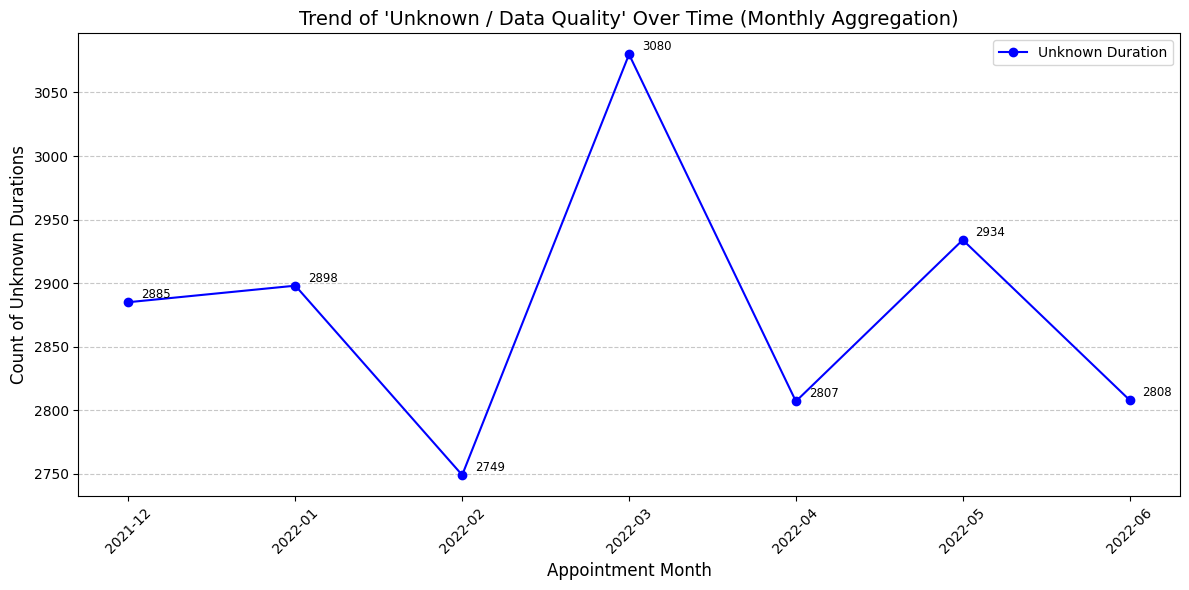

In [56]:
# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(unknown_trend_monthly['appointment_month'],
         unknown_trend_monthly['count_of_unknown'],
         marker='o', color='blue', label='Unknown Duration')

# Annotate each point with its value
for i, value in enumerate(unknown_trend_monthly['count_of_unknown']):
    plt.annotate(str(value),
                 (unknown_trend_monthly['appointment_month'][i], value),
                 textcoords="offset points",
                 xytext=(20, 3), 
                 ha='center',
                 fontsize=8.5)

plt.title("Trend of 'Unknown / Data Quality' Over Time (Monthly Aggregation)", fontsize=14)
plt.xlabel("Appointment Month", fontsize=12)
plt.ylabel("Count of Unknown Durations", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
# Create filtered_data
filtered_data = ad.copy()  
filtered_data['actual_duration'] = filtered_data['actual_duration'].str.strip().str.lower()

In [58]:
# Calculate the 'unknown_flag'
filtered_data['unknown_flag'] = filtered_data['actual_duration'].apply(
    lambda x: 1 if x == "unknown / data quality" else 0)

In [59]:
# Create appointment_month column
filtered_data['appointment_month'] = pd.to_datetime(filtered_data['appointment_date']).dt.to_period('M')

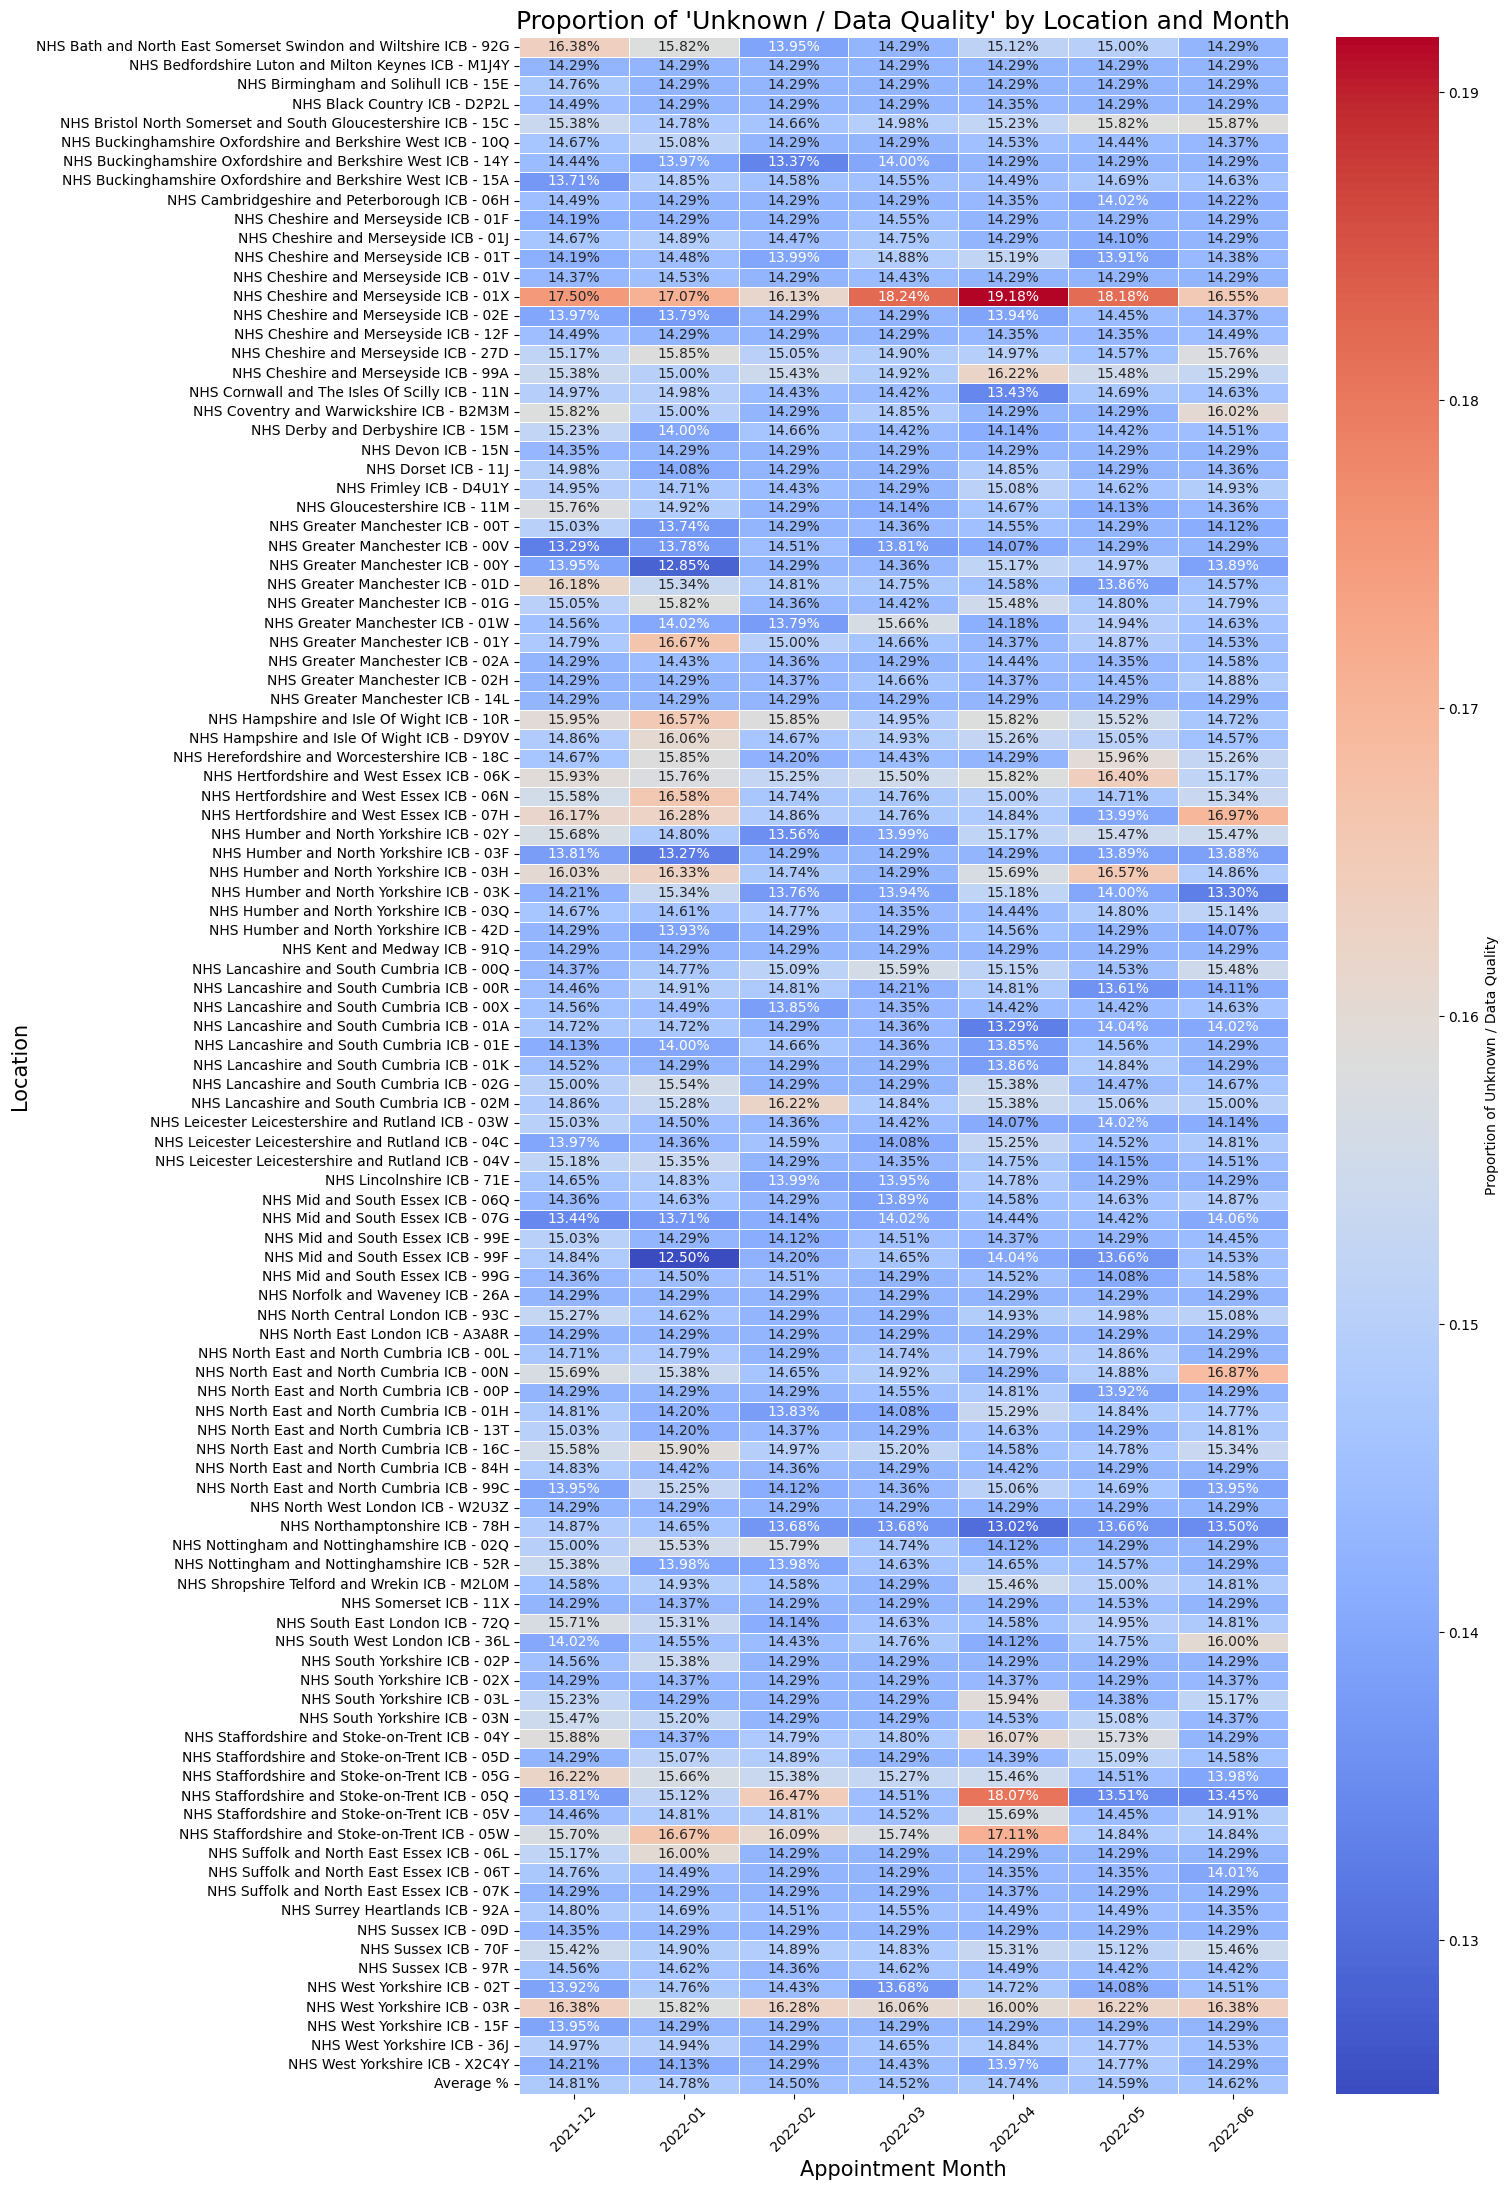

In [60]:
# Group data by location and month, calculate the mean 'unknown_flag' as the proportion
monthly_data = (filtered_data.groupby(['sub_icb_location_name', 'appointment_month'])['unknown_flag']
                .mean()
                .reset_index(name='unknown_proportion'))

# Pivot the data for heatmap plotting
heatmap_data = monthly_data.pivot(index='sub_icb_location_name',
                                  columns='appointment_month',
                                  values='unknown_proportion')

# Calculate average percentages for each month
heatmap_data.loc['Average %'] = heatmap_data.mean()

# Plot the heatmap with the added average row
plt.figure(figsize=(15, 22))  
sns.heatmap(heatmap_data,
            cmap="coolwarm",
            annot=True,
            fmt=".2%",
            cbar_kws={'label': 'Proportion of Unknown / Data Quality'},
            linewidths=0.5)

# Add titles and labels
plt.title("Proportion of 'Unknown / Data Quality' by Location and Month", fontsize=18)
plt.xlabel("Appointment Month", fontsize=15)
plt.ylabel("Location", fontsize=15)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Tighten layout to avoid cutting off
plt.tight_layout()
plt.show()

#

### Chart for stakeholder

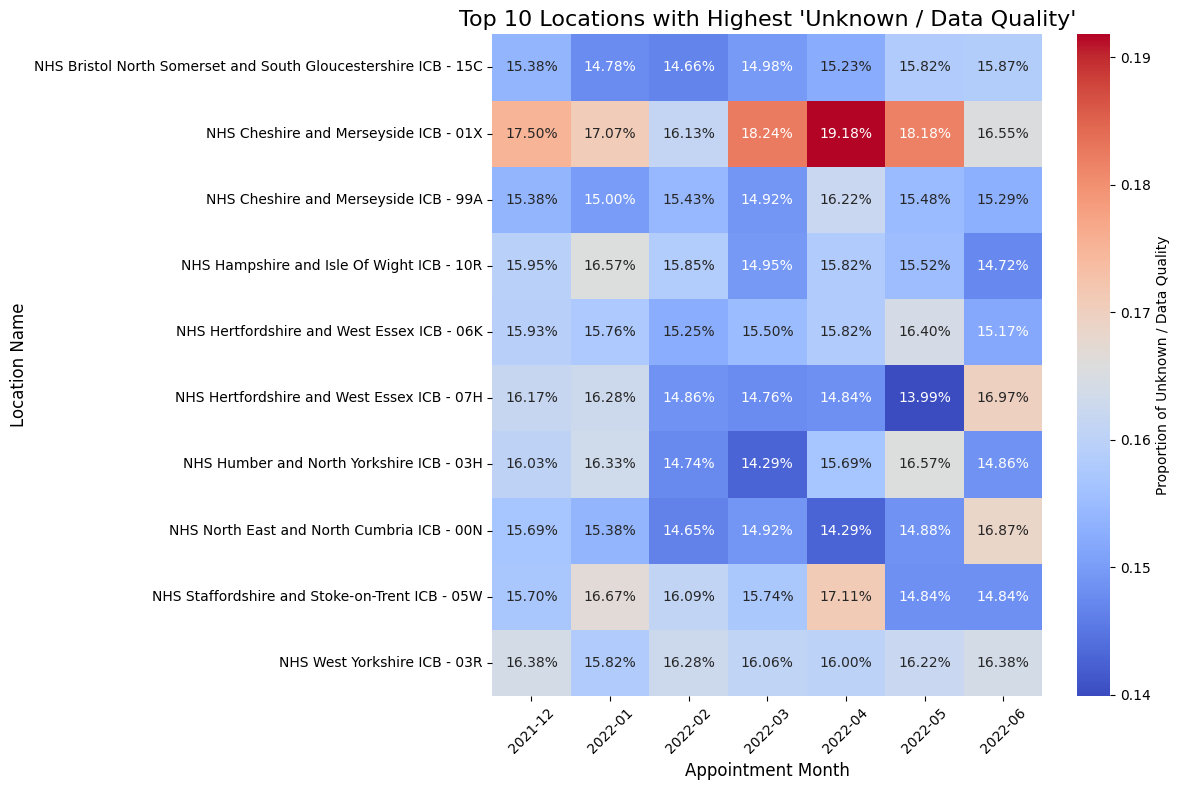

In [61]:
# Calculate mean proportion of 'unknown_flag' by location
location_impact = (filtered_data.groupby('sub_icb_location_name')['unknown_flag']
                   .mean()
                   .sort_values(ascending=False)
                   .head(10))

# Filter for the top 10 locations
top_10_data = filtered_data[filtered_data['sub_icb_location_name'].isin(location_impact.index)]

# Aggregate data by location and month for visualisation
monthly_impact = (top_10_data.groupby(['sub_icb_location_name', 'appointment_month'])['unknown_flag']
                  .mean()
                  .reset_index())

# Pivot data for plotting
pivot_data = monthly_impact.pivot(index='sub_icb_location_name',
                                  columns='appointment_month',
                                  values='unknown_flag')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data,
            cmap="coolwarm",
            annot=True,
            fmt=".2%",
            cbar_kws={'label': 'Proportion of Unknown / Data Quality'})

plt.title("Top 10 Locations with Highest 'Unknown / Data Quality'", fontsize=16)
plt.xlabel("Appointment Month", fontsize=12)
plt.ylabel("Location Name", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

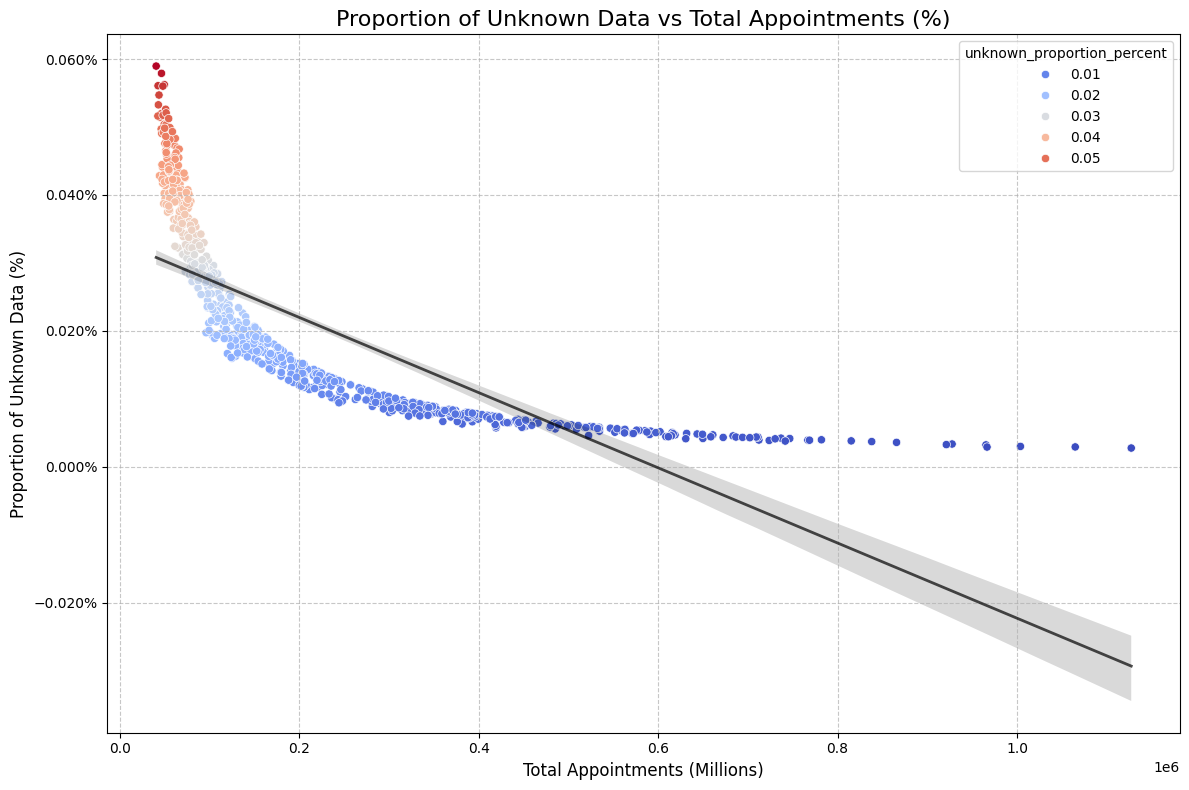

In [62]:
# Calculate unknown proportion for each location and month
unknown_correlation = (filtered_data.groupby(['sub_icb_location_name', 'appointment_month'])
                       .agg(total_appointments=('count_of_appointments', 'sum'),
                            unknown_count=('unknown_flag', 'sum'))
                       .reset_index())

# Calculate the proportion of unknown data
unknown_correlation['unknown_proportion'] = (unknown_correlation['unknown_count'] / unknown_correlation['total_appointments'])

# Convert unknown proportion to percentage
unknown_correlation['unknown_proportion_percent'] = unknown_correlation['unknown_proportion'] * 100

# Plot the scatterplot
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 8))
sns.scatterplot(x="total_appointments",
                y="unknown_proportion_percent",
                data=unknown_correlation,
                hue="unknown_proportion_percent",
                sizes=(20, 200),
                palette="coolwarm",)

sns.regplot(x="total_appointments",
            y="unknown_proportion_percent",
            data=unknown_correlation,
            scatter=False,
            color="k",
            line_kws={"linewidth": 2, "alpha": 0.7},)

# Adjust y-axis to show percentages with decimal places
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Add grid, labels, and title
plt.grid(True, linestyle="--", alpha=0.7)
plt.title("Proportion of Unknown Data vs Total Appointments (%)", fontsize=16)
plt.xlabel("Total Appointments (Millions)", fontsize=12)
plt.ylabel("Proportion of Unknown Data (%)", fontsize=12)
plt.tight_layout()

plt.show()

#####

---

#####

# Exploratory Data Analysis

<h1 style="text-align: center;">National Categories File</h1>

#### Objectives: 
#### 1. General Trends:

- General exploration, statistics
- Top 5 locations with highest number of appointments?
- What is the distribution of appointments by national category and service setting?
- Are certain categories dominating?
  
#### 2. Data Quality:

- What percentage of appointments fall under "Inconsistent Mapping" and "Unmapped"?
  
#### 3. Regional Analysis:

- Are there regional patterns in the prevalence of specific national category or service setting types?
  
#### 4. Context Analysis:

- How does context type correlate with national category? Do certain types lead to inefficiencies or missed appointments?

###

### 1. General Exploration

In [63]:
# Define a reusable function to count unique values
def count_unique_values(dataframe, column_name):
    unique_count = dataframe[column_name].nunique()
    print(f"Total unique values in '{column_name}': {unique_count}")
    return unique_count

# Count unique sub_icb_location_name in nc
count_unique_values(nc, 'sub_icb_location_name')

Total unique values in 'sub_icb_location_name': 106


106

In [64]:
# Count unique service_setting in nc
count_unique_values(nc, 'service_setting')

Total unique values in 'service_setting': 5


5

In [65]:
# Count unique service_setting in nc
count_unique_values(nc, 'national_category')

Total unique values in 'national_category': 18


18

In [66]:
# Count unique context_type in nc
count_unique_values(nc, 'context_type')

Total unique values in 'context_type': 3


3

In [67]:
# Function to print and return unique values from a specific column in a DataFrame.

def get_unique_values(dataframe, column_name):
    unique_values = dataframe[column_name].unique().tolist()  
    print(f"Unique values in '{column_name}': {unique_values}")

get_unique_values(nc, 'service_setting')

Unique values in 'service_setting': ['Primary Care Network', 'Other', 'General Practice', 'Unmapped', 'Extended Access Provision']


In [68]:
get_unique_values(nc, 'context_type')

Unique values in 'context_type': ['Care Related Encounter', 'Unmapped', 'Inconsistent Mapping']


In [69]:
get_unique_values(nc, 'national_category')

Unique values in 'national_category': ['Patient contact during Care Home Round', 'Planned Clinics', 'Home Visit', 'General Consultation Acute', 'Structured Medication Review', 'Care Home Visit', 'Unmapped', 'Clinical Triage', 'Planned Clinical Procedure', 'Inconsistent Mapping', 'Care Home Needs Assessment & Personalised Care and Support Planning', 'General Consultation Routine', 'Service provided by organisation external to the practice', 'Unplanned Clinical Activity', 'Social Prescribing Service', 'Non-contractual chargeable work', 'Group Consultation and Group Education', 'Walk-in']


###

### 2. What are the TOP 5 locations with the highest number of appointments nationwide?

In [70]:
# Group by location and calculate the total number of appointments
top_5_locations_nc = (nc.groupby('sub_icb_location_name')['count_of_appointments']
                   .sum()
                   .sort_values(ascending=False)
                   .head(5))

top_5_locations_nc

sub_icb_location_name
NHS North West London ICB - W2U3Z              12142390
NHS North East London ICB - A3A8R               9588891
NHS Kent and Medway ICB - 91Q                   9286167
NHS Hampshire and Isle Of Wight ICB - D9Y0V     8288102
NHS South East London ICB - 72Q                 7850170
Name: count_of_appointments, dtype: int64

#

Create a function to plot a bar chart with labels inside the bars.
    
Parameters:
- data: DataFrame containing the data to plot.
- x_column: Column name for the x-axis values (e.g., 'count_of_appointments').
- y_column: Column name for the y-axis values (e.g., 'sub_icb_location_name').
- title: Title of the chart.
- palette: Color palette for the bars (default is 'viridis').

In [71]:
def plot_top_locations(data, x_column, y_column, title, palette='viridis'):
    
    data_to_plot = data.reset_index()

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(data=data_to_plot, x=x_column, y=y_column, palette=palette)

    # Add labels inside the bars
    for index, value in enumerate(data_to_plot[x_column]):
        plt.text(value - (value * 0.1),  
                 index,
                 f'{value / 1e6:.1f}M',  # Format as millions
                 va='center',
                 ha='right',
                 fontsize=10,
                 color='white')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Number of Appointments', fontsize=12)
    plt.ylabel('Location Name', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

#

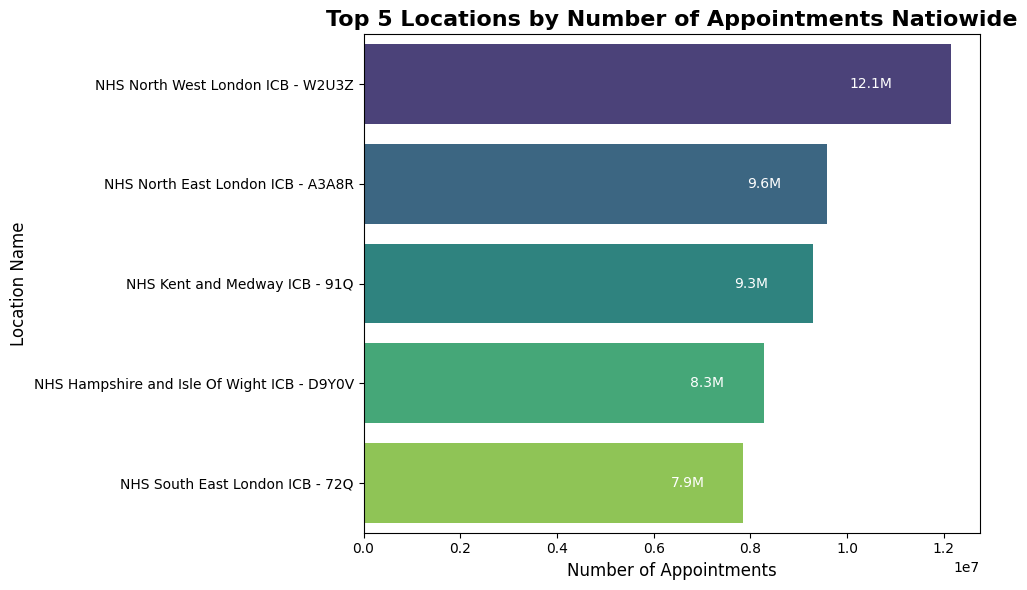

In [72]:
plot_top_locations(data=top_5_locations_nc,
                   x_column='count_of_appointments',
                   y_column='sub_icb_location_name',
                   title='Top 5 Locations by Number of Appointments Natiowide')

#

### 3. Total Appointments over time - general overview 

Create re-usable function that plots total monthly appointments over time.

Parameters:
- data (DataFrame): The dataset to analyse.
- date_column (str): The column name for appointment dates or months.
- count_column (str): The column name for the count of appointments.
- title (str): The title of the plot.
- color (str): The color of the line.

In [73]:
def plot_monthly_appointments(data, date_column, count_column, title, color='b'):
   
    # Convert PeriodDtype to Timestamp before ensuring datetime format
    if isinstance(data[date_column].dtype, pd.PeriodDtype):
        data[date_column] = data[date_column].dt.to_timestamp()

    # Ensure date column is in datetime format
    data[date_column] = pd.to_datetime(data[date_column])

    # Aggregate the data by month
    monthly_data = data.groupby(data[date_column].dt.to_period("M"))[count_column].sum().reset_index()

    # Convert PeriodDtype to TimestampDtype again to avoid plotting errors
    monthly_data[date_column] = monthly_data[date_column].dt.to_timestamp()

    # Plot the aggregated data
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data[date_column], monthly_data[count_column], marker='o', color=color, label=title)
    
    # Formatting
    plt.title(title, fontsize=14)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Total Appointments", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

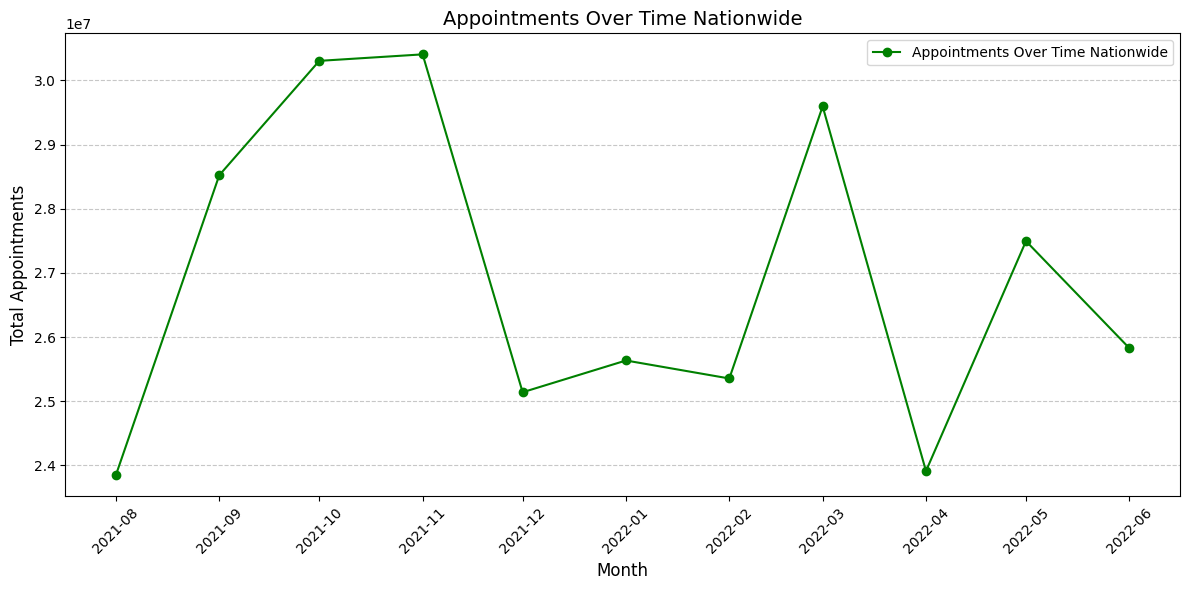

In [74]:
plot_monthly_appointments(data=nc,
                          date_column='appointment_month',
                          count_column='count_of_appointments',
                          title="Appointments Over Time Nationwide",
                          color='g')

#

### 3. Analyse appointments over time by a service setting, context type and national category.

### Boxplot of Appointment Counts by Service Setting

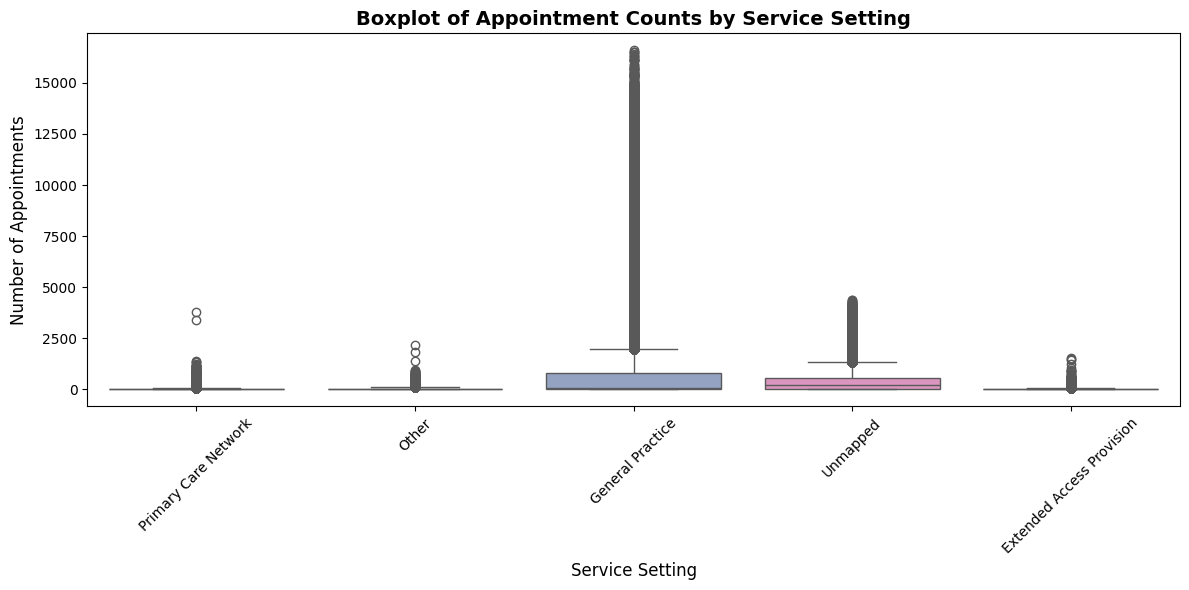

In [75]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=nc, x="service_setting", y="count_of_appointments", palette="Set2")
plt.title("Boxplot of Appointment Counts by Service Setting", fontsize=14, fontweight='bold')
plt.xlabel("Service Setting", fontsize=12)
plt.ylabel("Number of Appointments", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#

### Boxplot of Appointment Counts by Service Setting (Excluding GP Visits)

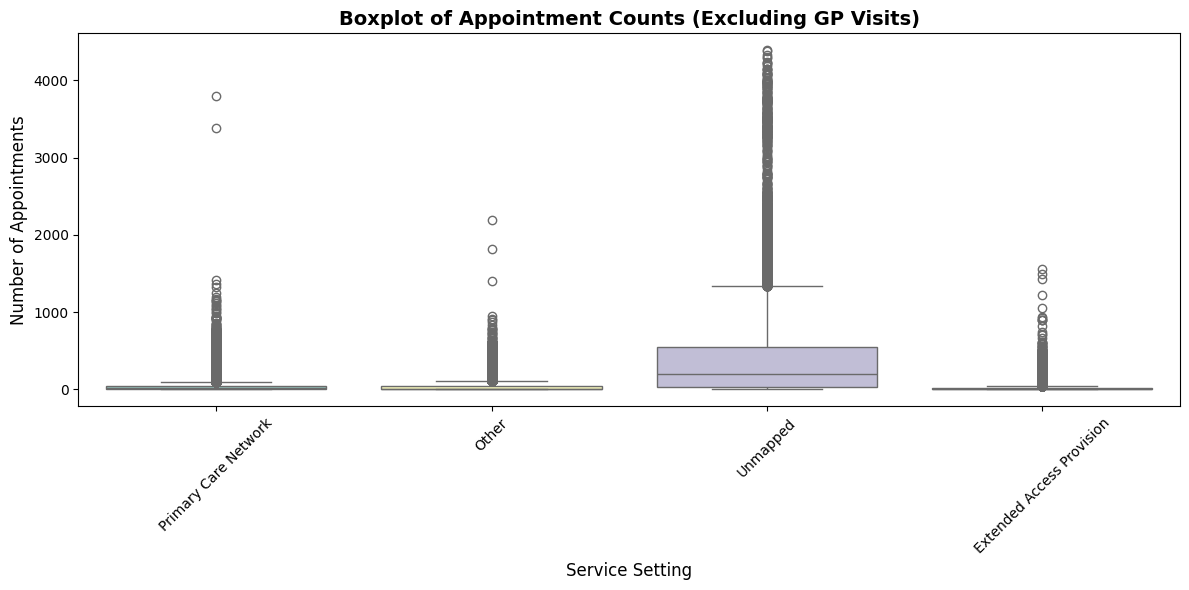

In [76]:
# Exclude GP visits from the data
non_gp_data = nc[nc["service_setting"] != "General Practice"]

# Create a boxplot for the filtered data
plt.figure(figsize=(12, 6))
sns.boxplot(data=non_gp_data, x="service_setting", y="count_of_appointments", palette="Set3")
plt.title("Boxplot of Appointment Counts (Excluding GP Visits)", fontsize=14, fontweight='bold')
plt.xlabel("Service Setting", fontsize=12)
plt.ylabel("Number of Appointments", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#

Create a function to plot a line chart of appointments over time grouped by a specified column.
    
Parameters:
- data: DataFrame containing the data to analyse.
- group_by_column: The column to group appointments by (e.g., 'service_setting').
- title: The title of the plot (e.g., 'Appointments Over Time by Service Setting').

In [77]:
def plot_appointments_over_time(data, group_by_column, title):
   
    # Group by appointment_month and the specified column to calculate total appointments
    grouped_data = (data.groupby(['appointment_month', group_by_column])['count_of_appointments']
                    .sum()
                    .reset_index())
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped_data,
                 x='appointment_month',
                 y='count_of_appointments',
                 hue=group_by_column,
                 marker='o')
    
    # Customise the plot
    plt.title(title, fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Total Appointments', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title=group_by_column.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#

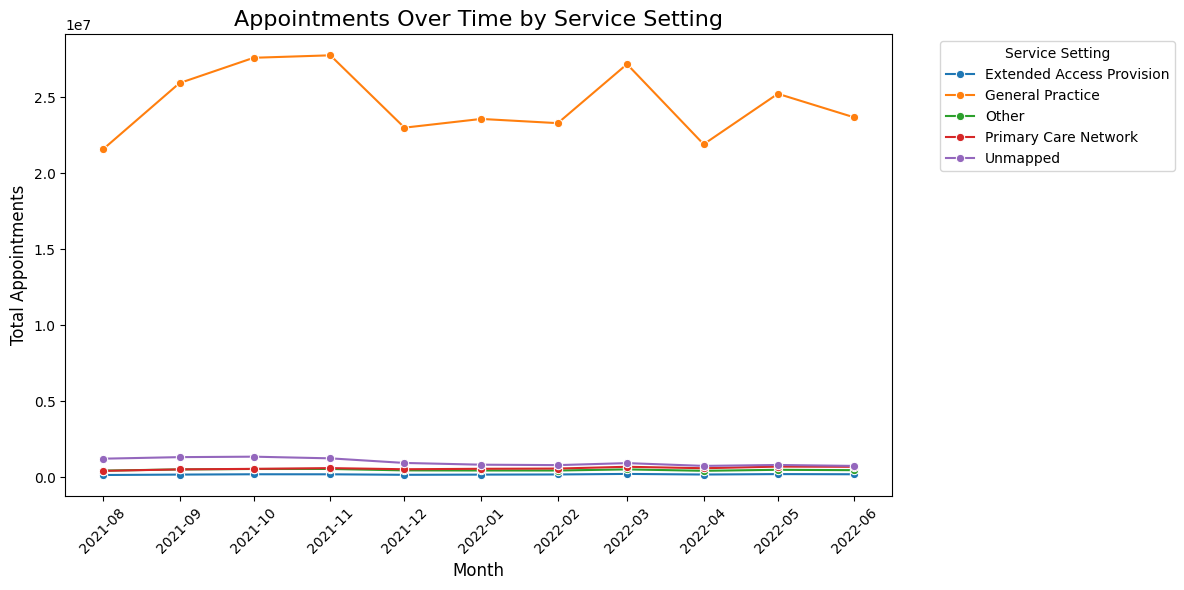

In [78]:
# Appointments by service setting 
plot_appointments_over_time(data=nc,
                            group_by_column='service_setting',
                            title='Appointments Over Time by Service Setting')

#

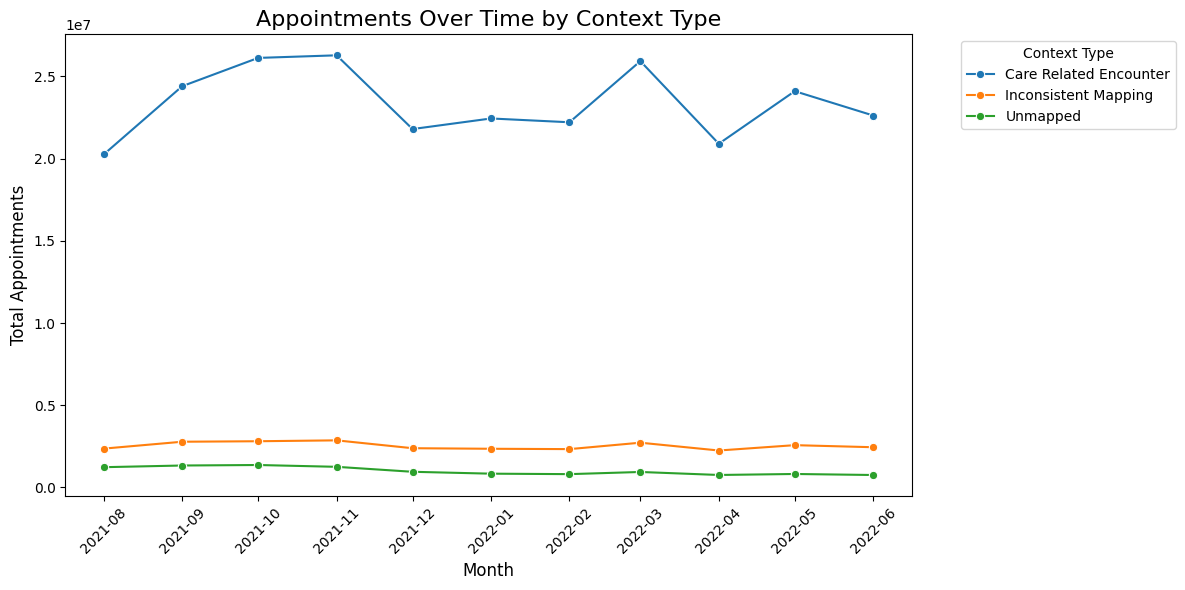

In [79]:
# Appointments by Context Type
plot_appointments_over_time(data=nc,
                            group_by_column='context_type',
                            title='Appointments Over Time by Context Type')

#

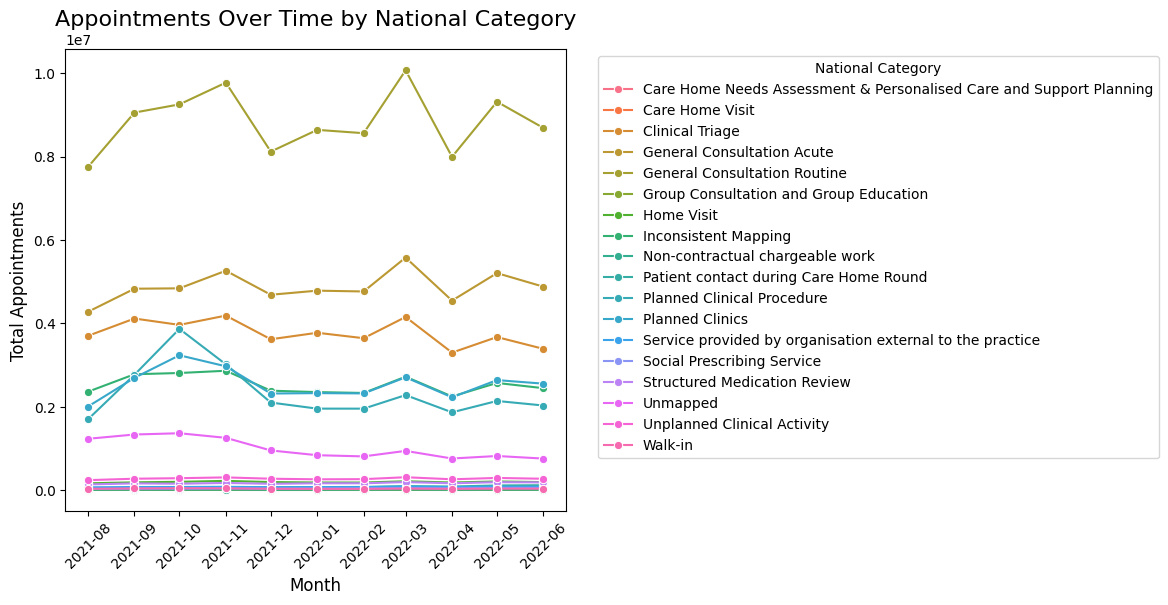

In [80]:
# Appointments by National Category
plot_appointments_over_time(data=nc,
                            group_by_column='national_category',
                            title='Appointments Over Time by National Category')

#

### 3. Analyse appointment distribution by national category and service setting.

In [81]:
# Create the pivot table
pivot_table = nc.pivot_table(index='national_category',
                             columns='service_setting',
                             values='count_of_appointments',
                             aggfunc='sum',
                             fill_value=0)

# Add a Total column for overall appointments per National Category
pivot_table['Total'] = pivot_table.sum(axis=1)

# Sort the table by the Total column in descending order
pivot_table = pivot_table.sort_values(by='Total', ascending=False)

pivot_table

service_setting                                     Extended Access Provision  \
national_category                                                               
General Consultation Routine                                           399182   
General Consultation Acute                                             413066   
Clinical Triage                                                        382876   
Planned Clinics                                                        261418   
Inconsistent Mapping                                                   438355   
Planned Clinical Procedure                                             173016   
Unmapped                                                                    0   
Unplanned Clinical Activity                                             37358   
Home Visit                                                               5071   
Structured Medication Review                                             5816   
Service provided by organisation external to th...                      29143   
Patient contact during Care Home Round                                   3209   
Care Home Visit                                                          8328   
Social Prescribing Service                                               6252   
Walk-in                                                                  8441   
Care Home Needs Assessment & Personalised Care ...                       2798   
Non-contractual chargeable work                                          1830   
Group Consultation and Group Education                                    648   

service_setting                                     General Practice    Other  \
national_category                                                               
General Consultation Routine                                93358462  1377569   
General Consultation Acute                                  52059940   606115   
Clinical Triage                                             40246576   575083   
Planned Clinics                                             26376358   515480   
Inconsistent Mapping                                        24997475  1642532   
Planned Clinical Procedure                                  24986338   302533   
Unmapped                                                           0        0   
Unplanned Clinical Activity                                  2872873    51300   
Home Visit                                                   2040497    30832   
Structured Medication Review                                 1312506    32417   
Service provided by organisation external to th...            469974   178579   
Patient contact during Care Home Round                        517649    18581   
Care Home Visit                                               536382    19764   
Social Prescribing Service                                    181371     8501   
Walk-in                                                       363566    34583   
Care Home Needs Assessment & Personalised Care ...            316586     8773   
Non-contractual chargeable work                               116053    17196   
Group Consultation and Group Education                         59085      238   

service_setting                                     Primary Care Network  \
national_category                                                          
General Consultation Routine                                     2136309   
General Consultation Acute                                        612029   
Clinical Triage                                                   342429   
Planned Clinics                                                   866492   
Inconsistent Mapping                                              812440   
Planned Clinical Procedure                                        240807   
Unmapped                                                               0   
Unplanned Clinical Activity                                        94263  

#

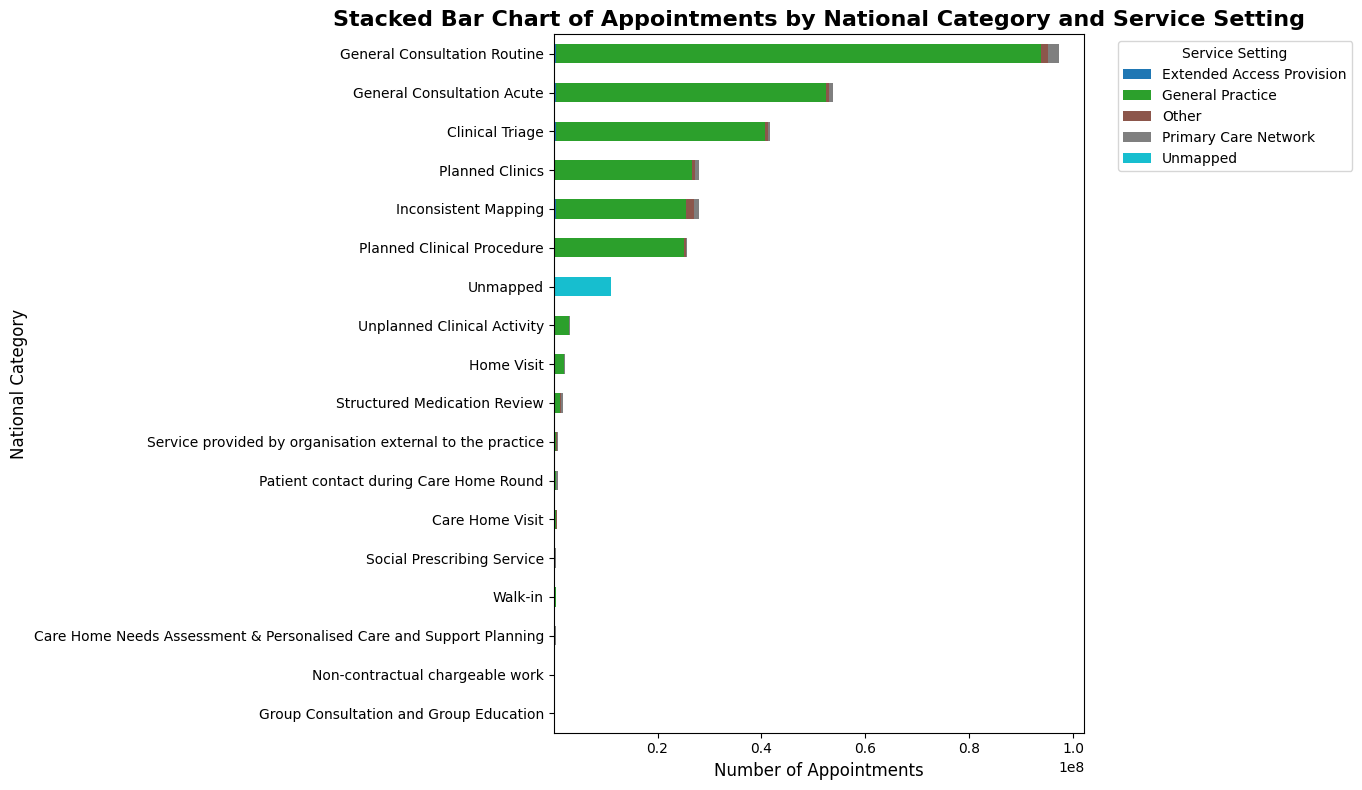

In [82]:
# Remove the 'Total' column from the pivot table
pivot_table_no_total = pivot_table.drop(columns=['Total'])

# Reverse the order of the rows in the pivot table
pivot_table_no_total_reversed = pivot_table_no_total.iloc[::-1]

# Plot the stacked bar chart
pivot_table_no_total_reversed.plot(kind='barh',
                                   stacked=True,
                                   figsize=(14, 8),
                                   cmap='tab10')

# Customise the plot
plt.title("Stacked Bar Chart of Appointments by National Category and Service Setting", fontsize=16, fontweight='bold')
plt.xlabel("Number of Appointments", fontsize=12)
plt.ylabel("National Category", fontsize=12)
plt.legend(title="Service Setting", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

#

### Appointments by Service Setting on a Monthly Basis

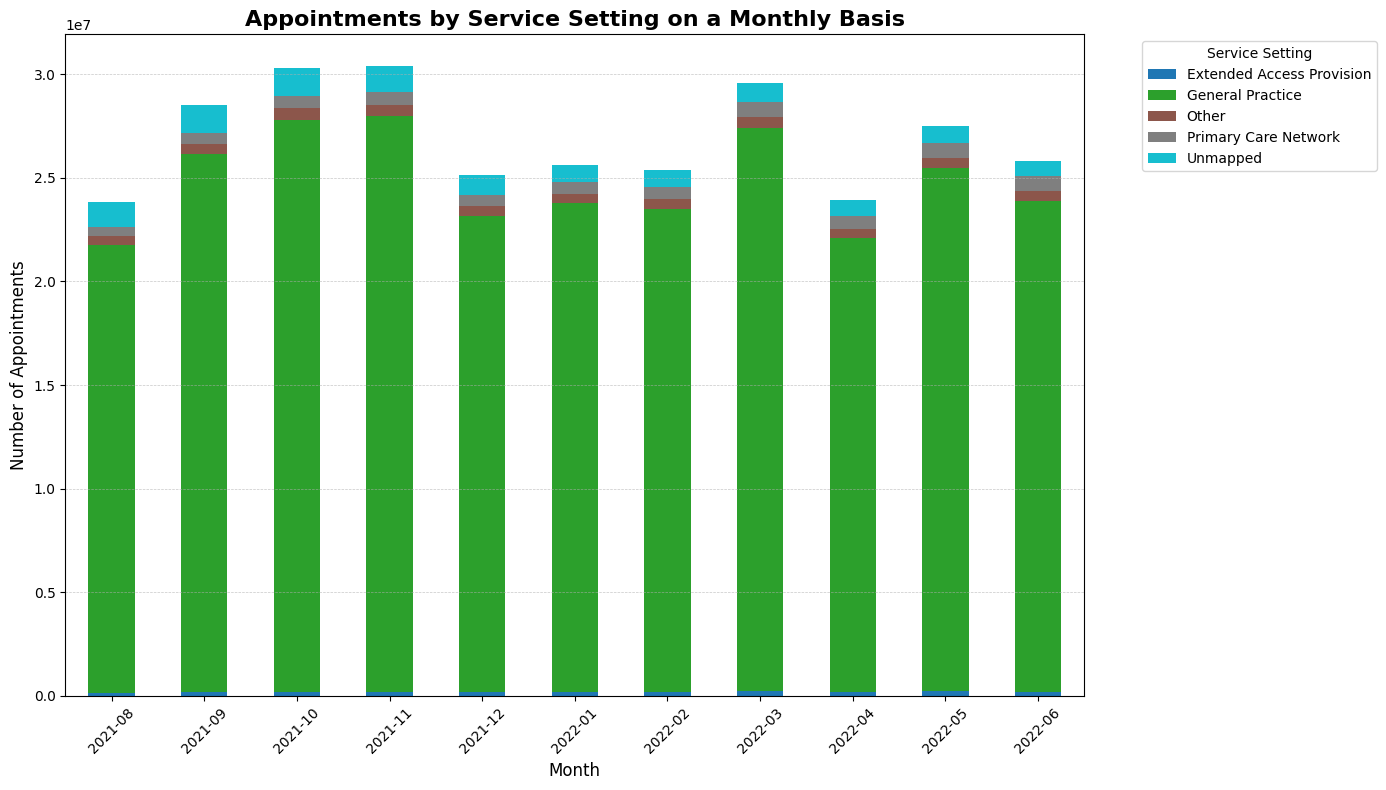

In [83]:
# Format the appointment_month column to remove the time
nc['appointment_month'] = pd.to_datetime(nc['appointment_month']).dt.strftime('%Y-%m')

# Create a pivot table for monthly analysis
pivot_table_monthly = nc.pivot_table(index='appointment_month',
                                     columns='service_setting',
                                     values='count_of_appointments',
                                     aggfunc='sum',
                                     fill_value=0)

# Plot stacked bar chart
pivot_table_monthly.plot(kind='bar',
                         stacked=True,
                         figsize=(14, 8),
                         cmap='tab10')

# Customise the plot
plt.title("Appointments by Service Setting on a Monthly Basis", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Appointments", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Service Setting", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

#

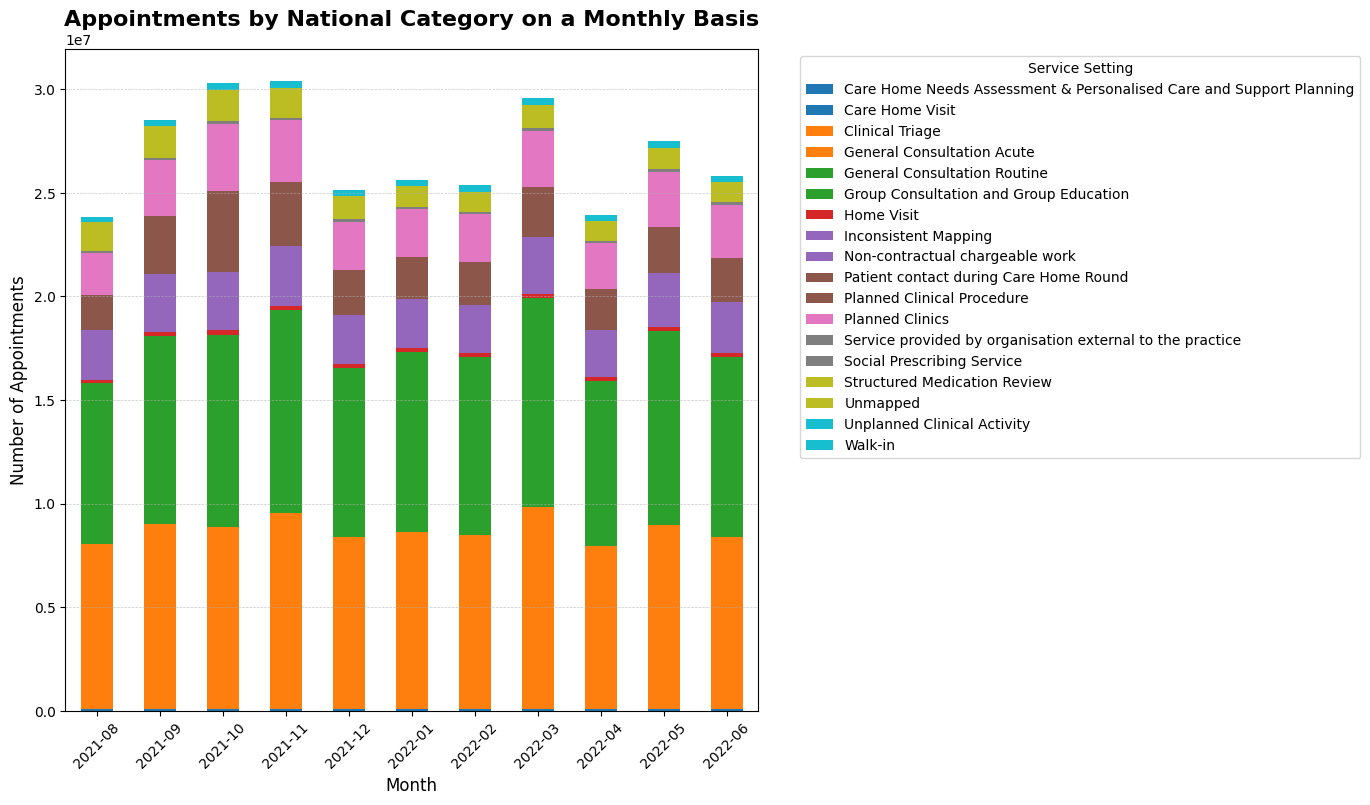

In [84]:
# Format the appointment_month column to remove the time
nc['appointment_month'] = pd.to_datetime(nc['appointment_month']).dt.strftime('%Y-%m')

# Create a pivot table for monthly analysis
pivot_table_monthly = nc.pivot_table(index='appointment_month',
                                     columns='national_category',
                                     values='count_of_appointments',
                                     aggfunc='sum',
                                     fill_value=0)

# Plot stacked bar chart
pivot_table_monthly.plot(kind='bar',
                         stacked=True,
                         figsize=(14, 8),
                         cmap='tab10')

# Customise the plot
plt.title("Appointments by National Category on a Monthly Basis", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Appointments", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Service Setting", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

##

### 3. What percentage of appointments fall under "Inconsistent Mapping" and "Unmapped"?

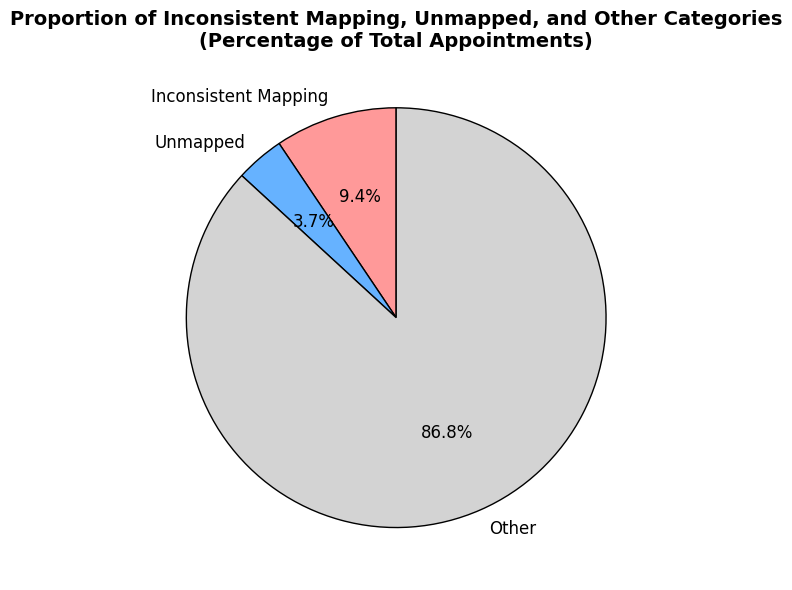

In [85]:
# Calculate total appointments for each category
total_appointments = nc['count_of_appointments'].sum()

# Calculate appointments for "Inconsistent Mapping" and "Unmapped"
data_quality = nc[nc['national_category'].isin(['Inconsistent Mapping', 'Unmapped'])]
quality_proportion = (data_quality.groupby('national_category')['count_of_appointments'].sum()
    / total_appointments * 100)

# Calculate the remaining percentage for "Other" categories
other_percentage = 100 - quality_proportion.sum()

# Combine the proportions into a single series
final_proportions = pd.concat([quality_proportion, pd.Series({'Other': other_percentage})])

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(final_proportions,
        labels=final_proportions.index,
        autopct='%.1f%%',
        startangle=90,
        colors=['#FF9999', '#66B2FF', '#D3D3D3'],
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 12})

plt.title("Proportion of Inconsistent Mapping, Unmapped, and Other Categories\n(Percentage of Total Appointments)",
          fontsize=14,
          fontweight='bold')

# Display the pie chart
plt.tight_layout()
plt.show()

#

### 4. Analyse location differences in national category

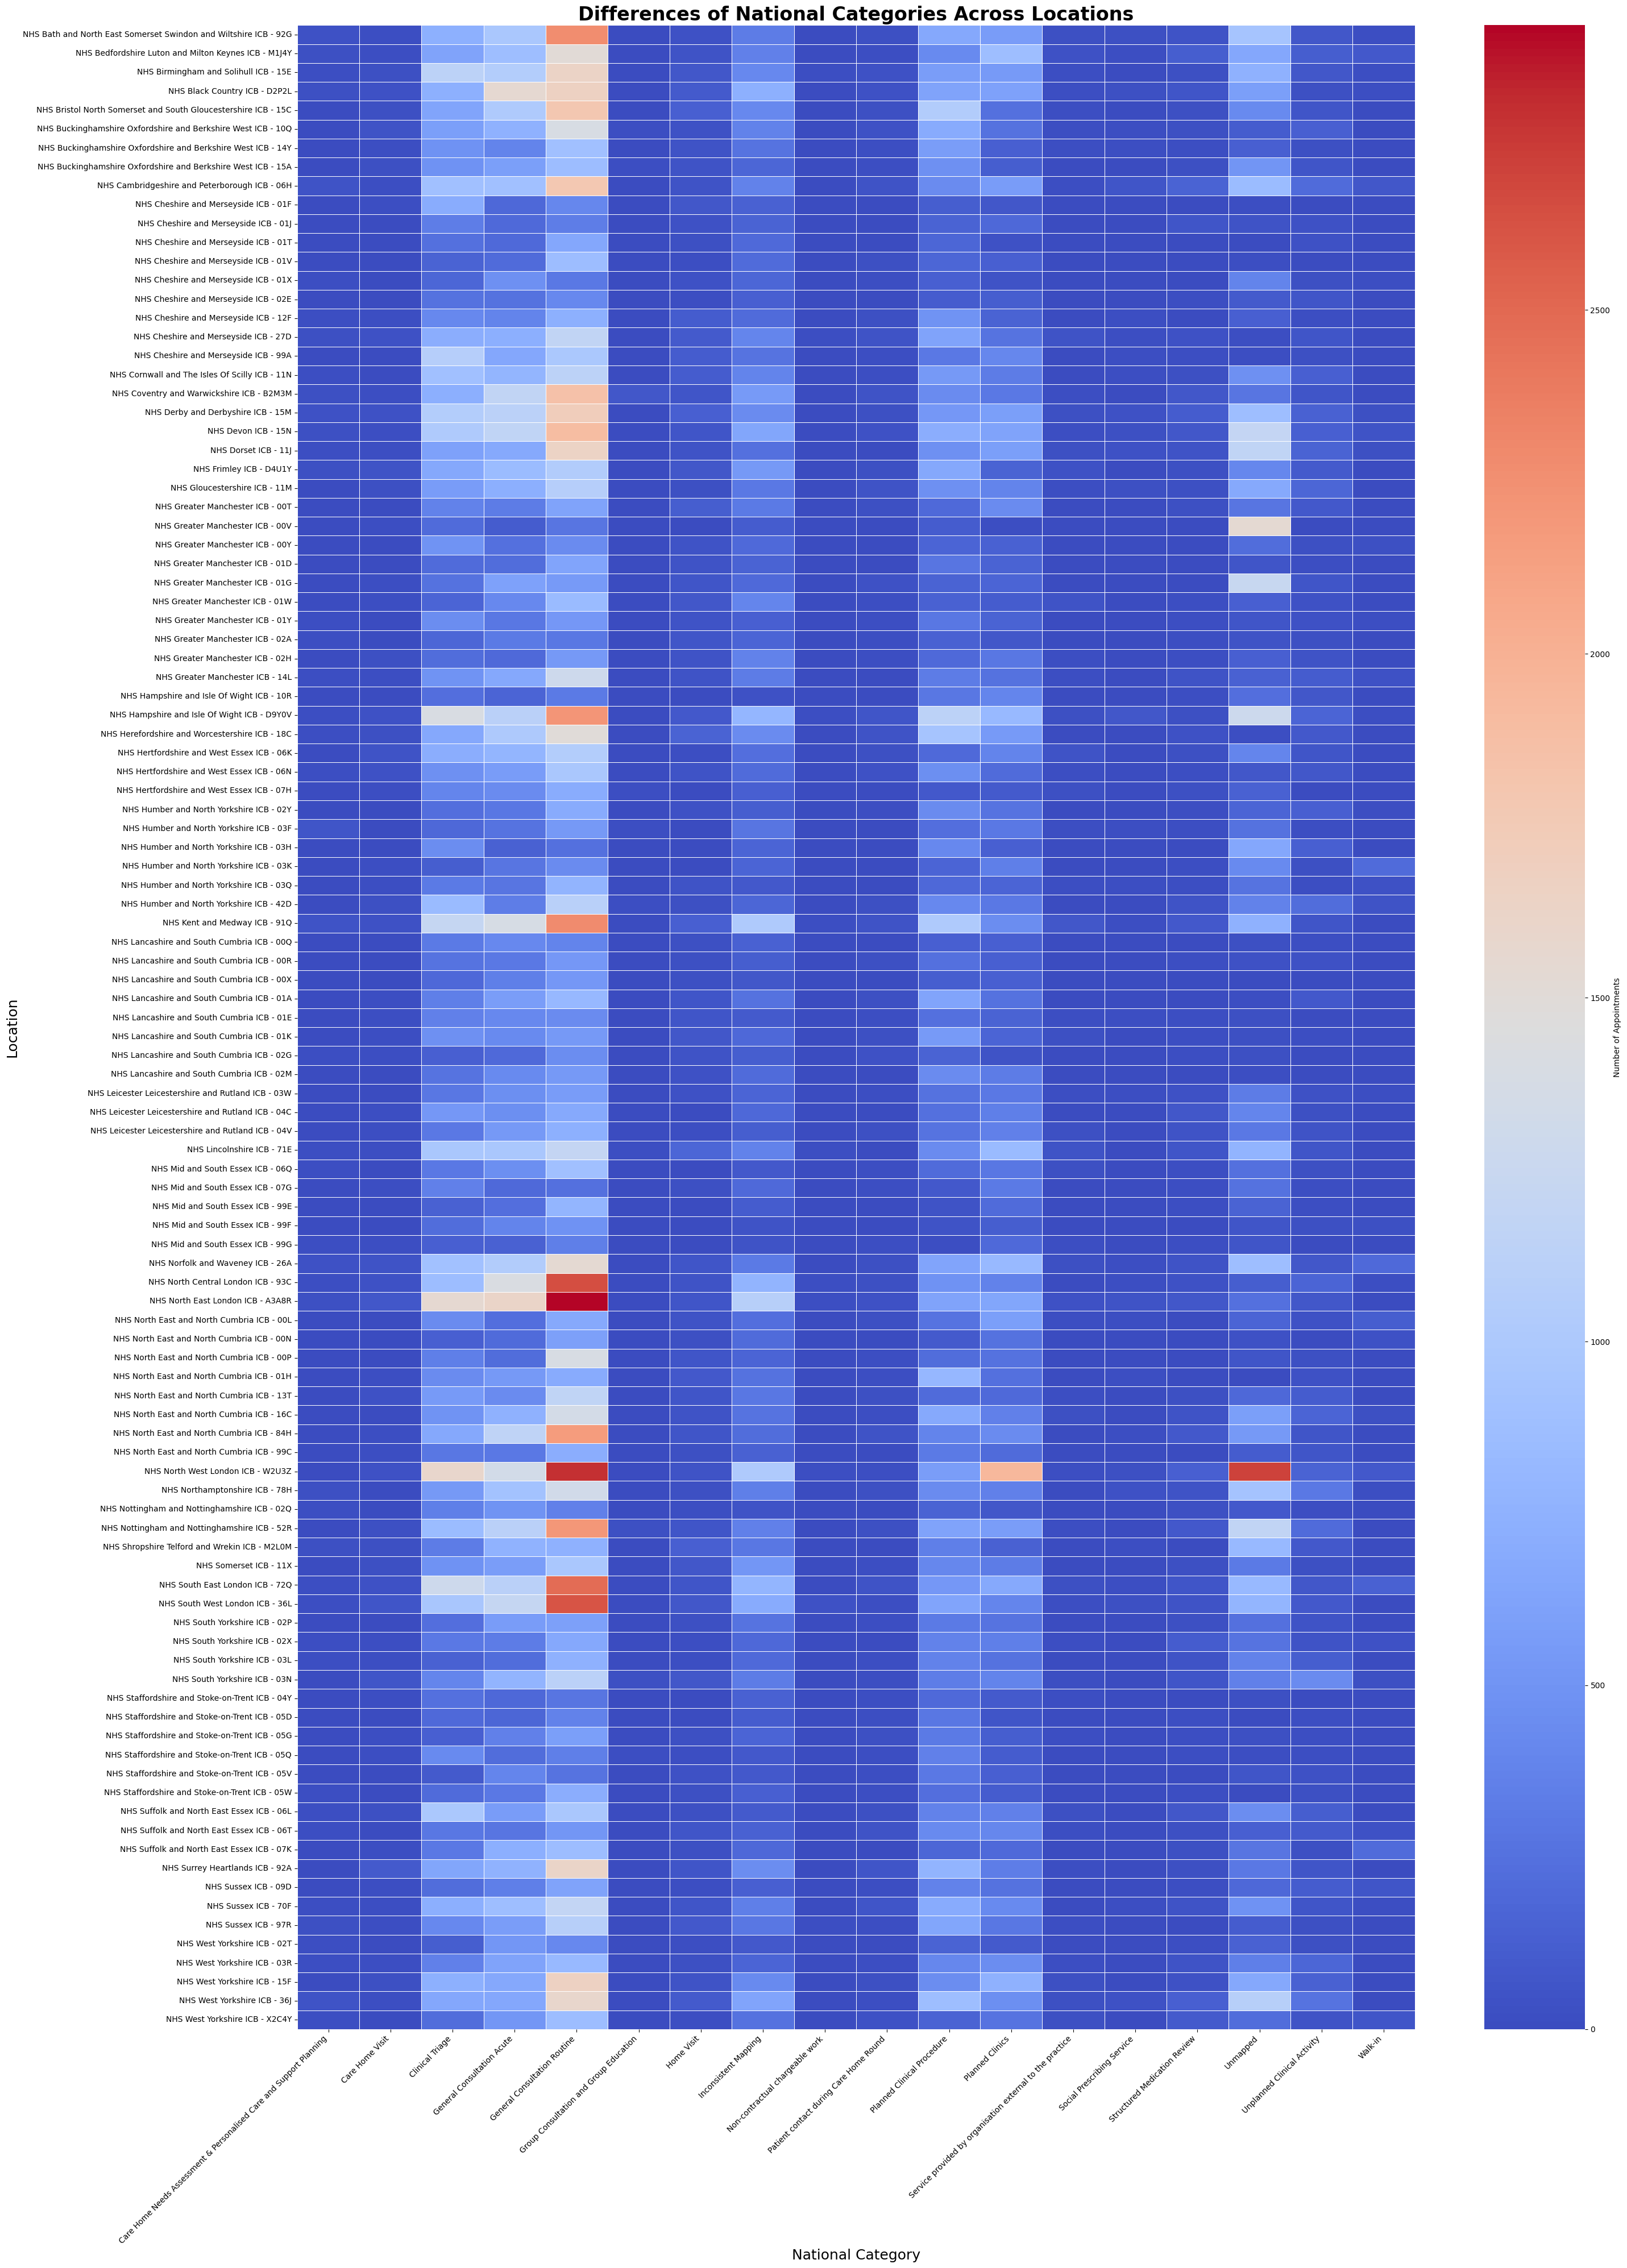

In [86]:
# Group the data 
heatmap_data = nc.pivot_table(index='sub_icb_location_name',
                              columns='national_category',
                              values='count_of_appointments').fillna(0)

# Create the heatmap
plt.figure(figsize=(30, 40))  
sns.heatmap(heatmap_data,
            cmap='coolwarm', 
            annot=False,
            fmt='.0f',
            linewidths=0.5,
            cbar_kws={'label': 'Number of Appointments'})

# Customise the chart
plt.title("Differences of National Categories Across Locations", fontsize=24, fontweight='bold')
plt.xlabel("National Category", fontsize=18)
plt.ylabel("Location", fontsize=18)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

# Show the heatmap
plt.show()

#

### Stacked Bar Chart for Most Active Regions Per Category (Explanatory Analysis for StakeHolder)

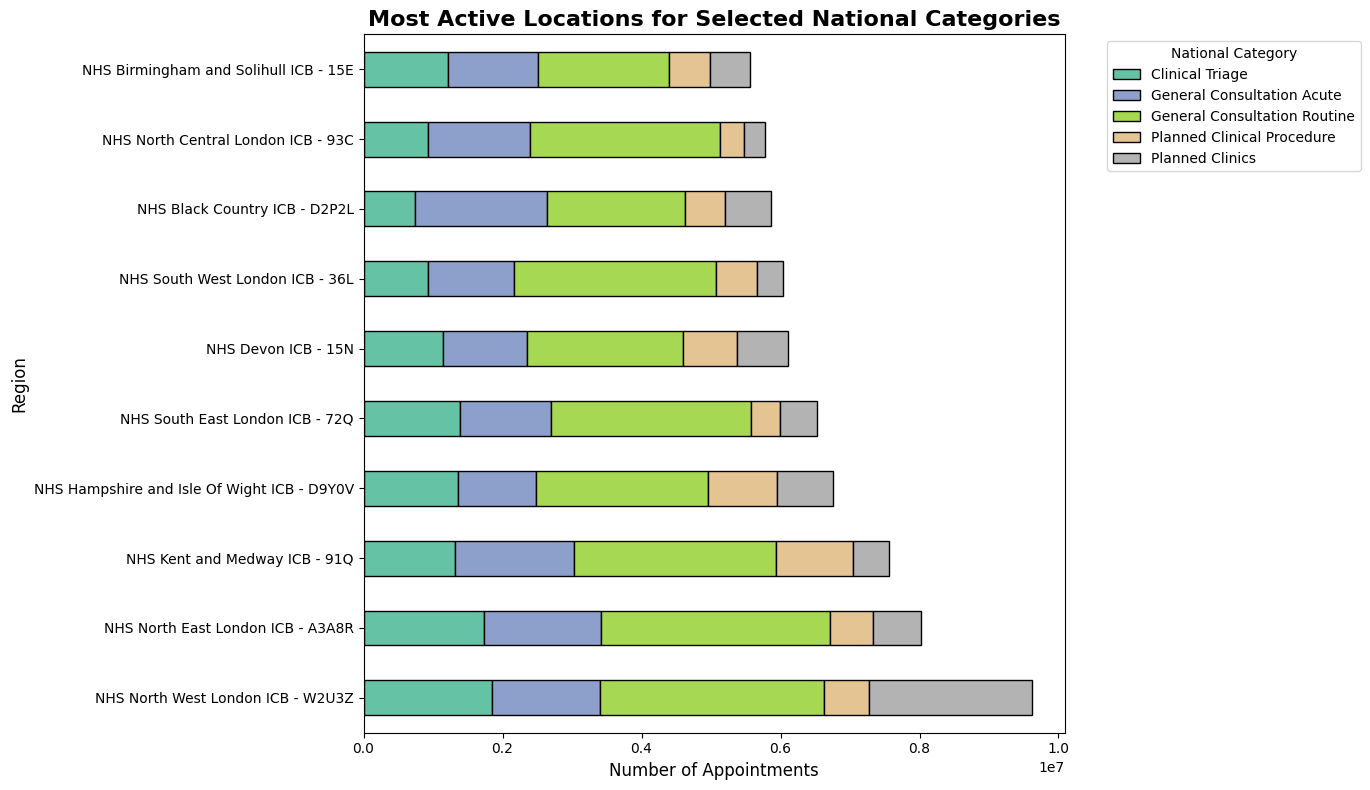

In [87]:
# Filter data for specific categories
specific_categories = ["Clinical Triage", 
                       "General Consultation Acute", 
                       "General Consultation Routine", 
                       "Planned Clinical Procedure", 
                       "Planned Clinics"]

filtered_data = nc[nc["national_category"].isin(specific_categories)]

# Group by region and category to calculate total appointments
category_region_summary = (filtered_data.groupby(["sub_icb_location_name", "national_category"])["count_of_appointments"]
                           .sum()
                           .reset_index())

# Pivot the data for stacked bar chart
stacked_data = category_region_summary.pivot(index="sub_icb_location_name",
                                             columns="national_category",
                                             values="count_of_appointments").fillna(0)

# Sort by total appointments to focus on most active regions
stacked_data["Total"] = stacked_data.sum(axis=1)
stacked_data = stacked_data.sort_values(by="Total", ascending=False).head(10).drop(columns=["Total"])

# Plot the stacked bar chart
stacked_data.plot(kind="barh",
                  stacked=True,
                  figsize=(14, 8),
                  cmap="Set2",
                  edgecolor="black")

# Add chart title and labels
plt.title("Most Active Locations for Selected National Categories", fontsize=16, fontweight="bold")
plt.xlabel("Number of Appointments", fontsize=12)
plt.ylabel("Region", fontsize=12)
plt.legend(title="National Category", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

#

### Drilled Down Analysis: Most Active Regions for "Unmapped" and "Inconsistent Mapping"

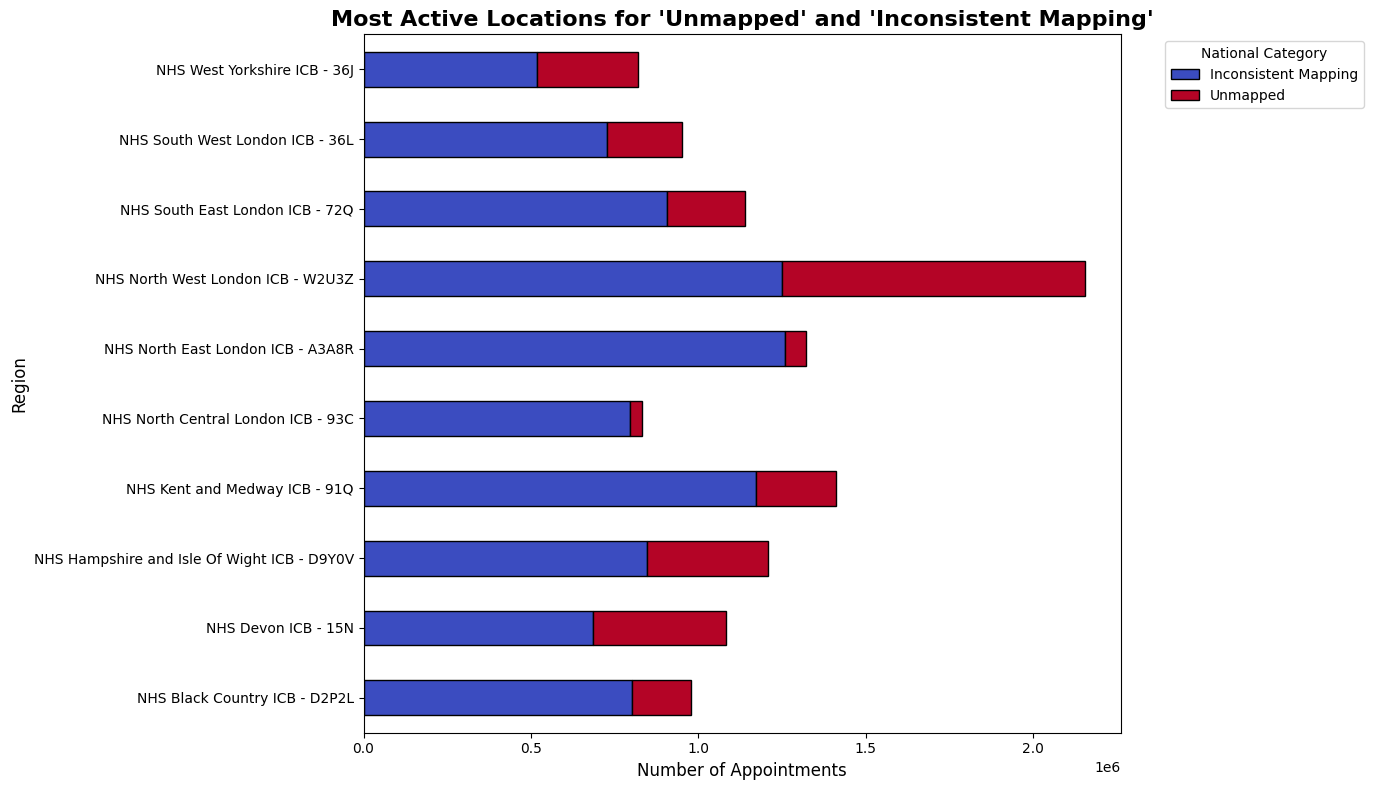

In [88]:
# Filter data for "Unmapped" and "Inconsistent Mapping"
drilldown_categories = ["Unmapped", "Inconsistent Mapping"]
drilldown_data = nc[nc["national_category"].isin(drilldown_categories)]

# Group by region and category to calculate total appointments
drilldown_summary = (drilldown_data.groupby(["sub_icb_location_name", "national_category"])["count_of_appointments"]
                     .sum()
                     .reset_index())

# Identify the most active regions based on total appointments
most_active_regions = (drilldown_summary.groupby("sub_icb_location_name")["count_of_appointments"]
                       .sum()
                       .sort_values(ascending=False)
                       .head(10)  # Select top 10 most active regions
                       .index)

# Filter data to include only most active regions
filtered_drilldown_data = drilldown_summary[drilldown_summary["sub_icb_location_name"].isin(most_active_regions)]

# Pivot the data for stacked bar chart
stacked_drilldown_data = filtered_drilldown_data.pivot(index="sub_icb_location_name",
                                                       columns="national_category",
                                                       values="count_of_appointments").fillna(0)

# Plot the stacked bar chart
stacked_drilldown_data.plot(kind="barh",
                            stacked=True,
                            figsize=(14, 8),
                            cmap="coolwarm",
                            edgecolor="black")

# Add chart title and labels
plt.title("Most Active Locations for 'Unmapped' and 'Inconsistent Mapping'", fontsize=16, fontweight="bold")
plt.xlabel("Number of Appointments", fontsize=12)
plt.ylabel("Region", fontsize=12)
plt.legend(title="National Category", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

#

### 5. Examine how context type relates to national category.

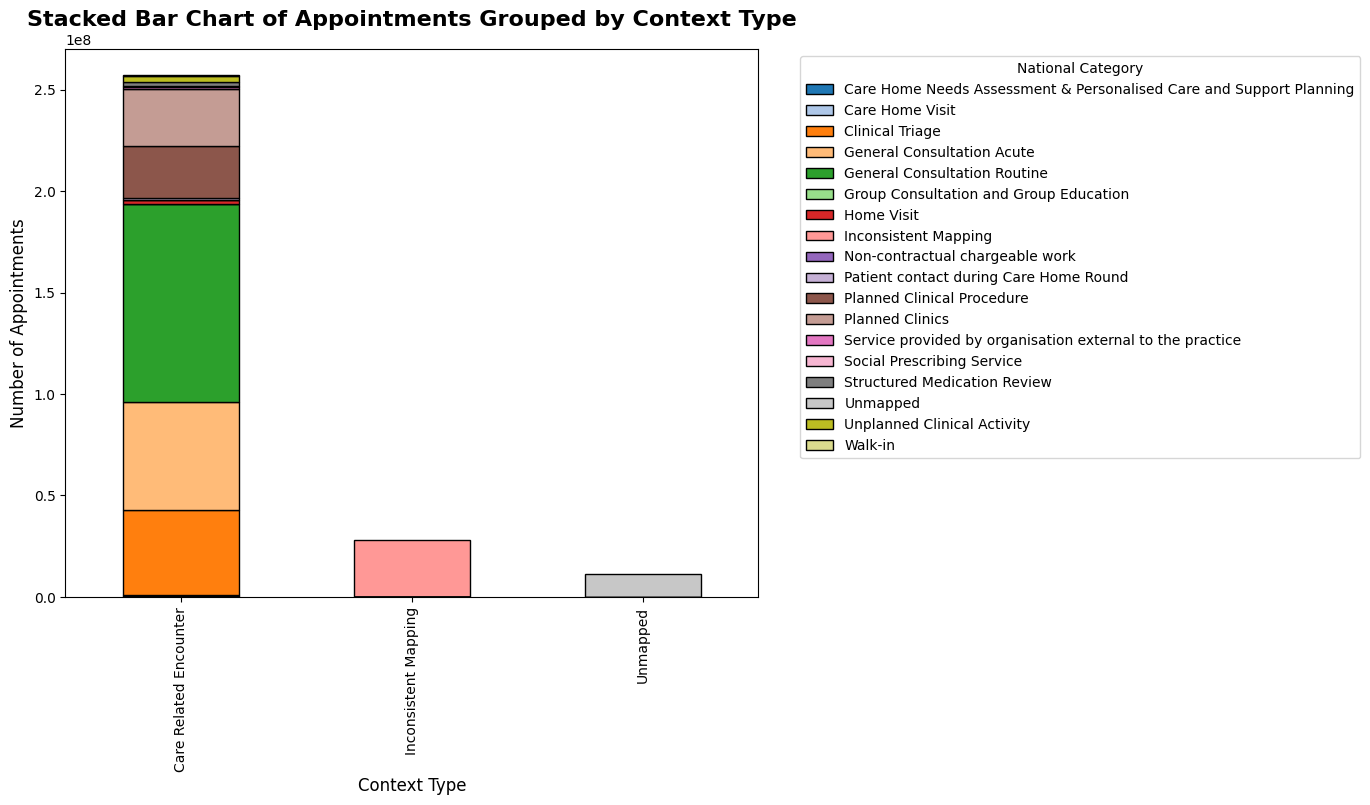

In [89]:
# Prepare data for stacked bar chart
stacked_bar_data = nc.groupby(["context_type", "national_category"])["count_of_appointments"].sum().unstack()

# Plot the stacked bar chart
stacked_bar_data.plot(kind="bar",
                      stacked=True,
                      figsize=(14, 8),
                      color=plt.cm.tab20.colors, 
                      edgecolor="black")

plt.title("Stacked Bar Chart of Appointments Grouped by Context Type", fontsize=16, fontweight="bold")
plt.xlabel("Context Type", fontsize=12)
plt.ylabel("Number of Appointments", fontsize=12)
plt.legend(title="National Category", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

#####

---

#####

# Exploratory Data Analysis

<h1 style="text-align: center;">Appointments Regional File</h1>

### Objectives: 

- Genereal exploration
- What are the five locations with the highest number of appointments?
- Identify monthly trends in appointment counts accross regions
- How do appointment modes vary across regions?

###

### 1. General exploration 

In [90]:
# Count and view unique appointment_status in ar
count_unique_values(ar, 'appointment_status')
get_unique_values(ar, 'appointment_status')

Total unique values in 'appointment_status': 3
Unique values in 'appointment_status': ['Attended', 'DNA', 'Unknown']


#####

In [91]:
# Count and view unique hcp_type in ar
count_unique_values(ar, 'hcp_type')
get_unique_values(ar, 'hcp_type')

Total unique values in 'hcp_type': 3
Unique values in 'hcp_type': ['GP', 'Other Practice staff', 'Unknown']


#####

In [92]:
# Count and view unique appointment_mode in ar
count_unique_values(ar, 'appointment_mode')
get_unique_values(ar, 'appointment_mode')

Total unique values in 'appointment_mode': 5
Unique values in 'appointment_mode': ['Face-to-Face', 'Home Visit', 'Telephone', 'Unknown', 'Video/Online']


#####

In [93]:
# Count and view unique time_between_book_and_appointment in ar
count_unique_values(ar, 'time_between_book_and_appointment')
get_unique_values(ar, 'time_between_book_and_appointment')

Total unique values in 'time_between_book_and_appointment': 8
Unique values in 'time_between_book_and_appointment': ['1 Day', '15  to 21 Days', '2 to 7 Days', '22  to 28 Days', '8  to 14 Days', 'More than 28 Days', 'Same Day', 'Unknown / Data Quality']


#

### 2. What are the TOP 5 locations with the highest number of appointments?

In [94]:
# Group by location and calculate the total number of appointments
top_5_locations_ar = (ar.groupby('location_name')['count_of_appointments']
                   .sum()
                   .sort_values(ascending=False)
                   .head(5))

top_5_locations_ar

location_name
NHS North East and North Cumbria ICB - 99C    43054121
NHS West Yorkshire ICB - X2C4Y                36075020
NHS Greater Manchester ICB - 14L              34003953
NHS Cheshire and Merseyside ICB - 99A         33064205
NHS North West London ICB - W2U3Z             29380767
Name: count_of_appointments, dtype: int64

#

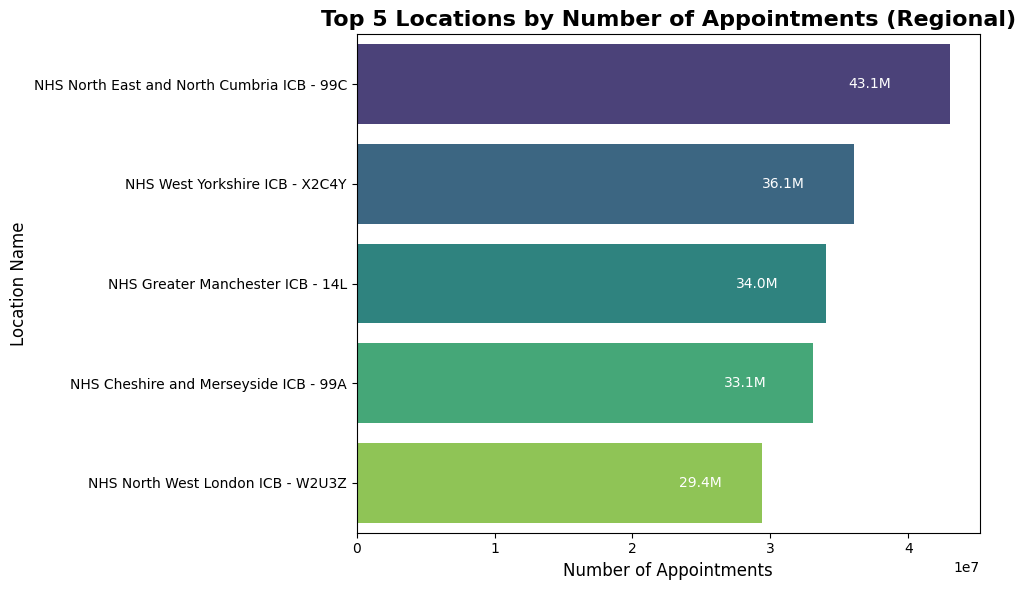

In [95]:
plot_top_locations(data=top_5_locations_ar,
                   x_column='count_of_appointments',
                   y_column='location_name',
                   title='Top 5 Locations by Number of Appointments (Regional)')

#

### 3. Identify monthly trends in appointment counts accross regions

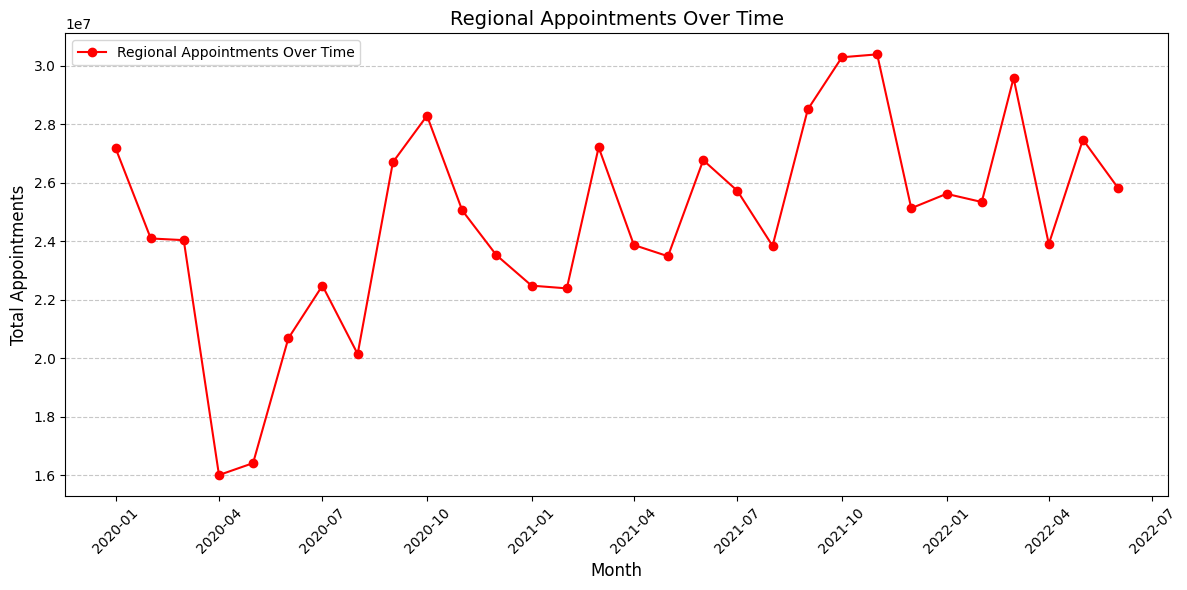

In [96]:
plot_monthly_appointments(data=ar,
                          date_column='appointment_month',
                          count_column='count_of_appointments',
                          title="Regional Appointments Over Time",
                          color='r')

#

### Appointment counts compared to the NHS planning figure (1,200,000 appointments/day).

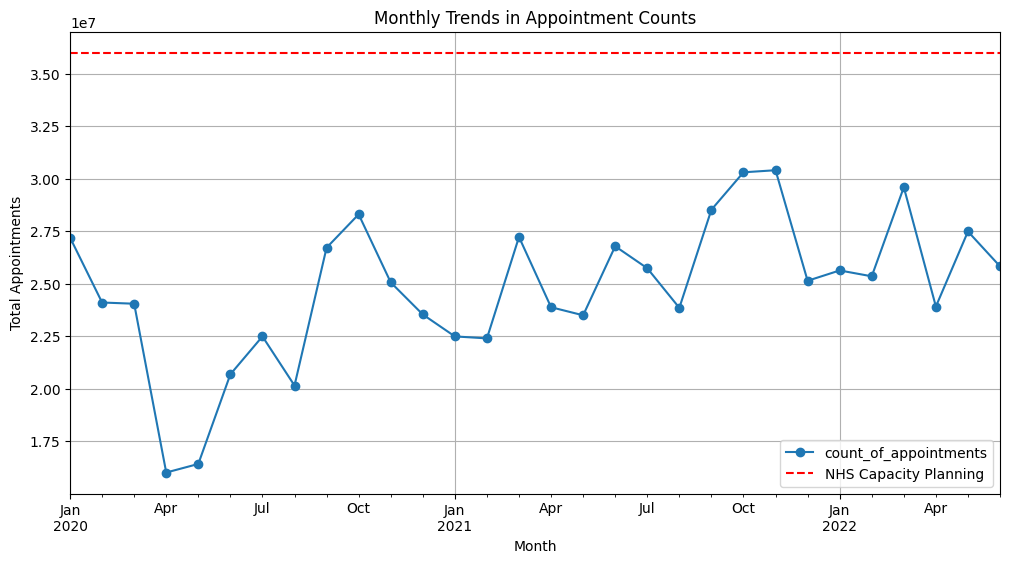

In [97]:
# Group by month and calculate total appointments.
monthly_counts = ar.groupby("appointment_month")["count_of_appointments"].sum()

# Plot the trends.
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind="line", marker="o")
plt.axhline(1_200_000 * 30, color="red", linestyle="--", label="NHS Capacity Planning")
plt.title("Monthly Trends in Appointment Counts")
plt.xlabel("Month")
plt.ylabel("Total Appointments")
plt.legend()
plt.grid()
plt.show()

#

### 4. How do appointment modes vary across regions?

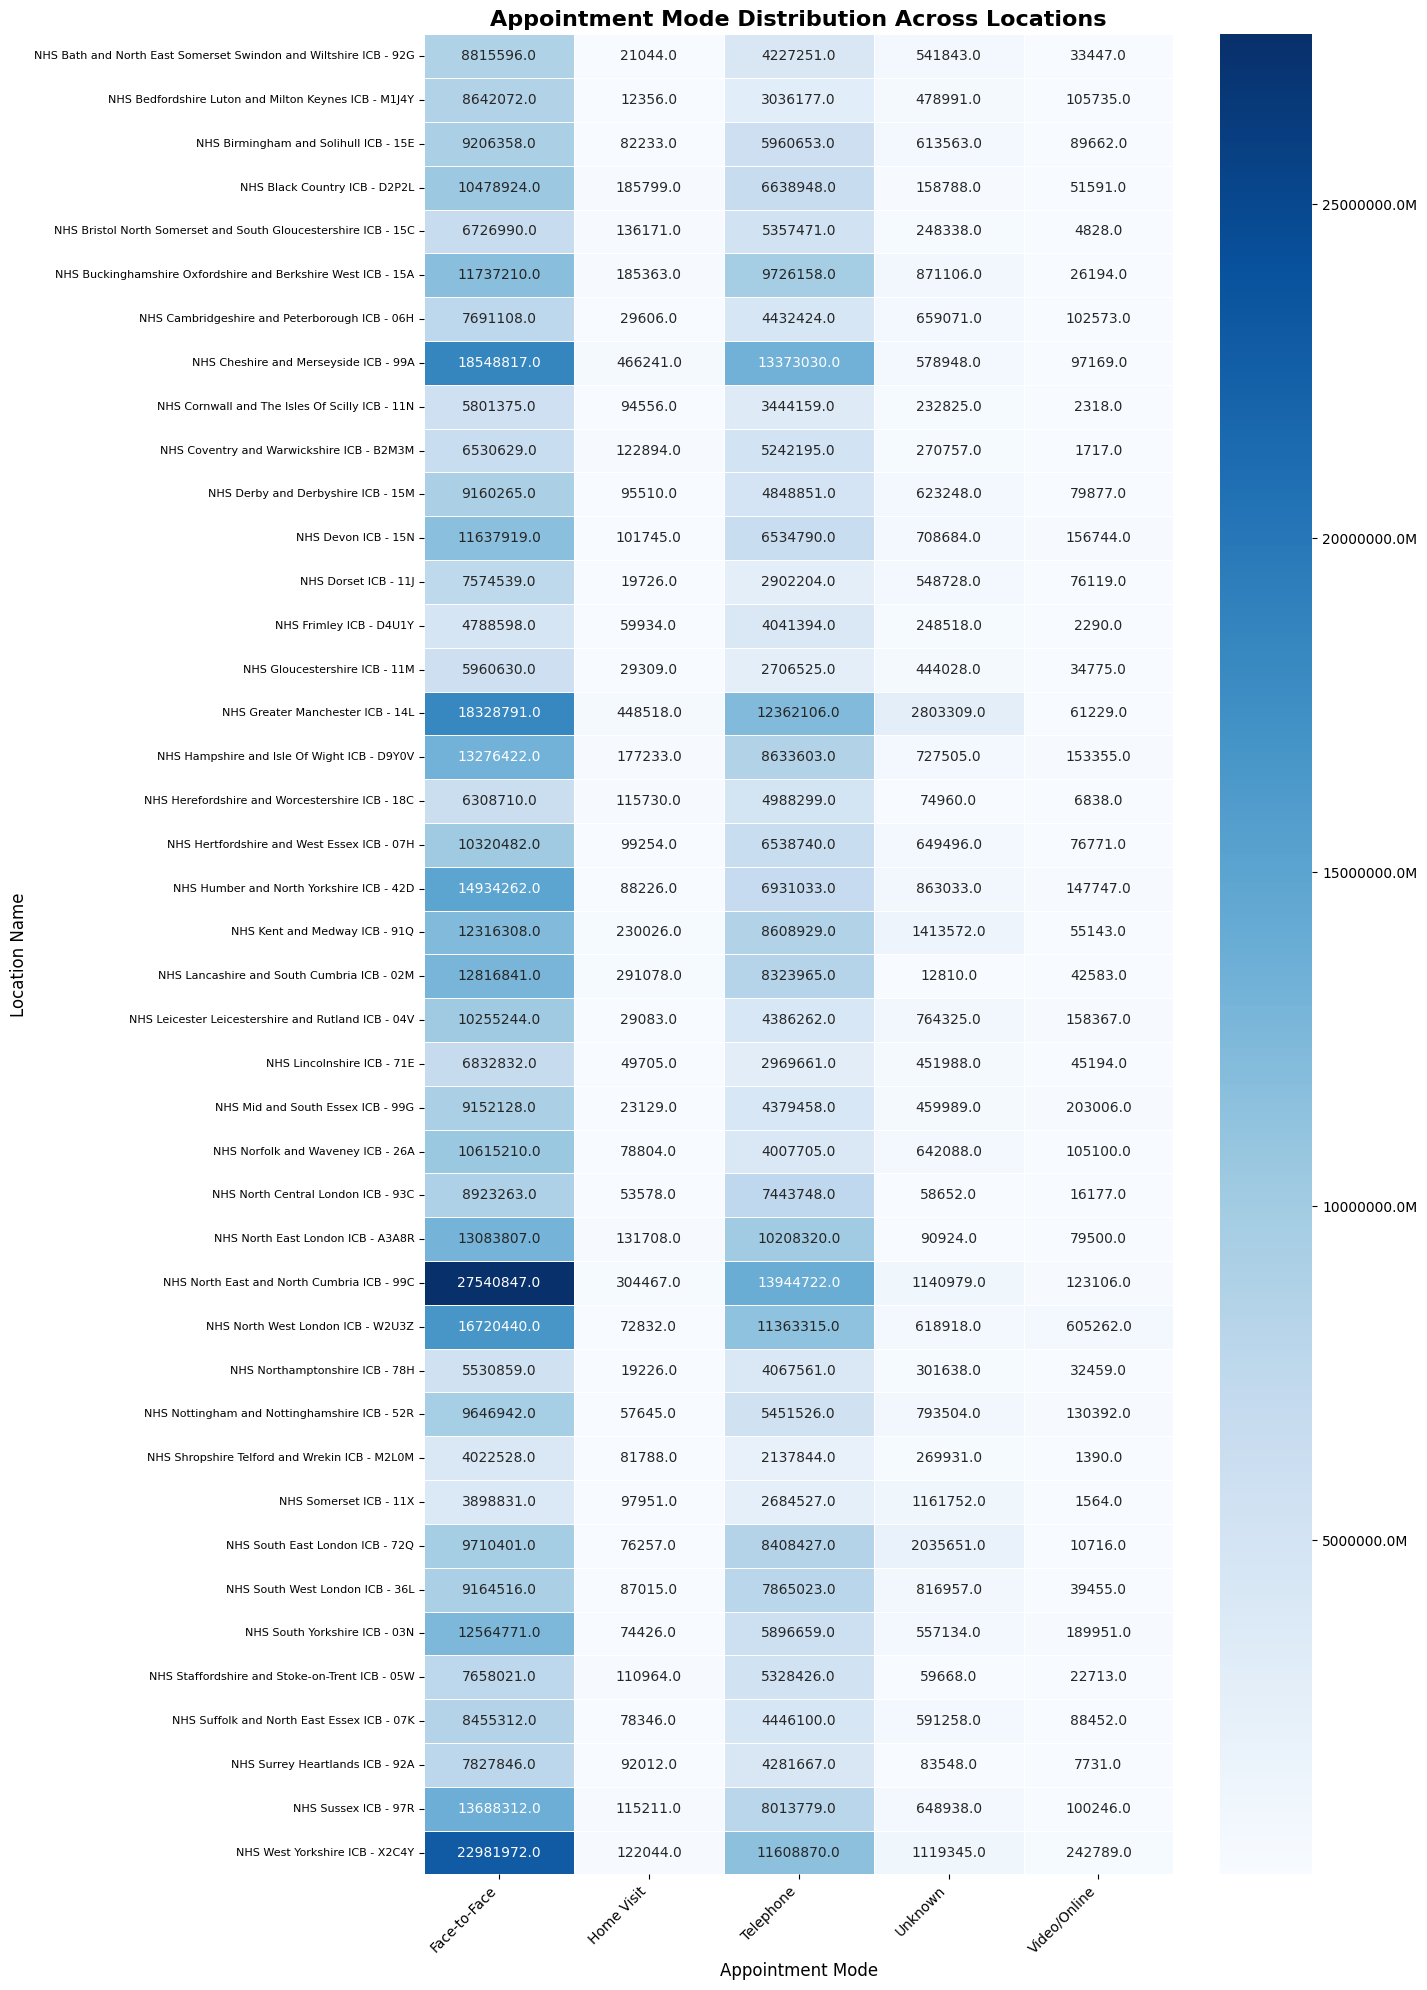

In [98]:
# Create a pivot table for the heatmap
mode_distribution = ar.pivot_table(index='location_name',
                                   columns='appointment_mode',
                                   values='count_of_appointments',
                                   aggfunc='sum',
                                   fill_value=0)

# Plot the heatmap
plt.figure(figsize=(14, 20))
sns.heatmap(mode_distribution,
            cmap='Blues',
            annot=True,
            fmt='.1f',
            cbar_kws={'format': '%.1fM'},
            linewidths=0.5)

# Customise the plot
plt.title("Appointment Mode Distribution Across Locations", fontsize=16, fontweight='bold')
plt.xlabel("Appointment Mode", fontsize=12)
plt.ylabel("Location Name", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

#

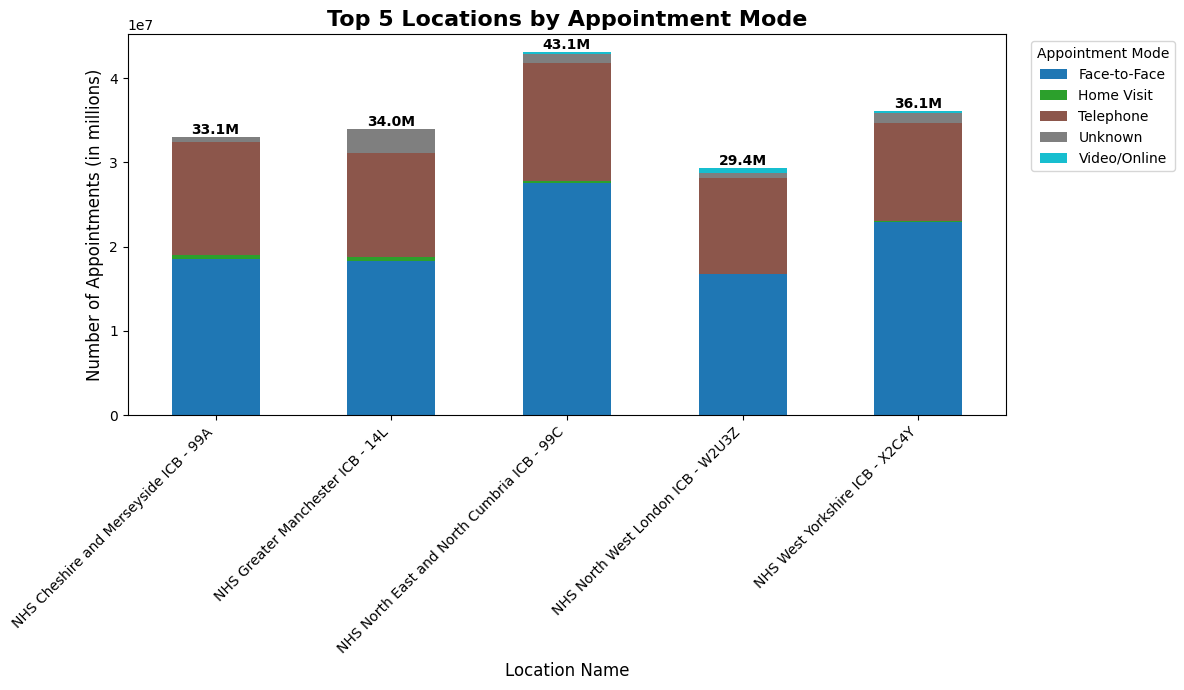

In [99]:
# Filter the data for the top 5 locations
top_5_locations_names = top_5_locations_ar.index
filtered_data = ar[ar['location_name'].isin(top_5_locations_names)]

# Pivot the data to prepare for the bar chart
appointment_mode_distribution = filtered_data.pivot_table(index='location_name',
                                                          columns='appointment_mode',
                                                          values='count_of_appointments',
                                                          aggfunc='sum',
                                                          fill_value=0)

# Plot the stacked bar chart
ax = appointment_mode_distribution.plot(kind='bar',
                                        stacked=True,
                                        figsize=(12, 7),
                                        cmap='tab10')

# Add the title and labels
plt.title('Top 5 Locations by Appointment Mode', fontsize=16, fontweight='bold')
plt.xlabel('Location Name', fontsize=12)
plt.ylabel('Number of Appointments (in millions)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Appointment Mode', fontsize=10, loc='upper right', bbox_to_anchor=(1.2, 1))

# Add total labels on top of each bar
totals = appointment_mode_distribution.sum(axis=1)
for x, total in enumerate(totals):
    plt.text(x, 
             total, 
             f"{total/1e6:.1f}M",
             ha='center',
             va='bottom',
             fontsize=10,
             fontweight='bold',
             color='black')
    
plt.tight_layout()
plt.show()

#

### How appointment status (attendance) relates to appointment mode

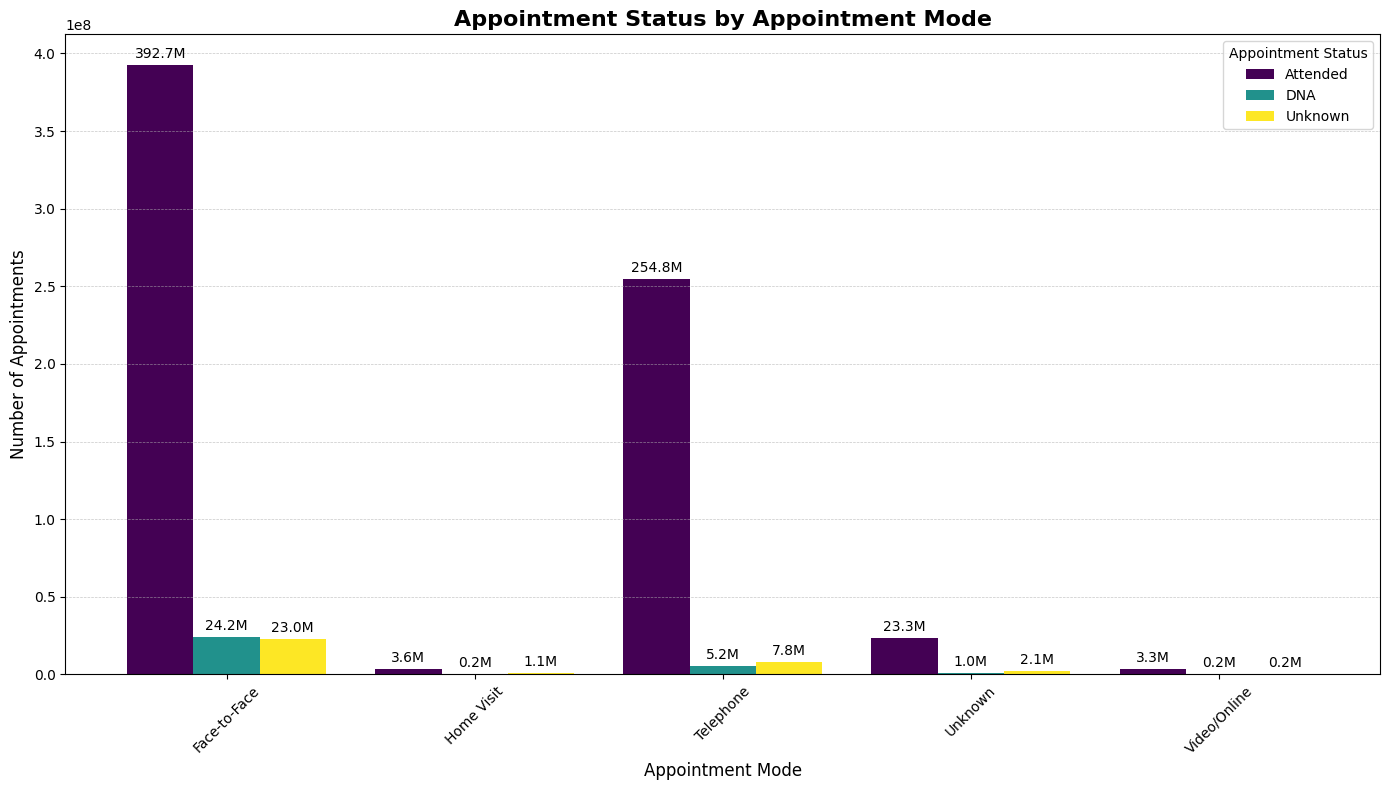

In [100]:
# Create a pivot table
pivot_table = ar.pivot_table(index='appointment_mode',
                             columns='appointment_status',
                             values='count_of_appointments',
                             aggfunc='sum',
                             fill_value=0)

# Plot the grouped bar chart
ax = pivot_table.plot(kind='bar',
                      figsize=(14, 8),
                      cmap='viridis',
                      width=0.8)

# Add totals above each bar with one decimal place
for container in ax.containers:
    labels = [f"{v / 1e6:.1f}M" if v > 0 else '' for v in container.datavalues]
    ax.bar_label(container,
                 labels=labels,
                 label_type='edge',
                 padding=3,
                 fontsize=10)

# Customise the plot
plt.title("Appointment Status by Appointment Mode", fontsize=16, fontweight='bold')
plt.xlabel("Appointment Mode", fontsize=12)
plt.ylabel("Number of Appointments", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Appointment Status", fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

#

### Look at the distribution of the time_between_book_and_appointment

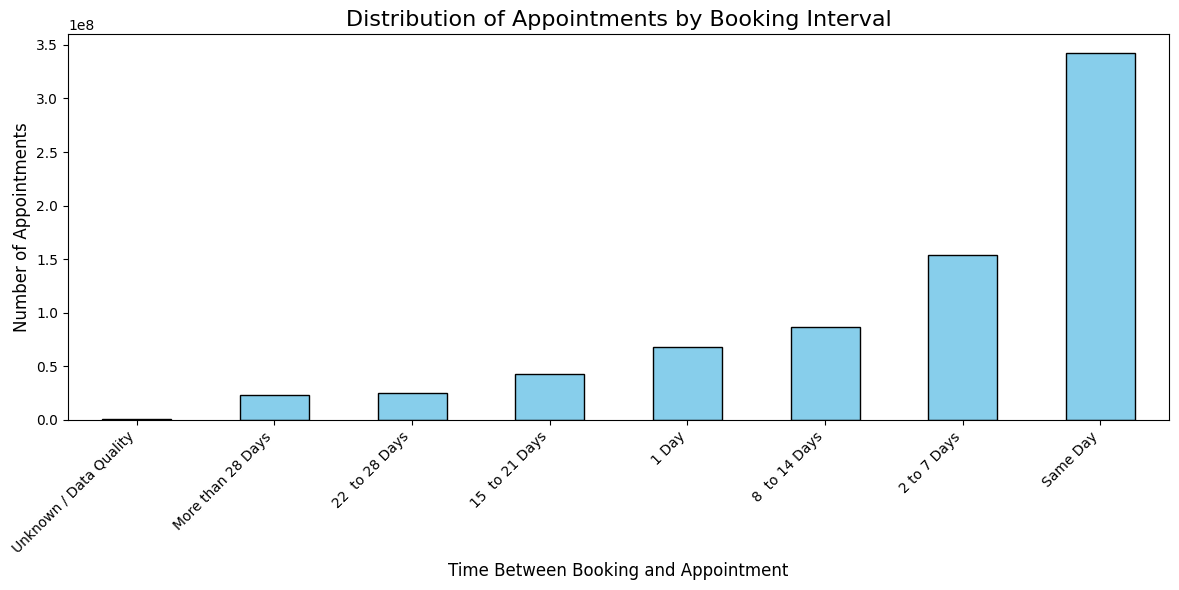

In [101]:
# Aggregating data by booking interval
interval_distribution = ar.groupby('time_between_book_and_appointment')['count_of_appointments'].sum().sort_values()

# Plotting a bar chart
interval_distribution.plot(kind='bar', figsize=(12, 6), color='skyblue', edgecolor='black')
plt.title('Distribution of Appointments by Booking Interval', fontsize=16)
plt.xlabel('Time Between Booking and Appointment', fontsize=12)
plt.ylabel('Number of Appointments', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#

### Appointment Status vs. Booking Intervals

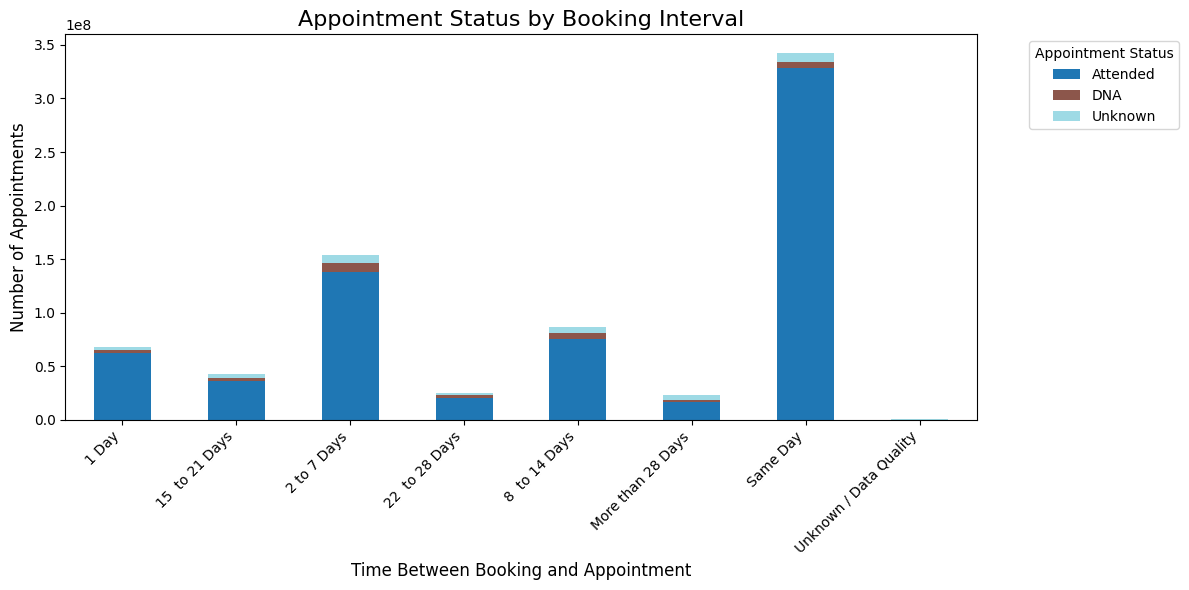

In [102]:
# Pivot table for stacked bar chart
pivot_table = ar.pivot_table(index='time_between_book_and_appointment',
                             columns='appointment_status',
                             values='count_of_appointments',
                             aggfunc='sum',
                             fill_value=0)

# Plotting the stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6), cmap='tab20')
plt.title('Appointment Status by Booking Interval', fontsize=16)
plt.xlabel('Time Between Booking and Appointment', fontsize=12)
plt.ylabel('Number of Appointments', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Appointment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#

### Appointment Mode vs. Booking Intervals

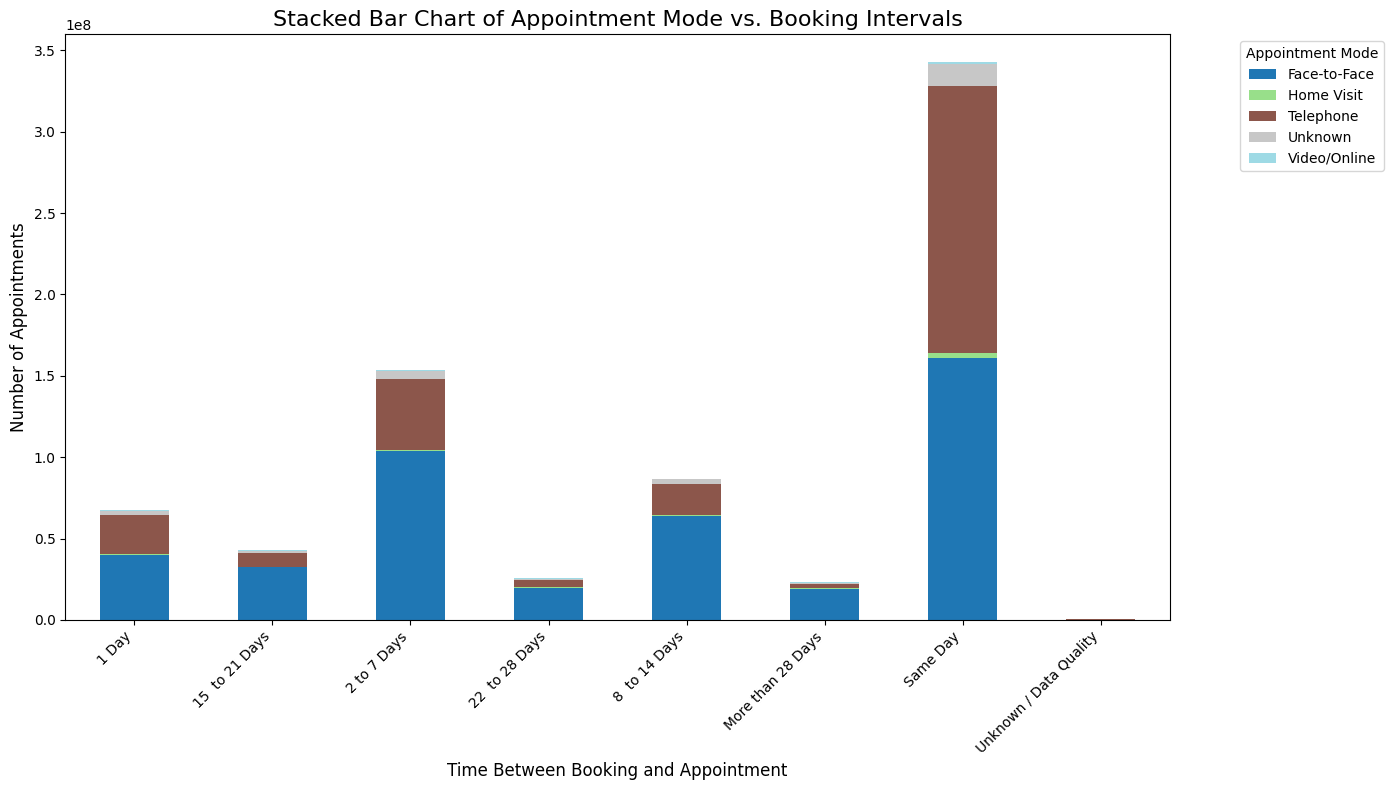

In [103]:
# Create a pivot table for stacked bar chart
stacked_data = ar.pivot_table(index='time_between_book_and_appointment',
                              columns='appointment_mode',
                              values='count_of_appointments',
                              aggfunc='sum',
                              fill_value=0)

# Plot the stacked bar chart
stacked_data.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab20')
plt.title('Stacked Bar Chart of Appointment Mode vs. Booking Intervals', fontsize=16)
plt.xlabel('Time Between Booking and Appointment', fontsize=12)
plt.ylabel('Number of Appointments', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Appointment Mode', fontsize=10, loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

#

### Trends in Appointments Over Time by Booking Interval

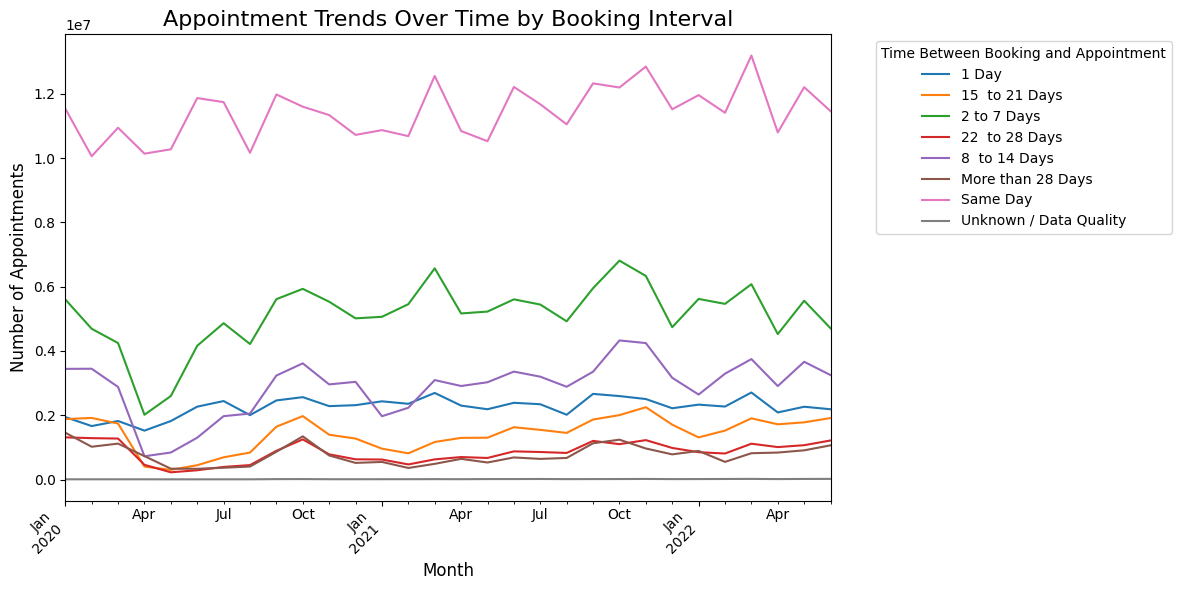

In [104]:
# Aggregating data by month and booking interval
trend_data = ar.groupby(['appointment_month', 'time_between_book_and_appointment'])['count_of_appointments'].sum().unstack()

# Plotting the line chart
trend_data.plot(kind='line', figsize=(12, 6))
plt.title('Appointment Trends Over Time by Booking Interval', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Appointments', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Time Between Booking and Appointment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#

### Time Between Booking and Appointment by Location

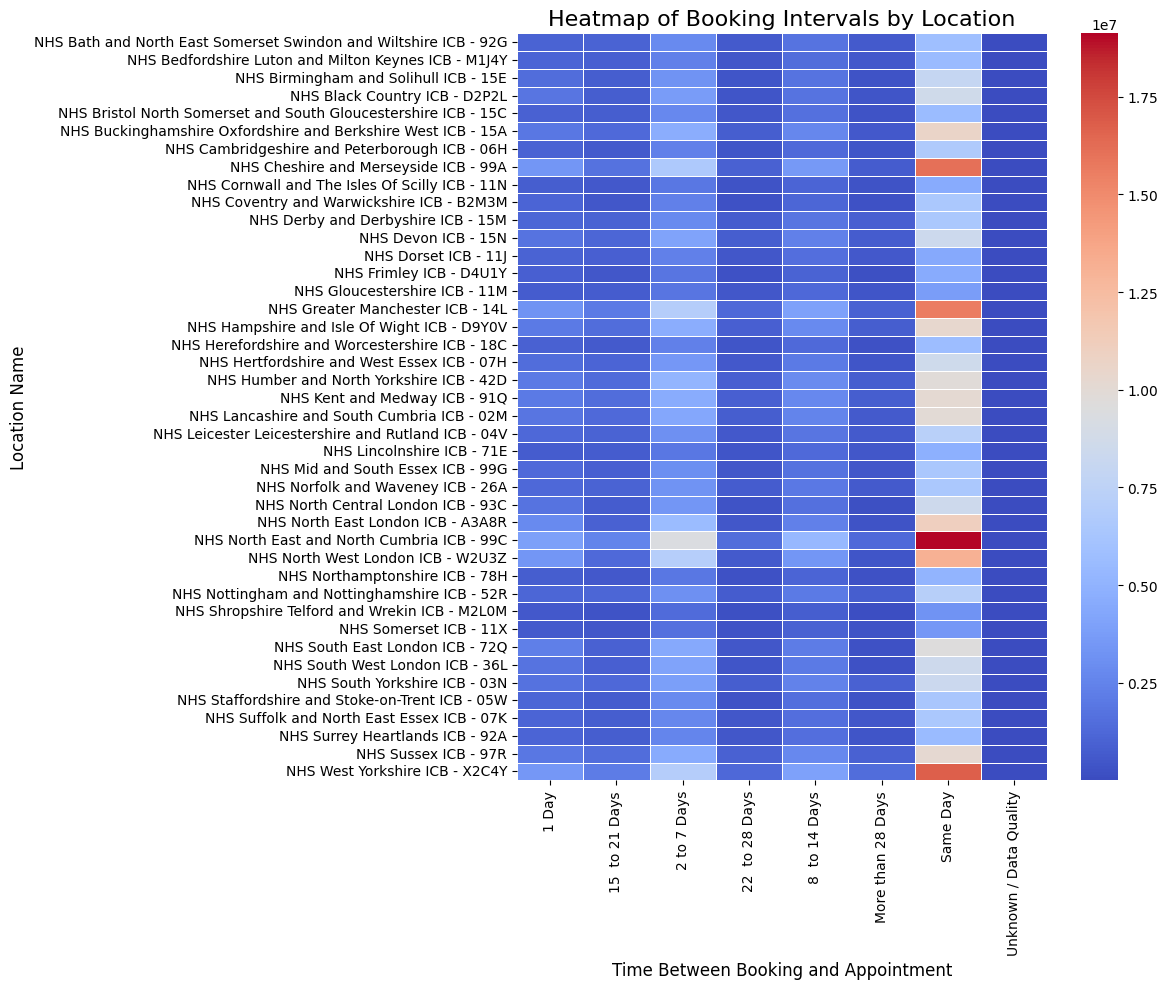

In [105]:
app_loc = ar.pivot_table(index='location_name',
                                 columns='time_between_book_and_appointment',
                                 values='count_of_appointments',
                                 aggfunc='sum',
                                 fill_value=0)

plt.figure(figsize=(12, 10))
sns.heatmap(app_loc, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Heatmap of Booking Intervals by Location', fontsize=16)
plt.xlabel('Time Between Booking and Appointment', fontsize=12)
plt.ylabel('Location Name', fontsize=12)
plt.tight_layout()
plt.show()

#

### How do the healthcare professional types differ over time?

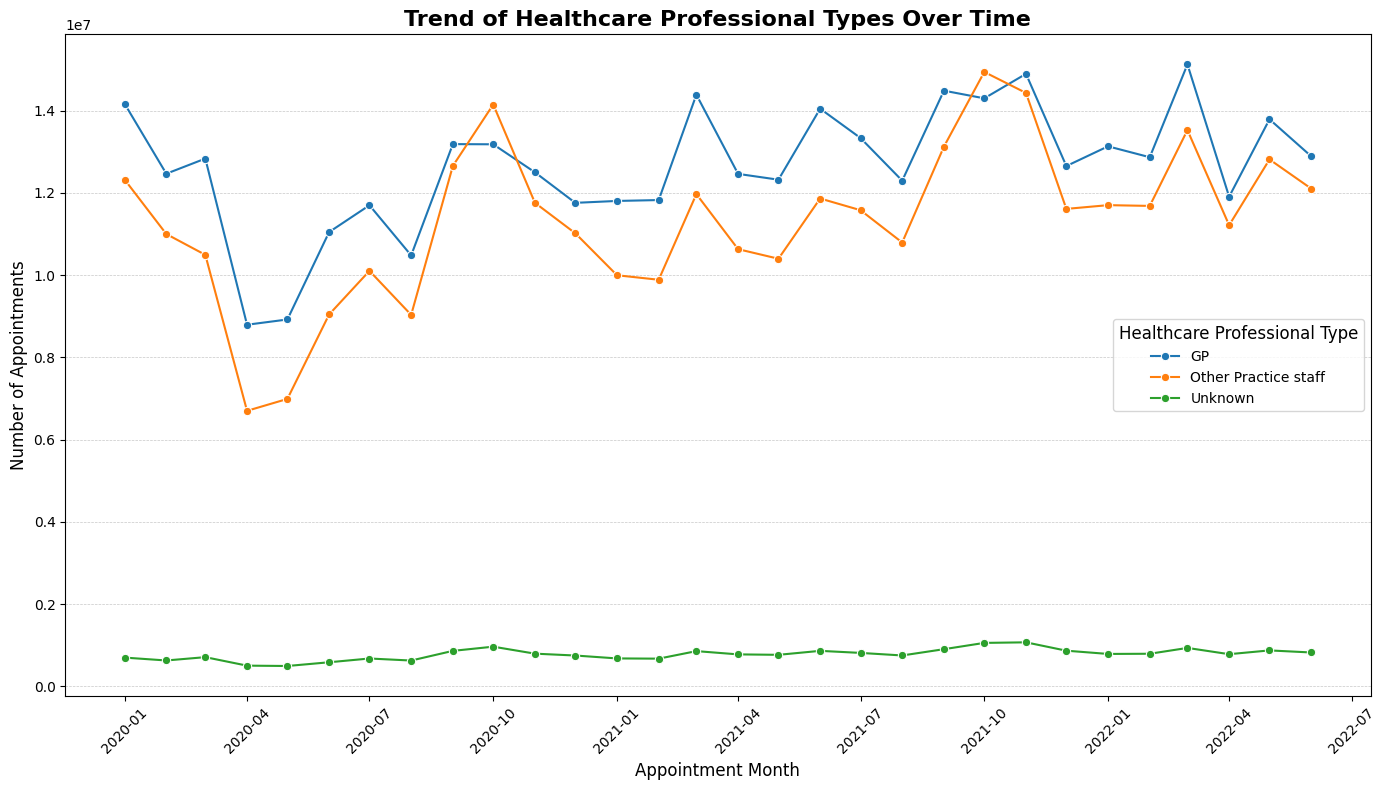

In [106]:
# Convert 'appointment_month' to a datetime object
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], format='%Y-%m')

# Aggregate the data by appointment_month and hcp_type
hcp_trend = ar.groupby(['appointment_month', 'hcp_type'])['count_of_appointments'].sum().reset_index()

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=hcp_trend,
             x='appointment_month',
             y='count_of_appointments',
             hue='hcp_type',
             marker='o')

# Customise the plot
plt.title("Trend of Healthcare Professional Types Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Appointment Month", fontsize=12)
plt.ylabel("Number of Appointments", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Healthcare Professional Type", fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

#

### Are there significant changes in whether or not visits are attended?

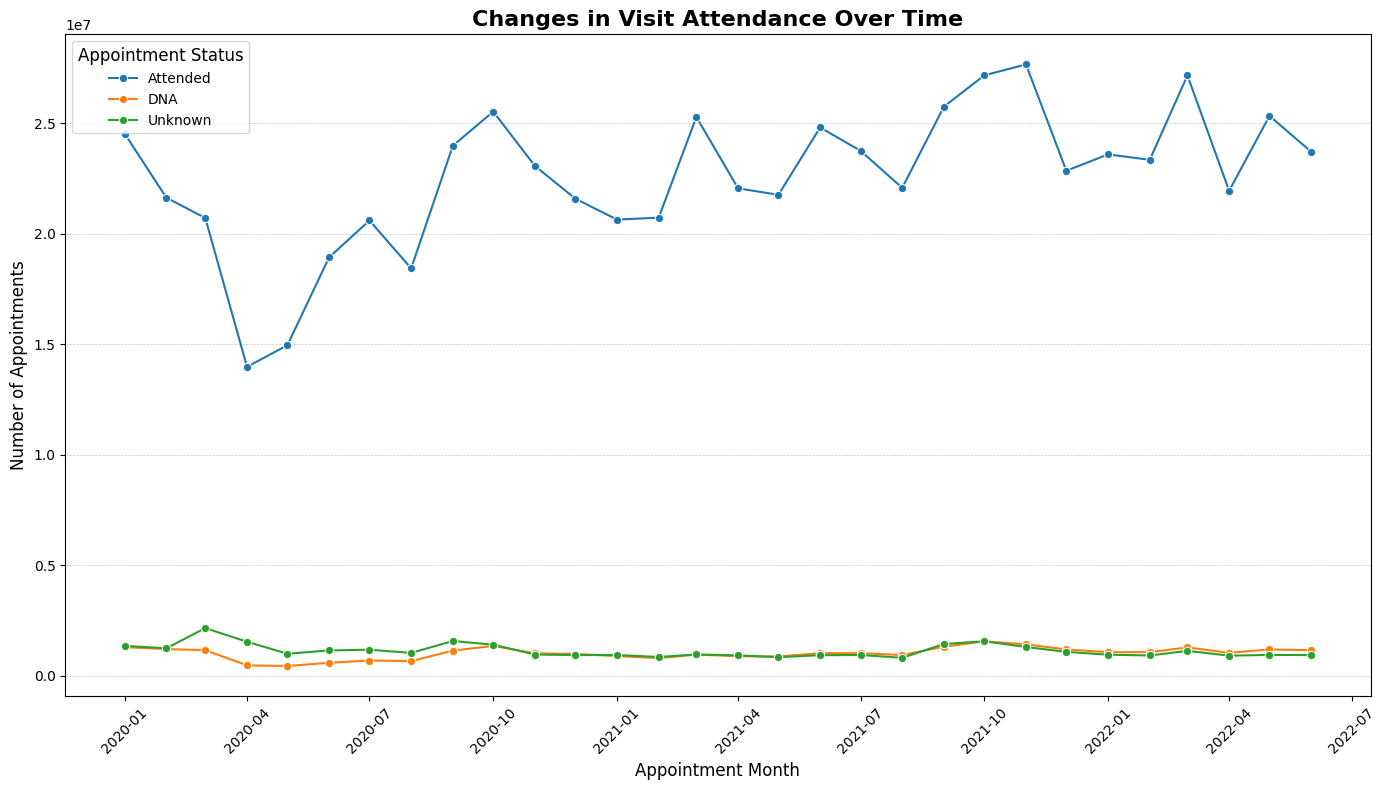

In [107]:
# Group by 'appointment_month' and 'appointment_status' to calculate total appointments
attendance_trend = (ar.groupby(['appointment_month', 'appointment_status'])['count_of_appointments']
                    .sum()
                    .reset_index())

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=attendance_trend,
             x='appointment_month',
             y='count_of_appointments',
             hue='appointment_status',
             marker='o')

# Customise the plot
plt.title("Changes in Visit Attendance Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Appointment Month", fontsize=12)
plt.ylabel("Number of Appointments", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Appointment Status", fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

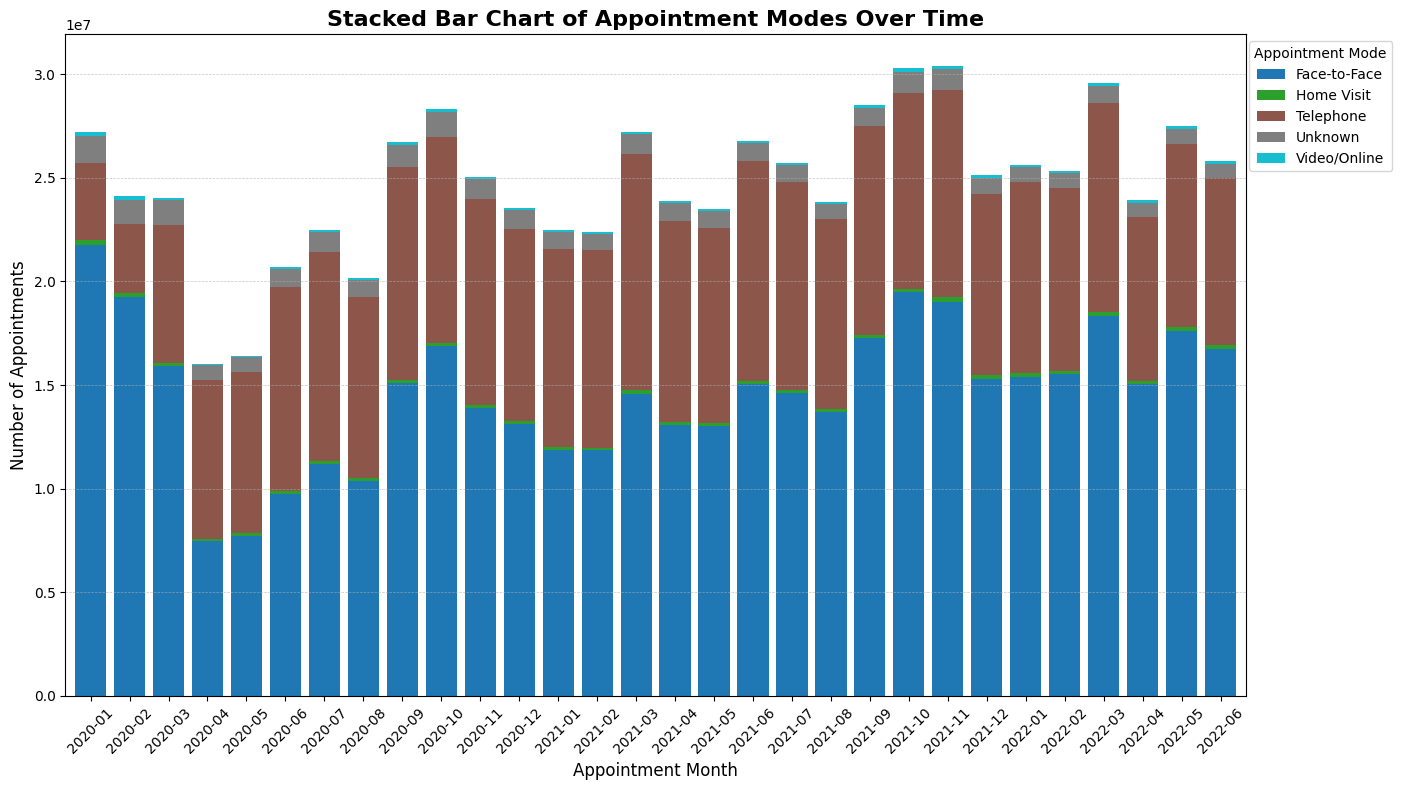

In [108]:
# Group by 'appointment_month' and 'appointment_mode' to calculate total appointments
appointment_mode_data = (
    ar.groupby(['appointment_month', 'appointment_mode'])['count_of_appointments']
    .sum()
    .reset_index())

# Pivot the data for the stacked bar chart
appointment_mode_pivot = appointment_mode_data.pivot(
    index='appointment_month', columns='appointment_mode', values='count_of_appointments'
).fillna(0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))
appointment_mode_pivot.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap='tab10')

# Update x-axis labels to remove "00:00:00" and align them with bars
ax.set_xticks(range(len(appointment_mode_pivot.index)))
ax.set_xticklabels(appointment_mode_pivot.index.strftime('%Y-%m'), rotation=45, ha='center')

# Customizing the chart
ax.set_title("Stacked Bar Chart of Appointment Modes Over Time", fontsize=16, fontweight='bold')
ax.set_xlabel("Appointment Month", fontsize=12)
ax.set_ylabel("Number of Appointments", fontsize=12)
ax.legend(title='Appointment Mode', fontsize=10, loc='upper right', bbox_to_anchor=(1.13, 1))
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

#

# Exploratory Data Analysis

<h1 style="text-align: center;">Actual Duration</h1>

### Objectives: 
- General exploration of the dataset
- Explore distribution of appointment durations.

#

### 1. General exploration

In [109]:
count_unique_values(ad, 'sub_icb_location_name')

Total unique values in 'sub_icb_location_name': 106


106

#

### 2. What's the distribution of Appointmment Durations? 

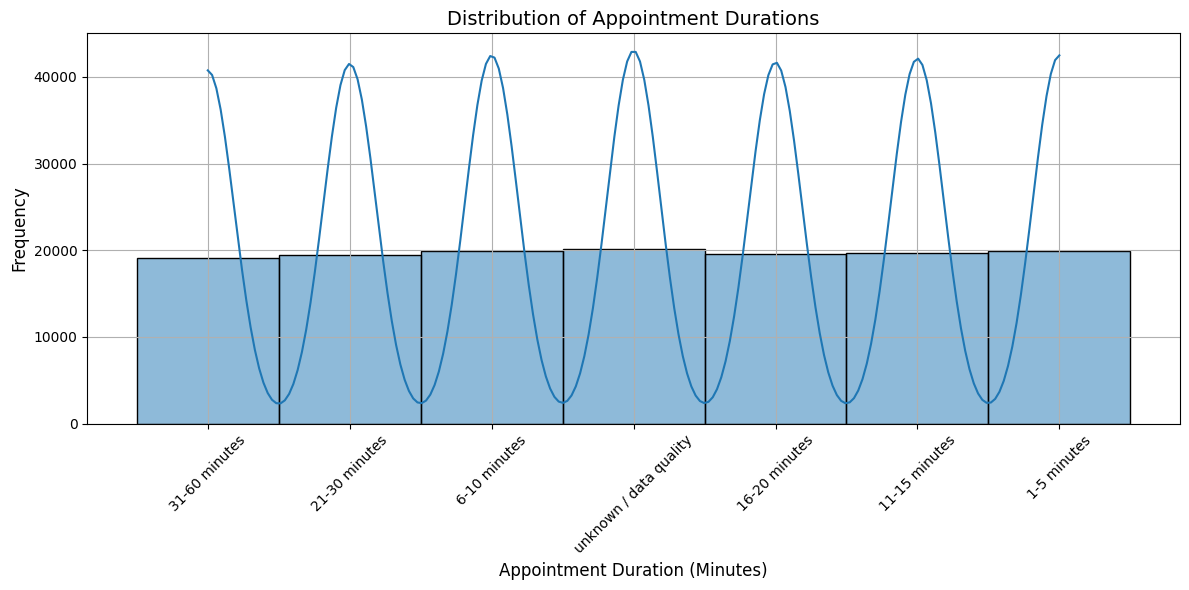

In [110]:
plt.figure(figsize=(12, 6))
sns.histplot(ad["actual_duration"], bins=20, kde=True)

# Customise the plot.
plt.title("Distribution of Appointment Durations", fontsize=14)
plt.xlabel("Appointment Duration (Minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  
plt.grid(True)
plt.tight_layout()
plt.show()

#

### Explanatory Data Analysis (Distribution of Appointment Durations)

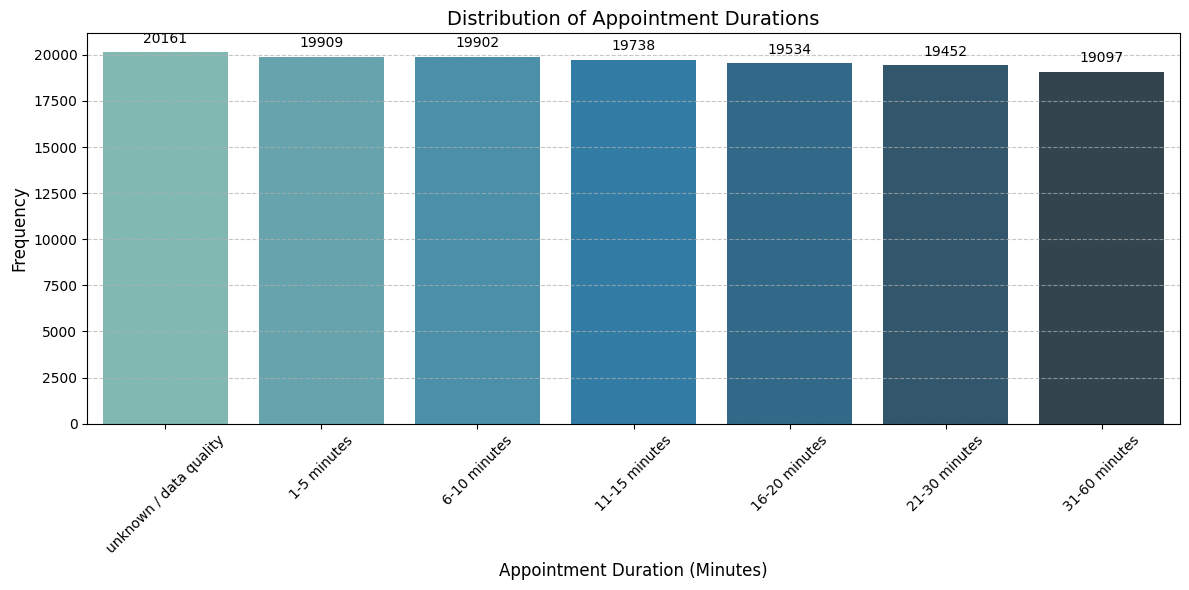

In [111]:
# Calculate counts for each category.
duration_counts = ad['actual_duration'].value_counts()

# Plot a bar chart.
plt.figure(figsize=(12, 6))
sns.barplot(x=duration_counts.index, y=duration_counts.values, palette="YlGnBu_d")

# Customise the plot.
plt.title("Distribution of Appointment Durations", fontsize=14)
plt.xlabel("Appointment Duration (Minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate counts above bars.
for i, value in enumerate(duration_counts.values):
    plt.text(i, value + 500, str(value), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

#

### Examine Capacity Issues

### Which locations had the highest appointmment counts? 

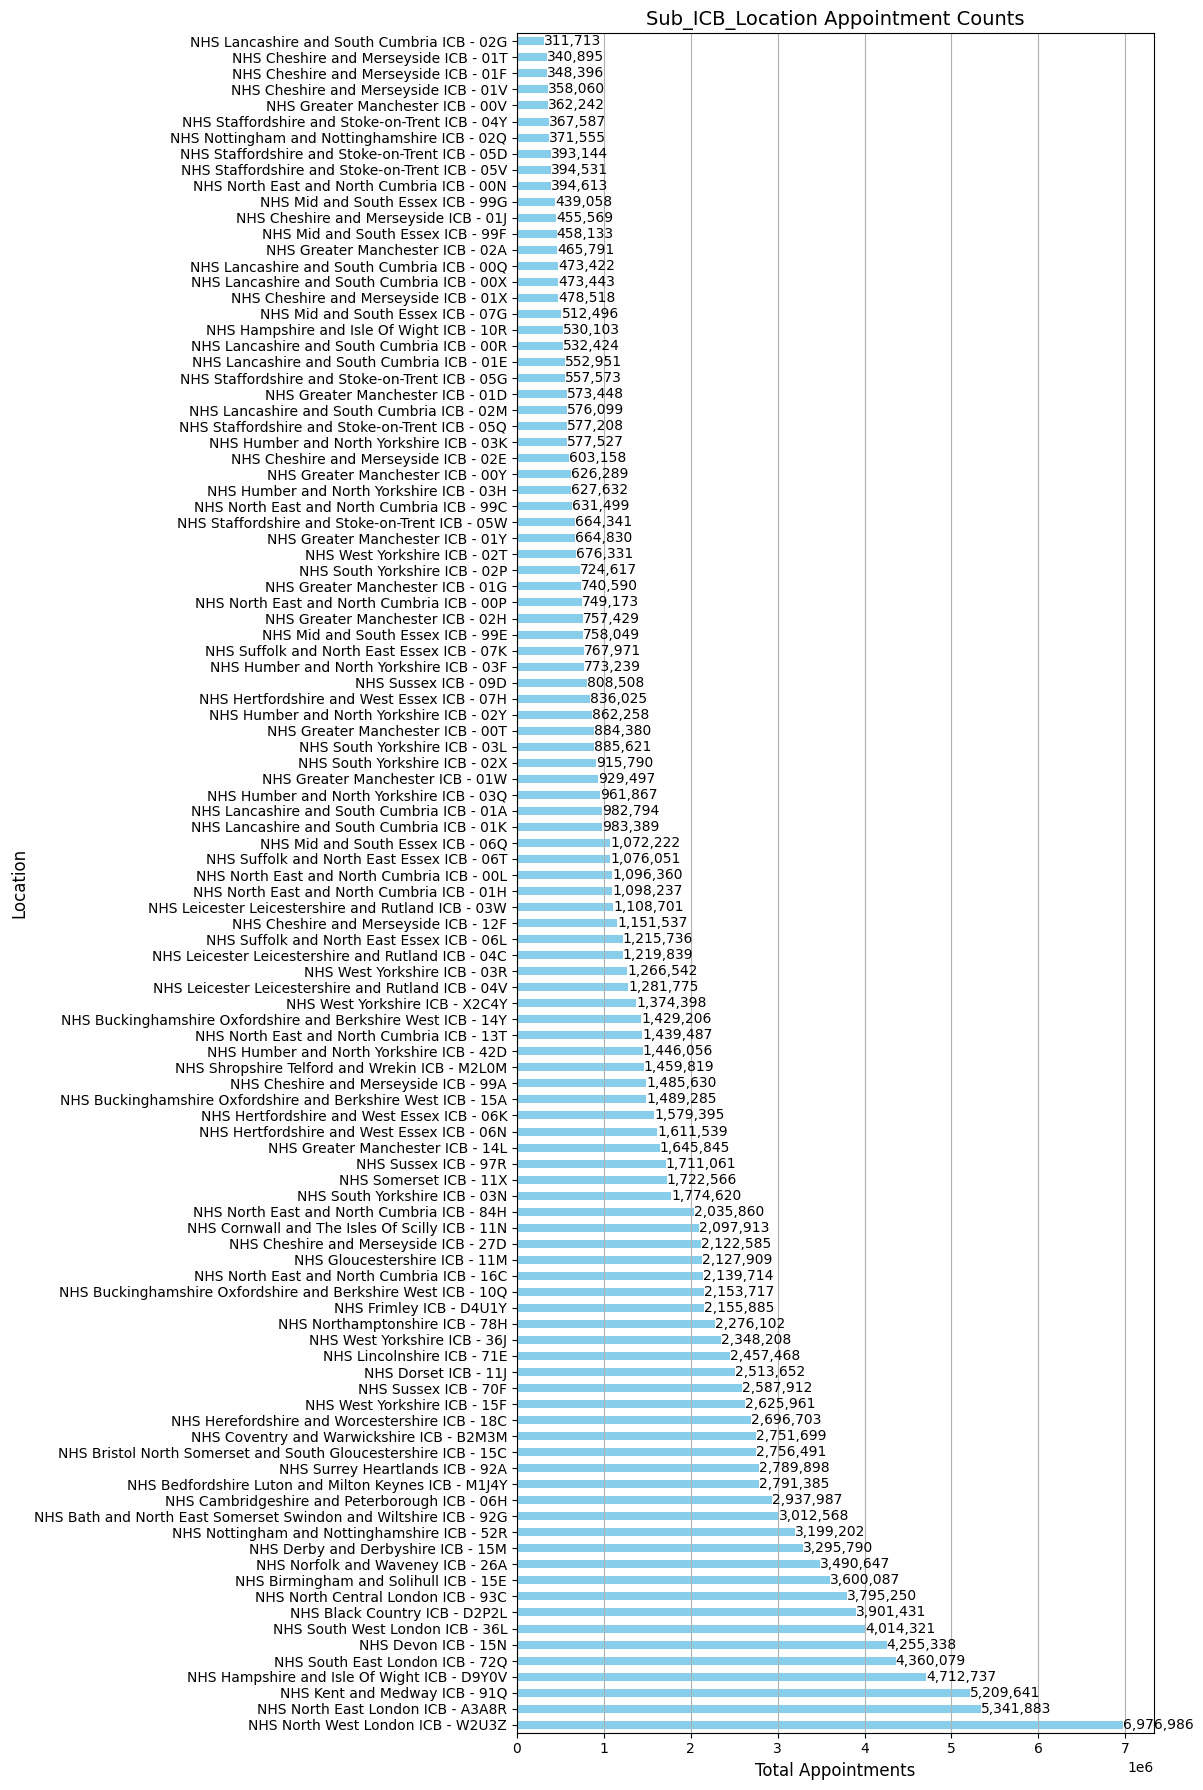

In [112]:
# Group by sub_icb_location and calculate total appointments.
location_counts = ad.groupby("sub_icb_location_name")["count_of_appointments"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 18))  
location_counts.plot(kind="barh", color="skyblue")
plt.title("Sub_ICB_Location Appointment Counts", fontsize=14)
plt.xlabel("Total Appointments", fontsize=12)
plt.ylabel("Location", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x")

# Add annotations.
for index, value in enumerate(location_counts):
    plt.text(value, index, f"{value:,}", fontsize=10, va="center")  

plt.tight_layout()
plt.show()

#

### Top 10 locations with highest appointment count (for stakeholder)

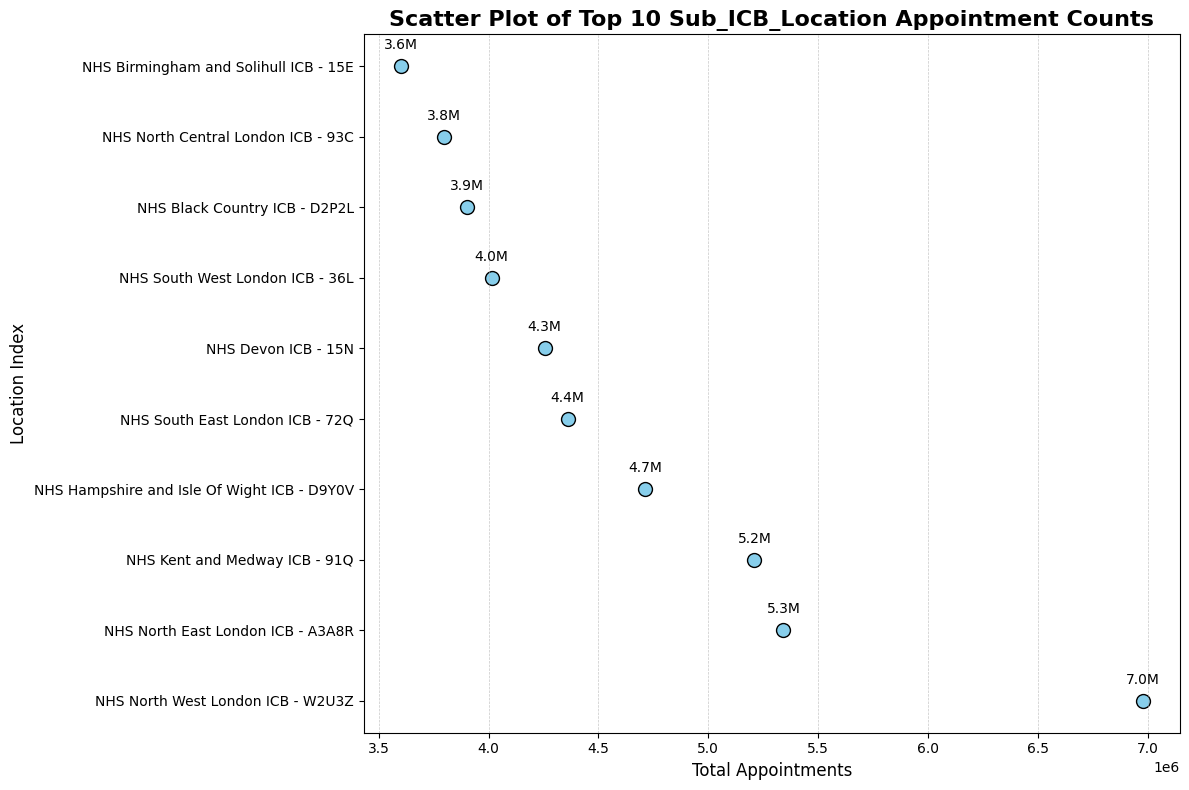

In [113]:
# Group by sub_icb_location_name and calculate total appointments
location_counts = ad.groupby("sub_icb_location_name")["count_of_appointments"].sum().sort_values(ascending=False)

# Extract the top 10 locations
top_10 = location_counts.head(10)

# Plot the scatter plot for the top 10 locations
plt.figure(figsize=(12, 8))
plt.scatter(top_10.values, range(len(top_10)), color="skyblue", edgecolor="black", s=100)

# Add annotations for the total appointments with one decimal place (in millions)
for i, (location, count) in enumerate(top_10.items()):
    plt.text(count, i + 0.2, f"{count / 1e6:.1f}M", fontsize=10, va="bottom", ha="center", color="black")

# Add titles and labels
plt.title("Scatter Plot of Top 10 Sub_ICB_Location Appointment Counts", fontsize=16, fontweight="bold")
plt.xlabel("Total Appointments", fontsize=12)
plt.ylabel("Location Index", fontsize=12)
plt.yticks(range(len(top_10)), top_10.index, fontsize=10)
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# 

### Identify locations with the highest variability or growth in appointment counts over time.

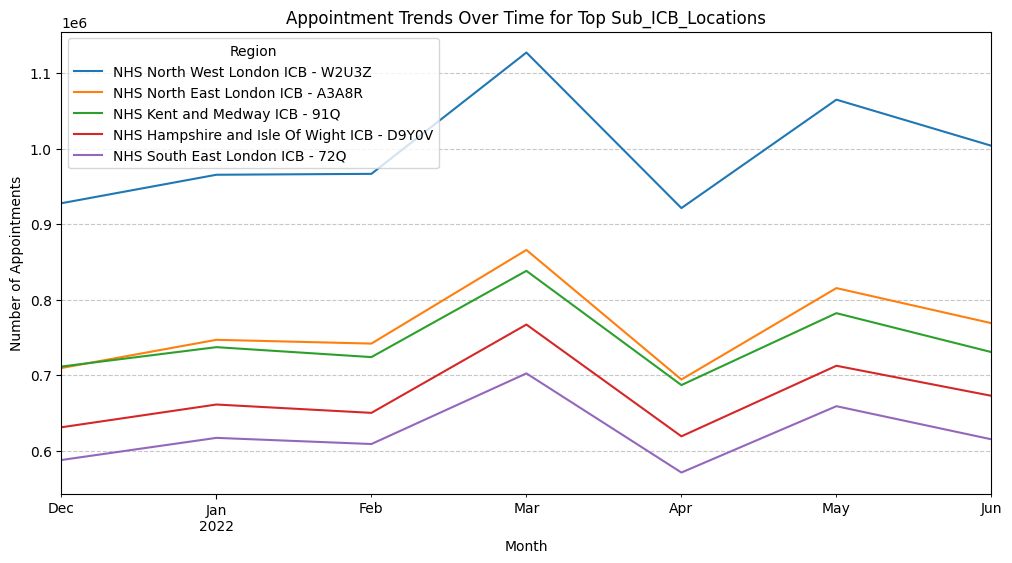

In [114]:
# Ensure appointment_date is in datetime format
ad['appointment_date'] = pd.to_datetime(ad['appointment_date'], errors='coerce')

# Extract appointment_month from appointment_date
ad['appointment_month'] = ad['appointment_date'].dt.to_period("M")

# Group the data by sub-location and time, then calculate the trends
region_trends = (ad.groupby(["sub_icb_location_name", "appointment_month"])["count_of_appointments"]
                 .sum()
                 .reset_index())

# Convert PeriodDtype to Timestamp for plotting
region_trends["appointment_month"] = region_trends["appointment_month"].dt.to_timestamp()

# Pivot for visualisation
region_trends_pivot = region_trends.pivot(
    index="appointment_month", columns="sub_icb_location_name", values="count_of_appointments")

# Plot trends for the top sub-locations by total appointments
top_regions = region_trends.groupby("sub_icb_location_name")["count_of_appointments"].sum().nlargest(5).index
region_trends_pivot[top_regions].plot(figsize=(12, 6))

# Customise Plot
plt.title("Appointment Trends Over Time for Top Sub_ICB_Locations")
plt.xlabel("Month")
plt.ylabel("Number of Appointments")
plt.legend(title="Region")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#

### Distribution of Appointment Durations

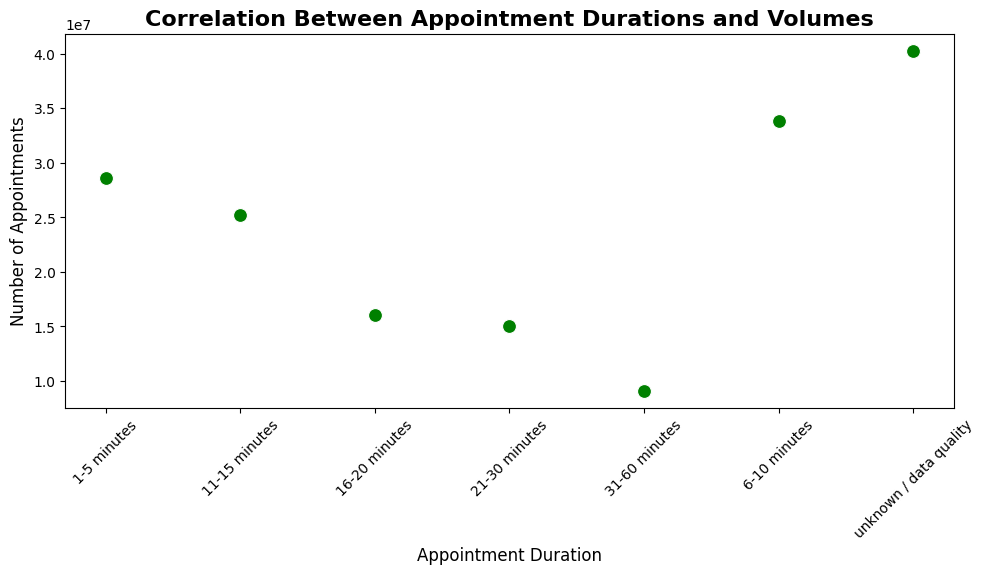

In [115]:
# Aggregate data
duration_volumes = ad.groupby('actual_duration')['count_of_appointments'].sum().reset_index()

# Plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=duration_volumes, x='actual_duration', y='count_of_appointments', s=100, color='green')
plt.title('Correlation Between Appointment Durations and Volumes', fontsize=16, fontweight='bold')
plt.xlabel('Appointment Duration', fontsize=12)
plt.ylabel('Number of Appointments', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

#

# Exploratory Data Analysis

<h1 style="text-align: center;">Tweets</h1>

#

### Twitter Data Analysis 

In [116]:
# Define top_retweets and top_favorites
top_retweets = tw[['tweet_full_text', 'tweet_retweet_count']].sort_values(
    by='tweet_retweet_count', ascending=False).head(10)

top_favorites = tw[['tweet_full_text', 'tweet_favorite_count']].sort_values(
    by='tweet_favorite_count', ascending=False).head(10)

# Create DataFrames for top retweeted and favorited tweets
top_retweeted_df = pd.DataFrame({"Tweet Text": top_retweets['tweet_full_text'],
                                 "Retweet Count": top_retweets['tweet_retweet_count']})

top_favorited_df = pd.DataFrame({"Tweet Text": top_favorites['tweet_full_text'],
                                 "Favorite Count": top_favorites['tweet_favorite_count']})

# Display as tables
print("Top Retweeted Tweets:")
display(top_retweeted_df)

print("\nTop Favorited Tweets:")
display(top_favorited_df)

Top Retweeted Tweets:


Tweet Text  Retweet Count
263   RT @UltimaLionsDen: Temitope is looking to boo...            303
1139  RT @khaleejtimes: .@BurjeelHoldings, a private...            208
985   RT @khaleejtimes: .@BurjeelHoldings, a private...            208
330   RT @khaleejtimes: .@BurjeelHoldings, a private...            208
595   RT @khaleejtimes: .@BurjeelHoldings, a private...            208
1160  RT @khaleejtimes: .@BurjeelHoldings, a private...            208
1168  RT @khaleejtimes: .@BurjeelHoldings, a private...            208
1132  RT @khaleejtimes: .@BurjeelHoldings, a private...            208
987   RT @khaleejtimes: .@BurjeelHoldings, a private...            208
1097  RT @khaleejtimes: .@BurjeelHoldings, a private...            208


Top Favorited Tweets:


Tweet Text  Favorite Count
1156  Lipid-Lowering Drugs\n\n#TipsForNewDocs #MedEd...              42
9     You ready for $JCO @_JennyCo ❤️\n\n#Healthcare...              28
442   How health insurance works 😂 \n\n#comedy #adul...              20
84    Our nat’l choices re: #healthcare systems aren...              18
1122  Heart Failure, Myocardial Infarction &amp; imm...              17
119   More data that our 13+ 🇨🇦 #healthcare systems ...              14
758   Looking forward to speaking at #ConV2X on Sep ...              13
1098  @CapricornFMNews We have waiting to hear this ...              12
342   September is #WomenInMedicine Month! Thrilled ...              11
1093  Thanks &amp; Happy #WomenInMedicine Month to A...              10

#

In [117]:
tw.shape

(1174, 10)

#

### Given the output above I will revisit the data cleaning for Tweets file 

In [118]:
# Identify duplicates based on all columns except 'tweet_id'
duplicates = tw.duplicated(subset=['tweet_full_text', 'tweet_entities', 'tweet_entities_hashtags',
                                   'tweet_metadata', 'tweet_retweet_count', 'tweet_favorite_count',
                                   'tweet_favorited', 'tweet_retweeted', 'tweet_lang'])

# Filter duplicates
duplicate_rows = tw[duplicates]

# Display the duplicate rows
print("Duplicate Rows:")
duplicate_rows.count()

Duplicate Rows:


tweet_id                   205
tweet_full_text            205
tweet_entities             205
tweet_entities_hashtags    205
tweet_metadata             205
tweet_retweet_count        205
tweet_favorite_count       205
tweet_favorited            205
tweet_retweeted            205
tweet_lang                 205
dtype: int64

In [119]:
# Drop duplicates based on all columns except 'tweet_id'
tw_cleaned = tw.drop_duplicates(subset=['tweet_full_text', 'tweet_entities', 'tweet_entities_hashtags',
                                        'tweet_metadata', 'tweet_retweet_count', 'tweet_favorite_count',
                                        'tweet_favorited', 'tweet_retweeted', 'tweet_lang'])

# Check the new shape of the DataFrame
print("Shape of the DataFrame after dropping duplicates:", tw_cleaned.shape)

# Display the cleaned DataFrame
tw_cleaned.count()

Shape of the DataFrame after dropping duplicates: (969, 10)


tweet_id                   969
tweet_full_text            969
tweet_entities             969
tweet_entities_hashtags    969
tweet_metadata             969
tweet_retweet_count        969
tweet_favorite_count       969
tweet_favorited            969
tweet_retweeted            969
tweet_lang                 969
dtype: int64

#

In [120]:
# Create new DataFrame with only the tweet text
tweet_text_df = tw[['tweet_full_text']].copy()
tweet_text_df.head()

tweet_full_text
0  As Arkansas’ first Comprehensive Stroke Certif...
1  RT @AndreaGrammer: Work-life balance is at the...
2  RT @OntarioGreens: $10 billion can go a long w...
3  RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...
4  ICYMI: Our recent blogs on Cybersecurity in Ac...

#

### Loop through the messages, and create a list of values containing the # symbol.

In [121]:
# Extract hashtags from the tweets
hashtags = []
for text in tw['tweet_full_text']:
    hashtags.extend([word for word in text.split() if word.startswith('#')])

# Display the first 30 records
hashtags[:30]

['#Healthcare',
 '#PremiseHealth',
 '#hiring',
 '#Healthcare',
 '#blogs',
 '#digitaltransformation',
 '#cybersecurity',
 '#accounting',
 '#finance',
 '#healthcare',
 '#firstcoastcna',
 '#cnaexam',
 '#cnaexampreparation',
 '#jacksonville',
 '#cnatraining',
 '#nurse',
 '#nursing',
 '#nurselife',
 '#nursepractitioner',
 '#nurseproblems',
 '#nursingschool',
 '#healthcare',
 '#disparities.',
 '#healthcare',
 '#alert',
 '#insurance',
 '#data',
 '#Healthcare',
 '#healthcare',
 '#Healthcare']

#

### Convert the series to a DataFrame in preparation for visualisation.

In [122]:
hashtags_df = pd.DataFrame(hashtags, columns=['hashtag'])
hashtags_df.head()

hashtag
0     #Healthcare
1  #PremiseHealth
2         #hiring
3     #Healthcare
4          #blogs

#

### Count the occurrences of each hashtag

In [123]:
hashtag_counts = hashtags_df['hashtag'].value_counts().reset_index()
hashtag_counts.columns = ['hashtag', 'count']

# Ensure the count column is of integer type
hashtag_counts['count'] = hashtag_counts['count'].astype(int)
hashtag_counts.head()

hashtag  count
0  #healthcare    549
1  #Healthcare    190
2      #health     66
3  #HealthCare     46
4          #AI     43

# 

### Display records where the count is larger than 10.

In [124]:
# Filter hashtags with count greater than 10
popular_hashtags = hashtag_counts[hashtag_counts['count'] > 10]
popular_hashtags

hashtag  count
0                   #healthcare    549
1                   #Healthcare    190
2                       #health     66
3                   #HealthCare     46
4                           #AI     43
5                     #medicine     42
6                          #job     38
7                      #medical     30
8                     #strategy     30
9                       #pharma     25
10               #digitalhealth     25
11                     #biotech     25
12                  #MedTwitter     25
13     #competitiveintelligence     24
14              #pharmaceutical     24
15                   #marketing     24
16                       #MedEd     23
17              #TipsForNewDocs     21
18                     #vaccine     18
19                      #Health     18
20             #MachineLearning     17
21                 #coronavirus     16
22             #WomenInMedicine     16
23        #competitivemarketing     16
24                      #hiring     15
25                 #healthcare.     15
26                  #telehealth     14
27                    #medicare     14
28  #DoctorofVeterinaryMedicine     14
29                        #news     14
30                      #FOAMed     13
31                 #PatientCare     13
32                #telemedicine     11
33                 #healthcare?     11
34                       #covid     11
35                      #doctor     11
36                      #Python     11

#

### Create bar plot indicating records with count >10.

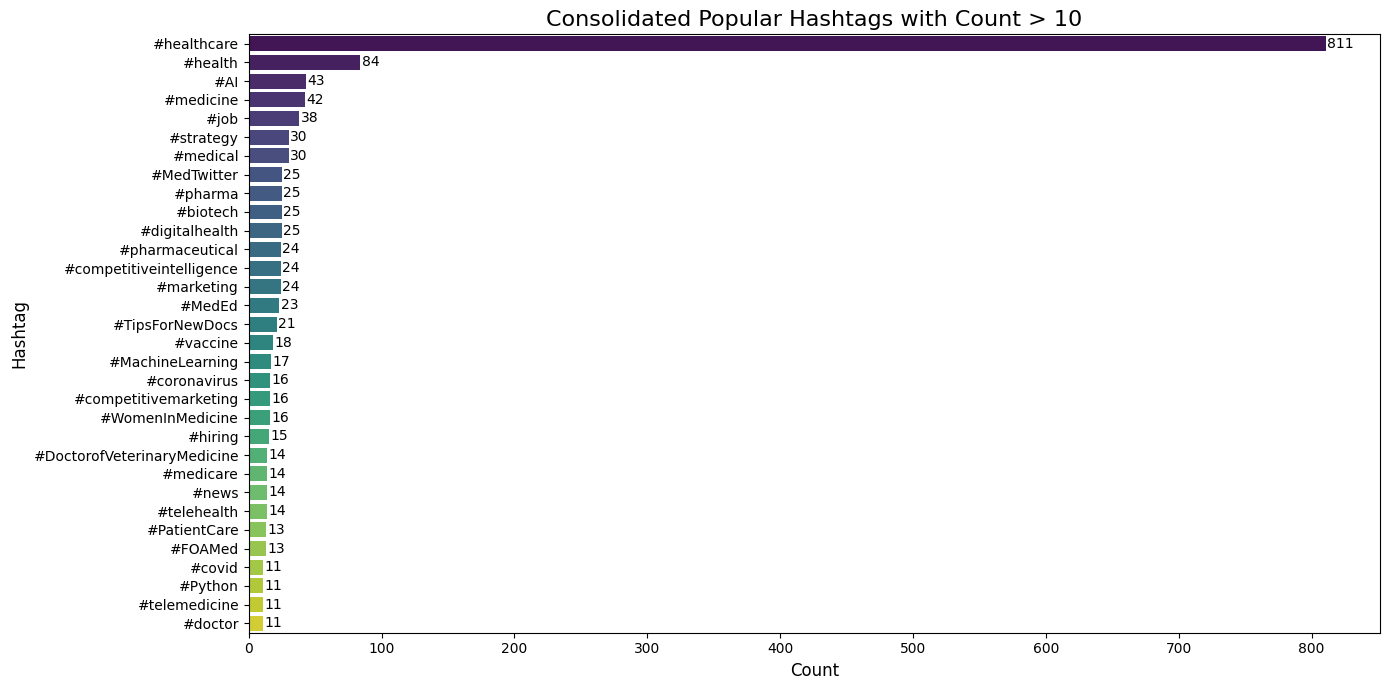

In [125]:
# Create a mapping dictionary for standardisation
hashtag_mapping = {'#Healthcare': '#healthcare',
                   '#HealthCare': '#healthcare',
                   '#healthcare.': '#healthcare',
                   '#healthcare?': '#healthcare',
                   '#Health': '#health',
                   '#healthcare.': '#healthcare',
                   '#healthcare?': '#healthcare',
                   '#health': '#health',
                   '#Health': '#health'}

# Replace hashtags based on the mapping
popular_hashtags['hashtag'] = popular_hashtags['hashtag'].replace(hashtag_mapping)

# Aggregate counts after consolidation
consolidated_hashtags = (popular_hashtags.groupby('hashtag', as_index=False)['count']
                         .sum()
                         .sort_values(by='count', ascending=False))

# Create a bar plot
plt.figure(figsize=(14, 7))
sns.barplot(data=consolidated_hashtags[consolidated_hashtags['count'] > 10],
            x='count',
            y='hashtag',
            palette='viridis')

# Add titles and labels
plt.title('Consolidated Popular Hashtags with Count > 10', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Hashtag', fontsize=12)

# Add total labels at the end of each bar
for index, value in enumerate(consolidated_hashtags['count']):
    if value > 10:  # Only add labels for hashtags with count > 10
        plt.text(value + 1, index, f'{value}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

#

### Define keywords specific to business problem 

In [126]:
# Define all relevant keywords
all_keywords = ["advocacy", "aid", "allocation", "awareness", "balance", "bottleneck", "budget", "campaign",
                "capacity", "capacityplanning", "care", "challenge", "clinic", "covid19", "pandemic", "crisis",
                "critical", "demands", "develop", "development", "difficulty", "doctor", "donations", "efficiency",
                "emergency", "employment", "enhance", "enhancement", "England", "fix", "financial", "frontline",
                "funding", "gap", "grants", "healthcareworkers", "hire", "hiring", "hospital", "covidvaccine",
                "improve", "improvement", "initiative", "insufficient", "investment", "issue", "labour",
                "lack", "lobbying", "lockdown", "medical", "NHS", "nurse", "operational", "operations", "optimisation",
                "patient", "personnel", "policy", "positions", "practitioner", "prioritise", "problem", "publichealth",
                "recruit", "recruiting", "recruitment", "reduce", "reduction", "regulation", "resources", "resolve",
                "resolution", "rights", "Scotland", "service", "shortage", "shortages", "spending", "staff", "staffing",
                "strain", "struggle", "support", "team", "training", "UK", "understaffed", "urgent", "Wales",
                "workforce", "workload",]


# Create a pattern for filtering tweets
keyword_pattern = '|'.join(all_keywords)

# Filter tweets based on all keywords
filtered_tweets = tw[tw['tweet_full_text'].str.contains(keyword_pattern, case=False, na=False)]

# Display the number of tweets and the tweets
print(f"Number of tweets matching all keywords: {filtered_tweets.shape[0]}")
display(filtered_tweets[['tweet_full_text']].head(10))

Number of tweets matching all keywords: 1045


tweet_full_text
0   As Arkansas’ first Comprehensive Stroke Certif...
1   RT @AndreaGrammer: Work-life balance is at the...
2   RT @OntarioGreens: $10 billion can go a long w...
4   ICYMI: Our recent blogs on Cybersecurity in Ac...
5   Nursing interventions can be independent, depe...
6   🚨#NEW:🚨 Insurance companies are figuring out t...
7   Now, more than ever, we need to focus on stren...
8   RT @AlikaMD: Our nat’l choices re: #healthcare...
9   You ready for $JCO @_JennyCo ❤️\n\n#Healthcare...
10  Big news in #healthcare for sure. The road ahe...

#

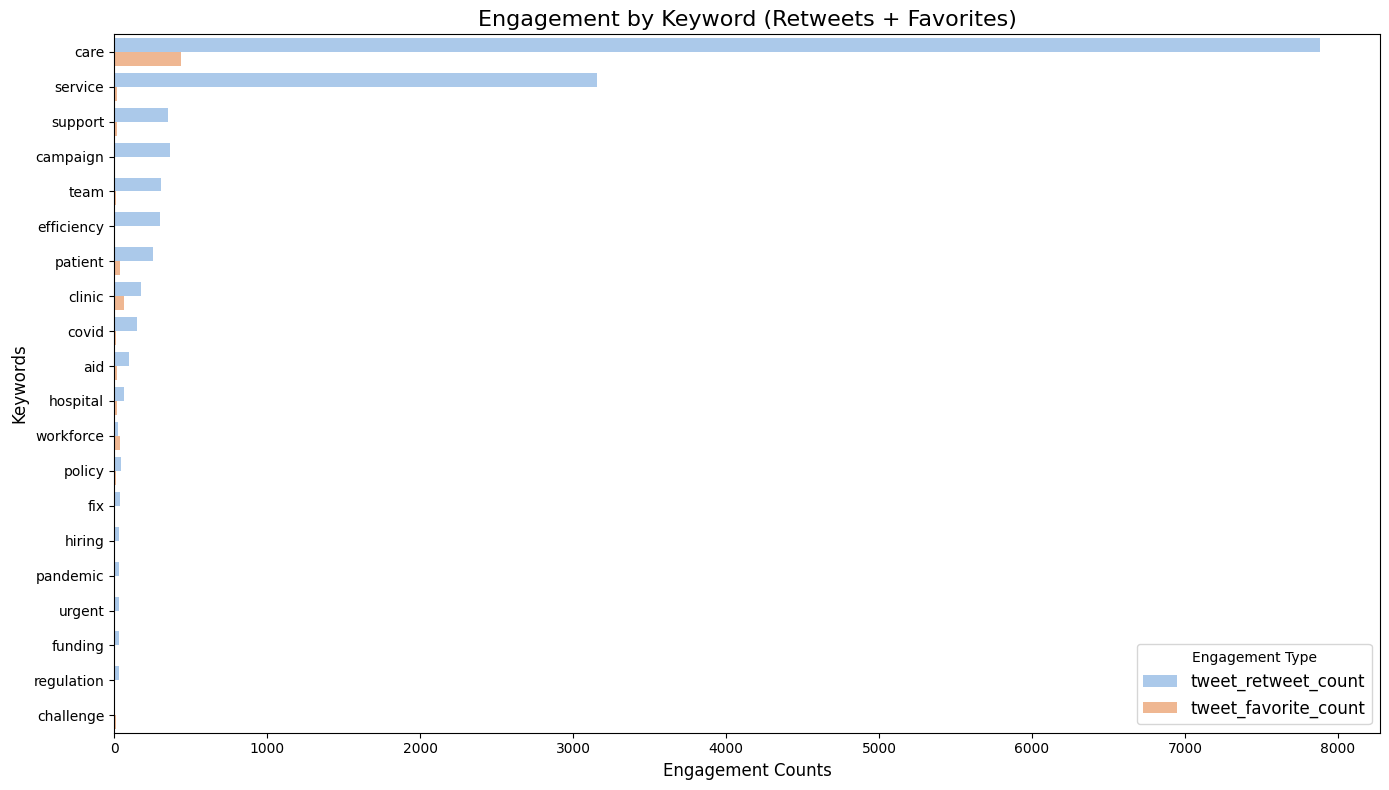

In [127]:
# Define all_keywords as provided
all_keywords = ["aid", "allocation", "awareness", "balance", "bottleneck", "budget", "campaign", "NHS",
                "capacity", "capacityplanning", "care", "challenge", "clinic", "covid", "covid19", "pandemic", "crisis",
                "critical", "demands", "difficulty", "efficiency", "urgent", "Wales", "workforce", "workload",
                "emergency", "employment", "enhance", "enhancement", "England", "fix", "financial", "frontline",
                "funding", "gap", "grants", "healthcareworkers", "hire", "hiring", "hospital", "covidvaccine",
                "improve", "improvement", "initiative", "insufficient", "investment", "issue", "labour",
                "patient", "personnel", "policy", "positions", "practitioner", "prioritise", "problem", "publichealth",
                "recruit", "recruiting", "recruitment", "reduce", "reduction", "regulation", "resources", "resolve",
                "resolution", "rights", "Scotland", "service", "shortage", "shortages", "spending", "staff", "staffing",
                "strain", "struggle", "support", "team", "training", "UK", "understaffed", "urgent", "Wales", "workforce",]

# Filter tweets containing any of the keywords
keyword_pattern = '|'.join(all_keywords)
filtered_tweets = tw[tw['tweet_full_text'].str.contains(keyword_pattern, case=False, na=False)]

# Group by keywords and aggregate engagement metrics
filtered_tweets['keywords_found'] = filtered_tweets['tweet_full_text'].apply(
    lambda text: [keyword for keyword in all_keywords if keyword in text.lower()])

# Flatten the keywords and calculate engagement counts
keywords_engagement = (filtered_tweets
                       .explode('keywords_found')
                       .groupby('keywords_found')
                       .agg({'tweet_retweet_count': 'sum', 'tweet_favorite_count': 'sum'})
                       .reset_index())

# Sort by total engagement (retweets + favorites)
keywords_engagement['total_engagement'] = (
    keywords_engagement['tweet_retweet_count'] + keywords_engagement['tweet_favorite_count'])
top_keywords = keywords_engagement.sort_values(by='total_engagement', ascending=False).head(20)

# Melt for visualisation
top_keywords_melted = top_keywords.melt(id_vars='keywords_found',
                                        value_vars=['tweet_retweet_count', 'tweet_favorite_count'],
                                        var_name='Engagement Type',
                                        value_name='Engagement Count',)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=top_keywords_melted,
            x='Engagement Count',
            y='keywords_found',
            hue='Engagement Type',
            palette='pastel')

plt.legend(title='Engagement Type', loc='lower right', fontsize=12)
plt.title("Engagement by Keyword (Retweets + Favorites)", fontsize=16)
plt.xlabel("Engagement Counts", fontsize=12)
plt.ylabel("Keywords", fontsize=12)
plt.tight_layout()
plt.show()

#

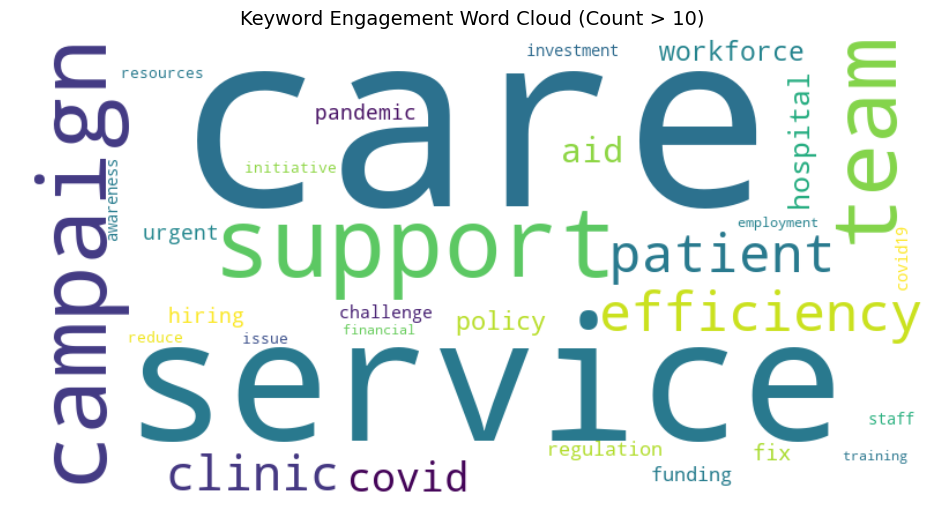

In [135]:
# Filter keywords with count > 5
filtered_keywords = keywords_engagement[keywords_engagement['total_engagement'] > 10]

# Create a dictionary of keywords and their counts
word_freq = dict(zip(filtered_keywords['keywords_found'], filtered_keywords['total_engagement']))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axis
plt.title("Keyword Engagement Word Cloud (Count > 10)", fontsize=14)
plt.show()

#

In [128]:
# Expand keywords for NHS, UK, and COVID-19 
pandemic_keywords = r"(NHS|UK|England|Scotland|Wales|vaccine|COVID|coronavirus|pandemic|lockdown|hospital|capacity|PPE|ICU|frontline|healthcare workers|public health)"

# Filter tweets based on expanded keywords
pandemic_relevant_tweets = tw[tw['tweet_full_text'].str.contains(pandemic_keywords, case=False, na=False)]

# Group by tweet text and aggregate engagement metrics
pandemic_engagement_metrics = pandemic_relevant_tweets.groupby('tweet_full_text').agg(
    total_retweets=('tweet_retweet_count', 'sum'),
    total_favorites=('tweet_favorite_count', 'sum')).reset_index()

# Sort tweets by total engagement (retweets and favourites)
top_pandemic_engaged_tweets = pandemic_engagement_metrics.sort_values(
    by=['total_retweets', 'total_favorites'], ascending=False).head(20)

# Display results
print(f"Number of tweets relevant to NHS, UK, and COVID-19: {pandemic_relevant_tweets.shape[0]}")
display(top_pandemic_engaged_tweets[['tweet_full_text', 'total_retweets', 'total_favorites']])

Number of tweets relevant to NHS, UK, and COVID-19: 171


tweet_full_text  total_retweets  \
94   RT @SoniaFurstenau: People in BC are dying of ...              81   
107  RT @modrnhealthcr: #NEW: Once the federal supp...              25   
70   RT @DHPSP: ⚕️ Can patient and family education...              24   
96   RT @UPMGlobal: Nanorobots inside our bodies an...              23   
111  RT @widercircledet1: #vaccine #covid #coronavi...              12   
72   RT @EdinUniUsher: Want to learn more about som...              10   
74   RT @GDPUKcom: Reforms To Facilitate Overseas D...               9   
106  RT @modrnhealthcr: #ICYMI: Hospitals have had ...               9   
90   RT @RasuShrestha: I support the Safety from Vi...               8   
77   RT @GlenGilmore: 🏥SURVEY: Improving #patientex...               6   
100  RT @ama_journals: Millions of #socialmedia use...               6   
5    #NEW: Once the federal supply of #coronavirusv...               5   
69   RT @Covid19DataNS: Health and evidence-based p...               4   
73   RT @FairCostPlans: In October 1968, Dr. Wacase...               4   
84   RT @KimcoStaffing: Apply now to work for #Medi...               4   
103  RT @duke_pophealth: Is #healthcare ready for a...               4   
104  RT @kelly_archives: Telehealth technologies do...               4   
105  RT @kelly_archives: The COVID-19 pandemic has ...               4   
46   Millions of #socialmedia users have been expos...               3   
144  🏥SURVEY: Improving #patientexperience with #te...               3   

     total_favorites  
94                 0  
107                0  
70                 0  
96                 0  
111                0  
72                 0  
74                 0  
106                0  
90                 0  
77                 0  
100                0  
5                  0  
69                 0  
73                 0  
84                 0  
103                0  
104                0  
105                0  
46                 4  
144                3

#

<Figure size 1200x600 with 0 Axes>

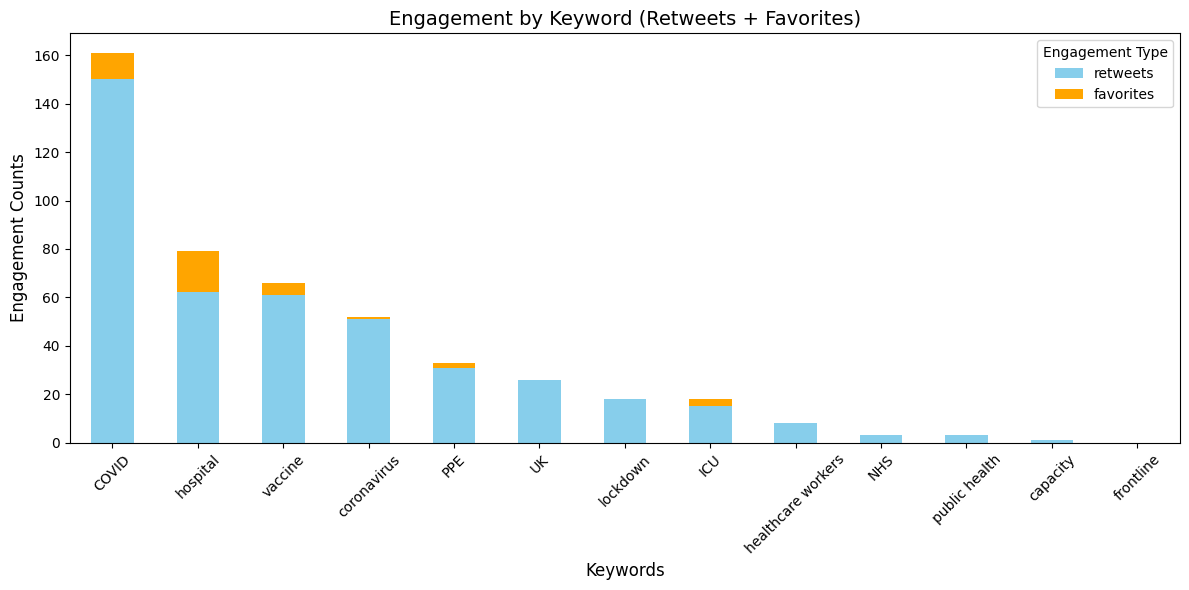

In [142]:
# Aggregate engagement metrics by keywords
keywords = ['NHS', 'UK', 'vaccine', 'COVID', 'coronavirus', 'lockdown', 'hospital', 'capacity', 'PPE', 'ICU', 
            'frontline', 'healthcare workers', 'public health']

# Initialise a dictionary to hold engagement by keyword
keyword_engagement = {keyword: {'retweets': 0, 'favorites': 0} for keyword in keywords}

for keyword in keywords:
    keyword_tweets = pandemic_relevant_tweets[
        pandemic_relevant_tweets['tweet_full_text'].str.contains(keyword, case=False, na=False)]
    keyword_engagement[keyword]['retweets'] = keyword_tweets['tweet_retweet_count'].sum()
    keyword_engagement[keyword]['favorites'] = keyword_tweets['tweet_favorite_count'].sum()

# Convert to DataFrame for visualisation
engagement_df = pd.DataFrame(keyword_engagement).T
engagement_df['total_engagement'] = engagement_df['retweets'] + engagement_df['favorites']
engagement_df = engagement_df.sort_values(by='total_engagement', ascending=False)

# Plot engagement by keyword
plt.figure(figsize=(12, 6))
engagement_df[['retweets', 'favorites']].plot(kind='bar', stacked=True, figsize=(12, 6), color=['skyblue', 'orange'])
plt.title("Engagement by Keyword (Retweets + Favorites)", fontsize=14)
plt.xlabel("Keywords", fontsize=12)
plt.ylabel("Engagement Counts", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Engagement Type")
plt.tight_layout()
plt.show()

#

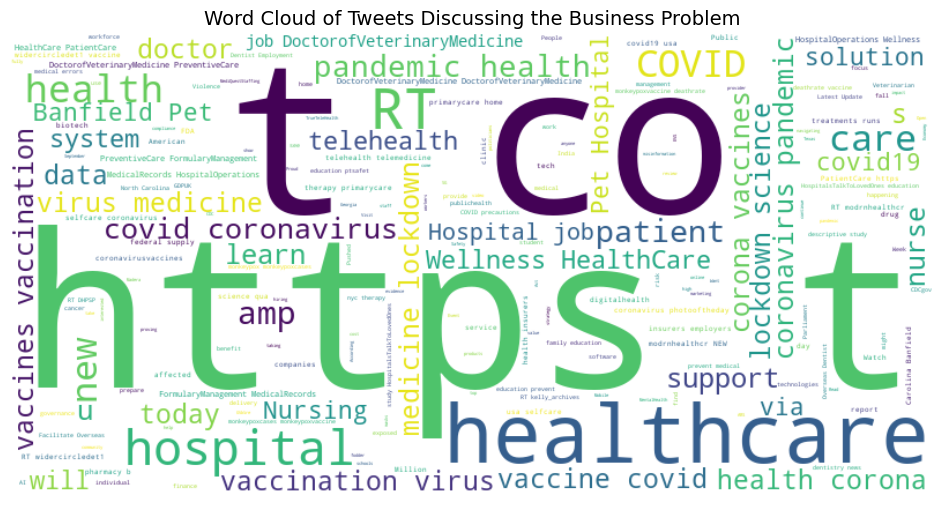

In [130]:
# Combine all relevant tweet texts
text_combined = ' '.join(pandemic_relevant_tweets['tweet_full_text'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets Discussing the Business Problem", fontsize=14)
plt.show()

#

In [131]:
# Calculate total engagement
pandemic_relevant_tweets['total_engagement'] = pandemic_relevant_tweets['tweet_retweet_count']
+ pandemic_relevant_tweets['tweet_favorite_count']

# Sort by total engagement
top_engaged_tweets = pandemic_relevant_tweets.sort_values(by='total_engagement', ascending=False).head(10)

# Display the top tweets
display(top_engaged_tweets[['tweet_full_text', 'total_engagement']])

tweet_full_text  total_engagement
321   RT @SoniaFurstenau: People in BC are dying of ...                41
28    RT @SoniaFurstenau: People in BC are dying of ...                40
306   RT @UPMGlobal: Nanorobots inside our bodies an...                23
120   RT @EdinUniUsher: Want to learn more about som...                10
1036  RT @modrnhealthcr: #ICYMI: Hospitals have had ...                 9
213   RT @DHPSP: ⚕️ Can patient and family education...                 6
251   RT @DHPSP: ⚕️ Can patient and family education...                 6
247   RT @DHPSP: ⚕️ Can patient and family education...                 6
224   RT @DHPSP: ⚕️ Can patient and family education...                 6
406   RT @modrnhealthcr: #NEW: Once the federal supp...                 5

#

### Sentiment Analysis

<Figure size 1000x600 with 0 Axes>

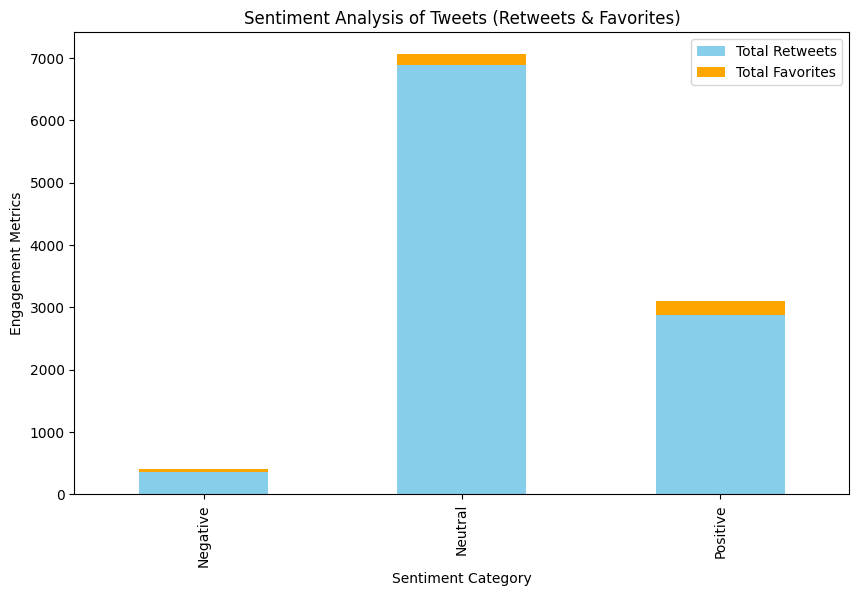

In [132]:
# Define relevant_tweets from the main dataset
relevant_tweets = tw[['tweet_full_text', 'tweet_retweet_count', 'tweet_favorite_count']].copy()

# Calculate sentiment polarity
relevant_tweets['sentiment_polarity'] = relevant_tweets['tweet_full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Function to categorise sentiment
def categorize_sentiment(polarity):
    if polarity <= -0.1:
        return "Negative"
    elif polarity > 0.1:
        return "Positive"
    else:
        return "Neutral"

# Apply the function to create a new column
relevant_tweets['sentiment_category'] = relevant_tweets['sentiment_polarity'].apply(categorize_sentiment)

# Group by sentiment category and calculate engagement metrics
sentiment_engagement = relevant_tweets.groupby('sentiment_category').agg(
    total_tweets=('tweet_full_text', 'count'),
    total_retweets=('tweet_retweet_count', 'sum'),
    total_favorites=('tweet_favorite_count', 'sum')
).reset_index()

plt.figure(figsize=(10, 6))
sentiment_engagement.set_index('sentiment_category')[['total_retweets', 'total_favorites']].plot(
    kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(10, 6))

plt.xlabel("Sentiment Category")
plt.ylabel("Engagement Metrics")
plt.title("Sentiment Analysis of Tweets (Retweets & Favorites)")
plt.legend(["Total Retweets", "Total Favorites"])
plt.show()

#